In [1]:
import os
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from nflows import flows, transforms, distributions
import matplotlib.pyplot as plt
from tqdm import tqdm

from src.couplings.feed_forward import FeedForwardCoupling
from src.diffeomorphisms.vector.nflow import NFlowVectorDiffeomorphism

from src.dynamics.nonlinear.hybrid_lower_triangular import HybridLowerTriangularNonlinearDynamics
from src.dynamics.nonlinear.lower_triangular.toy import ToyLowerTriangularNonlinearDynamics
from src.dynamics.linear.standard import StandardLinearDynamics

from src.nn.module.activation.polynomial import PolynomialActivation
from src.transforms.polynomial_parity import PolynomialParityTransform

device = "cuda" if torch.cuda.is_available() else "cpu"

# Set random seed for reproducibility
torch.manual_seed(42)

# Results settings
results_folder = os.path.join("results","toy")

figsize = (8, 6)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20  # Change this value to your desired font size

### Generate data ###

In [2]:
# Construct mappings that generate the data
dynamics_model_gt = ToyLowerTriangularNonlinearDynamics()

# Construct g
W_g = -torch.tensor([1., 0.75])
b_g = torch.tensor([-1.5])

In [3]:
# Construct dataset
N = 2500
i = torch.arange(N)
S = dynamics_model_gt.forward(i)
noise_level = 0.1

x_ = S[:,0:2] 
p_ = S[:,2:]
v_ = torch.nn.functional.softplus((W_g[None] * p_).sum(1) - b_g) 

# Add noise
x = x_ + noise_level * torch.randn_like(x_)
v = v_ + noise_level * torch.randn_like(v_)

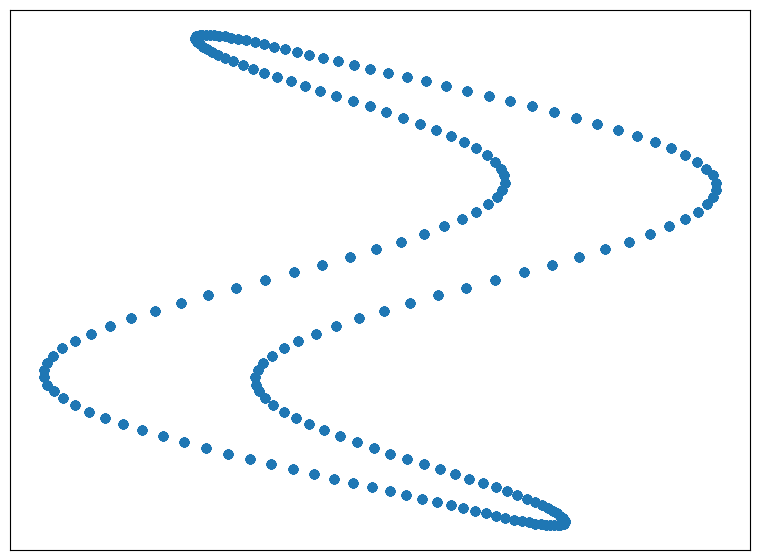

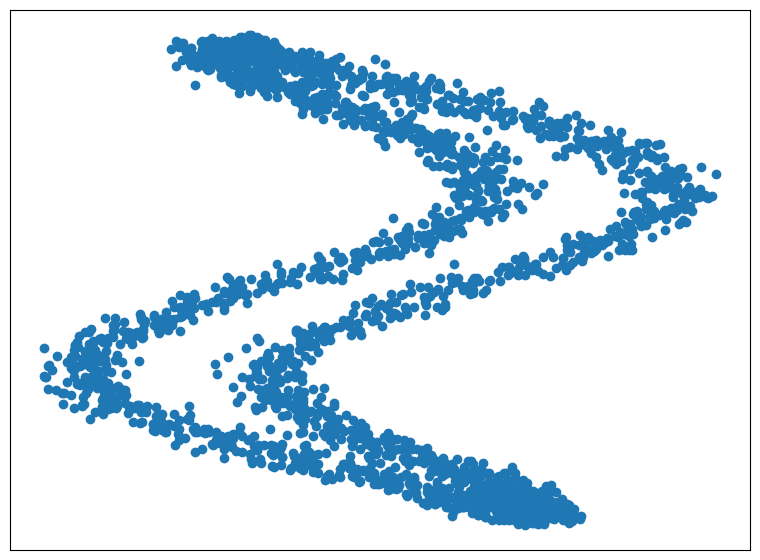

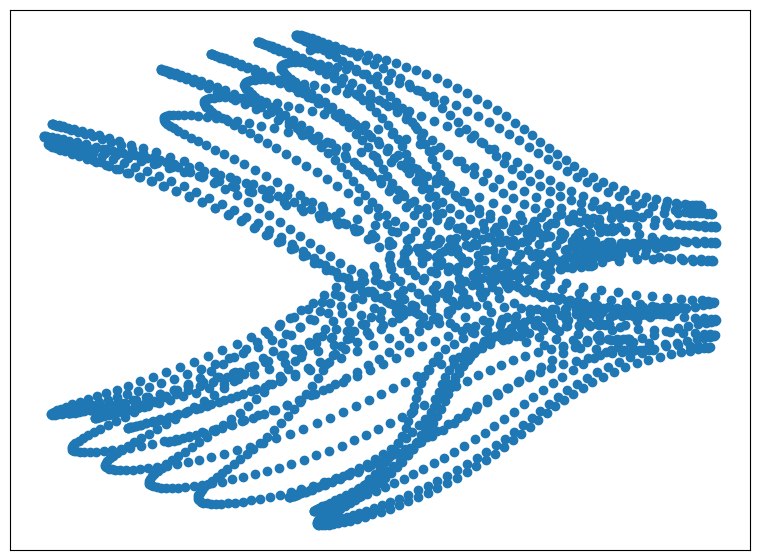

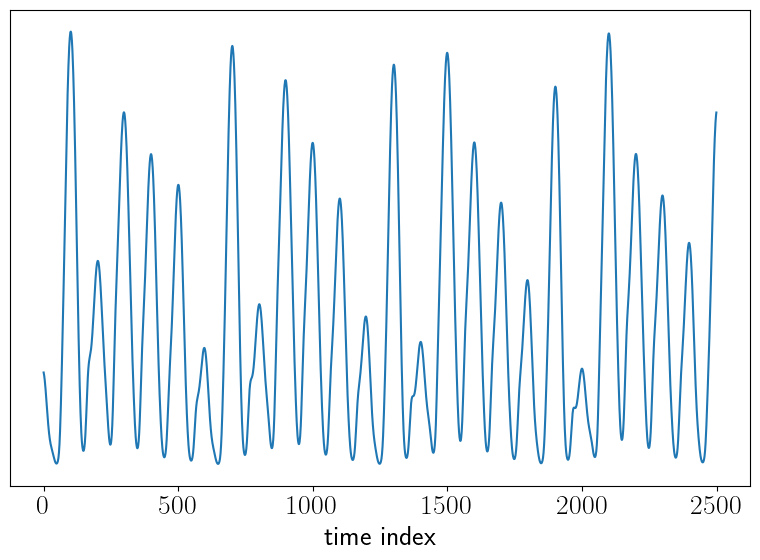

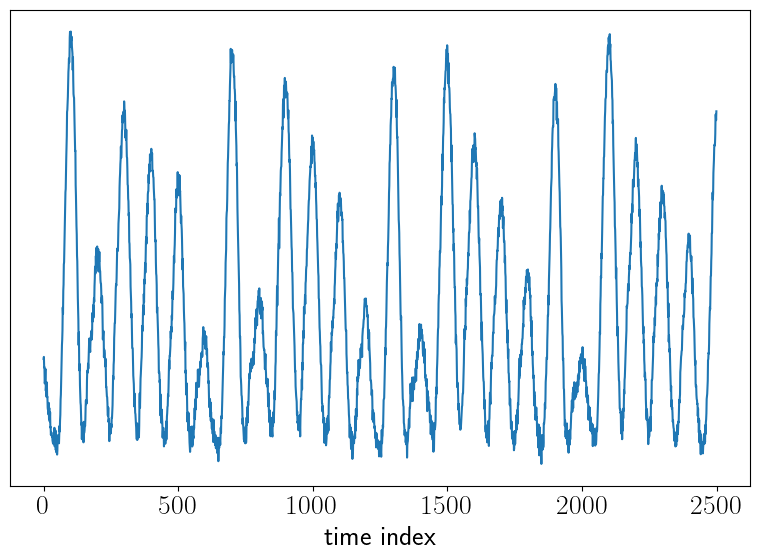

In [4]:
# Plot data dynamics
plt.figure(figsize=figsize)
plt.scatter(x_[:,0], x_[:,1])
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "x_data_clean.eps"))
plt.show()

# Plot data dynamics
plt.figure(figsize=figsize)
plt.scatter(x[:,0], x[:,1])
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "x_data.eps"))
plt.show()

# Plot latent dynamics
plt.figure(figsize=figsize)
plt.scatter(p_[:,0], p_[:,1])
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "p_data_clean.eps"))
plt.show()

# Plot signal
plt.figure(figsize=figsize)
plt.plot(i, v_)
plt.yticks([])  # Remove y-axis ticks
plt.xlabel("time index")
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "v_data_clean.eps"))
plt.show()

# Plot signal
plt.figure(figsize=figsize)
plt.plot(i, v)
plt.yticks([])  # Remove y-axis ticks
plt.xlabel("time index")
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "v_data.eps"))
plt.show()

In [5]:
# Split data into train and validation
split = 0.8
n_ = int(split * len(i))
i_train = i[:n_].float()
x_train = x[:n_].float()
v_train = v[:n_].float()
i_val = i[n_:].float()
x_val = x[n_:].float()
v_val = v[n_:].float()

### Reconstruct using LDDMD ###

In [7]:
# Construct data loader
class TimeSeriesDataset(Dataset):
    def __init__(self, i, x, v):
        self.i = i
        self.x = x
        self.v = v

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (
            self.i[idx,None],
            self.x[idx],
            self.v[idx,None]
        )

# Create the dataset
dataset = TimeSeriesDataset(i_train, x_train, v_train) 

# Create the DataLoader
batch_size = 256  # Adjust as needed
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [8]:
# Define additional neural network helpers
def create_flow_model(dim, n_flows, order):
    base_dist = distributions.StandardNormal(shape=[dim])
    transforms_list = []
    for _ in range(n_flows):
        transforms_list.append(PolynomialParityTransform(dim, order, parity=1))
    flow_transforms = transforms.CompositeTransform(transforms_list)
    return NFlowVectorDiffeomorphism(dim, flows.Flow(transform=flow_transforms, distribution=base_dist))

def create_feed_forward_model(dim_in, dim_out, n_layers, hidden_dim, order):
    if hidden_dim is None:
        hidden_dim = dim_in
    layers = []
    layers.append(nn.Linear(dim_in, hidden_dim))
    for _ in range(n_layers-1):
        layers.append(PolynomialActivation(hidden_dim, order))
        layers.append(nn.Linear(hidden_dim, hidden_dim))
    layers.append(PolynomialActivation(hidden_dim, order))
    layers.append(nn.Linear(hidden_dim, dim_out))
    return FeedForwardCoupling(dim_in, dim_out, nn.Sequential(*layers))

def create_dynamics_model(dim, dt, freqs, decays=None, init=None):
    assert dim % 2 == 0
    omegas = nn.Parameter(freqs)
    if decays is None:
        mus = torch.zeros(dim//2)
    else:
        mus = nn.Parameter(decays)
    if init is None:
        x0 = nn.Parameter(torch.zeros(dim))
    else:
        x0 = nn.Parameter(init)
    return StandardLinearDynamics(dim, dt, mus, omegas, x0)

def create_regression_model(dim_in, hidden_dim):
    layers = []
    layers.append(nn.Linear(dim_in, hidden_dim))
    layers.append(nn.Softplus()) 
    layers.append(nn.Linear(hidden_dim, 1))
    
    return nn.Sequential(*layers)

Top dominant frequencies:
0.009999999776482582
Ground truth frequencies:
0.009934588335454464


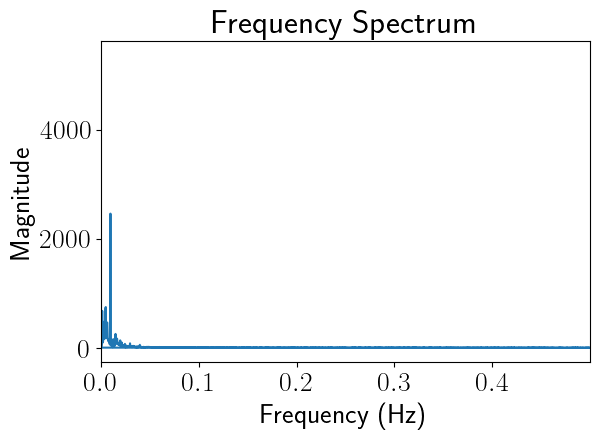

In [5]:
# Compute the FFT
fft_result = torch.fft.fft(v)

# Compute the frequency bins
n = len(i)
sample_rate = 1 / (dynamics_model_gt.dt.item() * (i[1] - i[0]))  # Assuming uniform sampling
freqs = torch.fft.fftfreq(n, d=1/sample_rate)

# Compute the magnitude spectrum
magnitude_spectrum = torch.abs(fft_result)

# Find the dominant frequencies
dominant_freqs = freqs[torch.argsort(magnitude_spectrum, descending=True)]

# Print the top dominant frequencies
print("Top dominant frequencies:")
print(dominant_freqs[1].abs().item())
print("Ground truth frequencies:")
print(dynamics_model_gt.K_2.omegas.item())

plt.plot(freqs, magnitude_spectrum)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum')
plt.xlim(0, freqs.max())  # Display only positive frequencies
plt.tight_layout()
plt.show()

In [9]:
# Initialize the models
data_dim = 2
latent_dim = 2

n_latent_flows = 1
phi_p = create_flow_model(latent_dim, n_latent_flows, 2)

n_coupling_layers = 2
hidden_dim_f = 2
f = create_feed_forward_model(data_dim, latent_dim, n_coupling_layers, hidden_dim_f, 2)

dt = dynamics_model_gt.dt
freqs = torch.tensor([dominant_freqs[1]]).abs()
K_p = create_dynamics_model(latent_dim, dt, freqs)

dynamics_model = HybridLowerTriangularNonlinearDynamics(K_p, phi_p, f).to(device)

hidden_dim_g = 4
regression_model = create_regression_model(latent_dim, hidden_dim_g).to(device)

# Combine all parameters from different components
all_params = list(dynamics_model.parameters()) + list(regression_model.parameters())

# Create the optimizer
optimizer = optim.Adam(all_params, lr=1e-3)

In [10]:
# Training loop
def train(dynamics_model, regression_model, train_loader, optimizer, n_epochs):
    loss_progression = []
    for epoch in range(n_epochs):
        for i_batch, x_batch, v_batch in tqdm(train_loader):
            optimizer.zero_grad()
            
            # Compute predictions
            p_batch_net = dynamics_model.forward(i_batch, x_batch)
            v_batch_net = regression_model(p_batch_net)

            # Compute data fidelity loss
            loss = ((v_batch - v_batch_net).abs()).mean() # l1 loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{n_epochs}, Loss: {loss.item():.4f}")
        # Save last loss of the epoch
        loss_progression.append(loss.item())
    return loss_progression

In [11]:
# Train the model
n_epochs = 1000
losses = train(dynamics_model, regression_model, train_loader, optimizer, n_epochs)

100%|██████████| 8/8 [00:00<00:00, 30.67it/s]


Epoch 1/1000, Loss: 2.3349


100%|██████████| 8/8 [00:00<00:00, 63.63it/s]


Epoch 2/1000, Loss: 2.4066


100%|██████████| 8/8 [00:00<00:00, 63.61it/s]


Epoch 3/1000, Loss: 2.7383


100%|██████████| 8/8 [00:00<00:00, 98.51it/s]


Epoch 4/1000, Loss: 2.5673


100%|██████████| 8/8 [00:00<00:00, 94.78it/s]


Epoch 5/1000, Loss: 2.5118


100%|██████████| 8/8 [00:00<00:00, 51.07it/s]


Epoch 6/1000, Loss: 2.3903


100%|██████████| 8/8 [00:00<00:00, 99.06it/s]


Epoch 7/1000, Loss: 2.2326


100%|██████████| 8/8 [00:00<00:00, 106.73it/s]


Epoch 8/1000, Loss: 2.1777


100%|██████████| 8/8 [00:00<00:00, 95.98it/s]


Epoch 9/1000, Loss: 1.9921


100%|██████████| 8/8 [00:00<00:00, 101.77it/s]


Epoch 10/1000, Loss: 2.2602


100%|██████████| 8/8 [00:00<00:00, 107.17it/s]


Epoch 11/1000, Loss: 2.0603


100%|██████████| 8/8 [00:00<00:00, 99.67it/s]


Epoch 12/1000, Loss: 1.9873


100%|██████████| 8/8 [00:00<00:00, 101.18it/s]


Epoch 13/1000, Loss: 1.7710


100%|██████████| 8/8 [00:00<00:00, 102.41it/s]


Epoch 14/1000, Loss: 1.7850


100%|██████████| 8/8 [00:00<00:00, 93.03it/s]


Epoch 15/1000, Loss: 1.3834


100%|██████████| 8/8 [00:00<00:00, 74.64it/s]


Epoch 16/1000, Loss: 1.3494


100%|██████████| 8/8 [00:00<00:00, 82.05it/s]


Epoch 17/1000, Loss: 1.1986


100%|██████████| 8/8 [00:00<00:00, 100.48it/s]


Epoch 18/1000, Loss: 1.0016


100%|██████████| 8/8 [00:00<00:00, 85.18it/s]


Epoch 19/1000, Loss: 0.8926


100%|██████████| 8/8 [00:00<00:00, 44.37it/s]


Epoch 20/1000, Loss: 0.8056


100%|██████████| 8/8 [00:00<00:00, 104.25it/s]


Epoch 21/1000, Loss: 0.7229


100%|██████████| 8/8 [00:00<00:00, 91.24it/s]


Epoch 22/1000, Loss: 0.6950


100%|██████████| 8/8 [00:00<00:00, 94.52it/s]


Epoch 23/1000, Loss: 0.6383


100%|██████████| 8/8 [00:00<00:00, 93.60it/s]


Epoch 24/1000, Loss: 0.6369


100%|██████████| 8/8 [00:00<00:00, 94.24it/s]


Epoch 25/1000, Loss: 0.6480


100%|██████████| 8/8 [00:00<00:00, 59.62it/s]


Epoch 26/1000, Loss: 0.6496


100%|██████████| 8/8 [00:00<00:00, 67.78it/s]


Epoch 27/1000, Loss: 0.6565


100%|██████████| 8/8 [00:00<00:00, 60.01it/s]


Epoch 28/1000, Loss: 0.5705


100%|██████████| 8/8 [00:00<00:00, 80.40it/s]


Epoch 29/1000, Loss: 0.6416


100%|██████████| 8/8 [00:00<00:00, 80.70it/s]


Epoch 30/1000, Loss: 0.6538


100%|██████████| 8/8 [00:00<00:00, 86.42it/s]


Epoch 31/1000, Loss: 0.6400


100%|██████████| 8/8 [00:00<00:00, 89.73it/s]


Epoch 32/1000, Loss: 0.6314


100%|██████████| 8/8 [00:00<00:00, 59.33it/s]


Epoch 33/1000, Loss: 0.6610


100%|██████████| 8/8 [00:00<00:00, 105.20it/s]


Epoch 34/1000, Loss: 0.6721


100%|██████████| 8/8 [00:00<00:00, 99.92it/s]


Epoch 35/1000, Loss: 0.6929


100%|██████████| 8/8 [00:00<00:00, 99.01it/s]


Epoch 36/1000, Loss: 0.5664


100%|██████████| 8/8 [00:00<00:00, 105.70it/s]


Epoch 37/1000, Loss: 0.6500


100%|██████████| 8/8 [00:00<00:00, 98.30it/s]


Epoch 38/1000, Loss: 0.6238


100%|██████████| 8/8 [00:00<00:00, 95.37it/s]


Epoch 39/1000, Loss: 0.5752


100%|██████████| 8/8 [00:00<00:00, 105.25it/s]


Epoch 40/1000, Loss: 0.6462


100%|██████████| 8/8 [00:00<00:00, 95.65it/s]


Epoch 41/1000, Loss: 0.6181


100%|██████████| 8/8 [00:00<00:00, 99.34it/s]


Epoch 42/1000, Loss: 0.6198


100%|██████████| 8/8 [00:00<00:00, 96.63it/s]


Epoch 43/1000, Loss: 0.6336


100%|██████████| 8/8 [00:00<00:00, 99.79it/s]


Epoch 44/1000, Loss: 0.7033


100%|██████████| 8/8 [00:00<00:00, 97.78it/s]


Epoch 45/1000, Loss: 0.5903


100%|██████████| 8/8 [00:00<00:00, 56.48it/s]


Epoch 46/1000, Loss: 0.6153


100%|██████████| 8/8 [00:00<00:00, 108.40it/s]


Epoch 47/1000, Loss: 0.6508


100%|██████████| 8/8 [00:00<00:00, 101.93it/s]


Epoch 48/1000, Loss: 0.5845


100%|██████████| 8/8 [00:00<00:00, 46.98it/s]


Epoch 49/1000, Loss: 0.5653


100%|██████████| 8/8 [00:00<00:00, 103.96it/s]


Epoch 50/1000, Loss: 0.6242


100%|██████████| 8/8 [00:00<00:00, 98.90it/s]


Epoch 51/1000, Loss: 0.5772


100%|██████████| 8/8 [00:00<00:00, 109.38it/s]


Epoch 52/1000, Loss: 0.5741


100%|██████████| 8/8 [00:00<00:00, 95.73it/s]


Epoch 53/1000, Loss: 0.5868


100%|██████████| 8/8 [00:00<00:00, 100.46it/s]


Epoch 54/1000, Loss: 0.4884


100%|██████████| 8/8 [00:00<00:00, 97.46it/s]


Epoch 55/1000, Loss: 0.5750


100%|██████████| 8/8 [00:00<00:00, 90.12it/s]


Epoch 56/1000, Loss: 0.6412


100%|██████████| 8/8 [00:00<00:00, 106.79it/s]


Epoch 57/1000, Loss: 0.5146


100%|██████████| 8/8 [00:00<00:00, 99.61it/s]


Epoch 58/1000, Loss: 0.6215


100%|██████████| 8/8 [00:00<00:00, 104.51it/s]


Epoch 59/1000, Loss: 0.5922


100%|██████████| 8/8 [00:00<00:00, 101.38it/s]


Epoch 60/1000, Loss: 0.5730


100%|██████████| 8/8 [00:00<00:00, 59.91it/s]


Epoch 61/1000, Loss: 0.5678


100%|██████████| 8/8 [00:00<00:00, 100.64it/s]


Epoch 62/1000, Loss: 0.5370


100%|██████████| 8/8 [00:00<00:00, 103.35it/s]


Epoch 63/1000, Loss: 0.5526


100%|██████████| 8/8 [00:00<00:00, 100.41it/s]


Epoch 64/1000, Loss: 0.5926


100%|██████████| 8/8 [00:00<00:00, 102.77it/s]


Epoch 65/1000, Loss: 0.5193


100%|██████████| 8/8 [00:00<00:00, 94.38it/s]


Epoch 66/1000, Loss: 0.5956


100%|██████████| 8/8 [00:00<00:00, 98.56it/s]


Epoch 67/1000, Loss: 0.5871


100%|██████████| 8/8 [00:00<00:00, 99.91it/s]


Epoch 68/1000, Loss: 0.6125


100%|██████████| 8/8 [00:00<00:00, 103.66it/s]


Epoch 69/1000, Loss: 0.5677


100%|██████████| 8/8 [00:00<00:00, 98.52it/s]


Epoch 70/1000, Loss: 0.6224


100%|██████████| 8/8 [00:00<00:00, 103.72it/s]


Epoch 71/1000, Loss: 0.5181


100%|██████████| 8/8 [00:00<00:00, 85.32it/s]


Epoch 72/1000, Loss: 0.5272


100%|██████████| 8/8 [00:00<00:00, 103.06it/s]


Epoch 73/1000, Loss: 0.5257


100%|██████████| 8/8 [00:00<00:00, 56.02it/s]


Epoch 74/1000, Loss: 0.5139


100%|██████████| 8/8 [00:00<00:00, 93.72it/s]


Epoch 75/1000, Loss: 0.5470


100%|██████████| 8/8 [00:00<00:00, 94.03it/s]


Epoch 76/1000, Loss: 0.6012


100%|██████████| 8/8 [00:00<00:00, 105.01it/s]


Epoch 77/1000, Loss: 0.5170


100%|██████████| 8/8 [00:00<00:00, 100.41it/s]


Epoch 78/1000, Loss: 0.5340


100%|██████████| 8/8 [00:00<00:00, 100.96it/s]


Epoch 79/1000, Loss: 0.5005


100%|██████████| 8/8 [00:00<00:00, 102.70it/s]


Epoch 80/1000, Loss: 0.5439


100%|██████████| 8/8 [00:00<00:00, 89.91it/s]


Epoch 81/1000, Loss: 0.4944


100%|██████████| 8/8 [00:00<00:00, 98.29it/s]


Epoch 82/1000, Loss: 0.5437


100%|██████████| 8/8 [00:00<00:00, 91.70it/s]


Epoch 83/1000, Loss: 0.5333


100%|██████████| 8/8 [00:00<00:00, 98.03it/s]


Epoch 84/1000, Loss: 0.4868


100%|██████████| 8/8 [00:00<00:00, 98.84it/s]


Epoch 85/1000, Loss: 0.4812


100%|██████████| 8/8 [00:00<00:00, 92.67it/s]


Epoch 86/1000, Loss: 0.5061


100%|██████████| 8/8 [00:00<00:00, 98.32it/s]


Epoch 87/1000, Loss: 0.5369


100%|██████████| 8/8 [00:00<00:00, 54.70it/s]


Epoch 88/1000, Loss: 0.4979


100%|██████████| 8/8 [00:00<00:00, 94.00it/s]


Epoch 89/1000, Loss: 0.4815


100%|██████████| 8/8 [00:00<00:00, 96.67it/s]


Epoch 90/1000, Loss: 0.5004


100%|██████████| 8/8 [00:00<00:00, 97.45it/s]


Epoch 91/1000, Loss: 0.5250


100%|██████████| 8/8 [00:00<00:00, 95.78it/s]


Epoch 92/1000, Loss: 0.5101


100%|██████████| 8/8 [00:00<00:00, 98.99it/s]


Epoch 93/1000, Loss: 0.5183


100%|██████████| 8/8 [00:00<00:00, 102.64it/s]


Epoch 94/1000, Loss: 0.4912


100%|██████████| 8/8 [00:00<00:00, 95.74it/s]


Epoch 95/1000, Loss: 0.4995


100%|██████████| 8/8 [00:00<00:00, 96.57it/s]


Epoch 96/1000, Loss: 0.4690


100%|██████████| 8/8 [00:00<00:00, 96.17it/s]


Epoch 97/1000, Loss: 0.4880


100%|██████████| 8/8 [00:00<00:00, 89.88it/s]


Epoch 98/1000, Loss: 0.4974


100%|██████████| 8/8 [00:00<00:00, 93.27it/s]


Epoch 99/1000, Loss: 0.5142


100%|██████████| 8/8 [00:00<00:00, 97.75it/s]


Epoch 100/1000, Loss: 0.5053


100%|██████████| 8/8 [00:00<00:00, 105.52it/s]


Epoch 101/1000, Loss: 0.5263


100%|██████████| 8/8 [00:00<00:00, 44.97it/s]


Epoch 102/1000, Loss: 0.5305


100%|██████████| 8/8 [00:00<00:00, 99.48it/s]


Epoch 103/1000, Loss: 0.5356


100%|██████████| 8/8 [00:00<00:00, 101.69it/s]


Epoch 104/1000, Loss: 0.4832


100%|██████████| 8/8 [00:00<00:00, 97.22it/s]


Epoch 105/1000, Loss: 0.5367


100%|██████████| 8/8 [00:00<00:00, 93.50it/s]


Epoch 106/1000, Loss: 0.4871


100%|██████████| 8/8 [00:00<00:00, 96.86it/s]


Epoch 107/1000, Loss: 0.4704


100%|██████████| 8/8 [00:00<00:00, 103.18it/s]


Epoch 108/1000, Loss: 0.5115


100%|██████████| 8/8 [00:00<00:00, 85.51it/s]


Epoch 109/1000, Loss: 0.5011


100%|██████████| 8/8 [00:00<00:00, 94.90it/s]


Epoch 110/1000, Loss: 0.4915


100%|██████████| 8/8 [00:00<00:00, 67.53it/s]


Epoch 111/1000, Loss: 0.4996


100%|██████████| 8/8 [00:00<00:00, 57.17it/s]


Epoch 112/1000, Loss: 0.5544


100%|██████████| 8/8 [00:00<00:00, 59.22it/s]


Epoch 113/1000, Loss: 0.4221


100%|██████████| 8/8 [00:00<00:00, 53.70it/s]


Epoch 114/1000, Loss: 0.4720


100%|██████████| 8/8 [00:00<00:00, 55.97it/s]


Epoch 115/1000, Loss: 0.5356


100%|██████████| 8/8 [00:00<00:00, 95.69it/s]


Epoch 116/1000, Loss: 0.4934


100%|██████████| 8/8 [00:00<00:00, 94.78it/s]


Epoch 117/1000, Loss: 0.5055


100%|██████████| 8/8 [00:00<00:00, 81.08it/s]


Epoch 118/1000, Loss: 0.4726


100%|██████████| 8/8 [00:00<00:00, 92.75it/s]


Epoch 119/1000, Loss: 0.4845


100%|██████████| 8/8 [00:00<00:00, 87.31it/s]


Epoch 120/1000, Loss: 0.4892


100%|██████████| 8/8 [00:00<00:00, 85.19it/s]


Epoch 121/1000, Loss: 0.4898


100%|██████████| 8/8 [00:00<00:00, 60.21it/s]


Epoch 122/1000, Loss: 0.4491


100%|██████████| 8/8 [00:00<00:00, 58.53it/s]


Epoch 123/1000, Loss: 0.4728


100%|██████████| 8/8 [00:00<00:00, 69.57it/s]


Epoch 124/1000, Loss: 0.5126


100%|██████████| 8/8 [00:00<00:00, 70.80it/s]


Epoch 125/1000, Loss: 0.4789


100%|██████████| 8/8 [00:00<00:00, 36.06it/s]


Epoch 126/1000, Loss: 0.4679


100%|██████████| 8/8 [00:00<00:00, 69.31it/s]


Epoch 127/1000, Loss: 0.4847


100%|██████████| 8/8 [00:00<00:00, 72.31it/s]


Epoch 128/1000, Loss: 0.4290


100%|██████████| 8/8 [00:00<00:00, 75.74it/s]


Epoch 129/1000, Loss: 0.4950


100%|██████████| 8/8 [00:00<00:00, 85.48it/s]


Epoch 130/1000, Loss: 0.4431


100%|██████████| 8/8 [00:00<00:00, 74.08it/s]


Epoch 131/1000, Loss: 0.4984


100%|██████████| 8/8 [00:00<00:00, 85.91it/s]


Epoch 132/1000, Loss: 0.5438


100%|██████████| 8/8 [00:00<00:00, 83.81it/s]


Epoch 133/1000, Loss: 0.5346


100%|██████████| 8/8 [00:00<00:00, 96.06it/s]


Epoch 134/1000, Loss: 0.4789


100%|██████████| 8/8 [00:00<00:00, 100.00it/s]


Epoch 135/1000, Loss: 0.5389


100%|██████████| 8/8 [00:00<00:00, 90.69it/s]


Epoch 136/1000, Loss: 0.4341


100%|██████████| 8/8 [00:00<00:00, 74.79it/s]


Epoch 137/1000, Loss: 0.4430


100%|██████████| 8/8 [00:00<00:00, 82.91it/s]


Epoch 138/1000, Loss: 0.5084


100%|██████████| 8/8 [00:00<00:00, 43.60it/s]


Epoch 139/1000, Loss: 0.5030


100%|██████████| 8/8 [00:00<00:00, 84.51it/s]


Epoch 140/1000, Loss: 0.4576


100%|██████████| 8/8 [00:00<00:00, 90.48it/s]


Epoch 141/1000, Loss: 0.4787


100%|██████████| 8/8 [00:00<00:00, 81.73it/s]


Epoch 142/1000, Loss: 0.5061


100%|██████████| 8/8 [00:00<00:00, 73.63it/s]


Epoch 143/1000, Loss: 0.4696


100%|██████████| 8/8 [00:00<00:00, 78.85it/s]


Epoch 144/1000, Loss: 0.4785


100%|██████████| 8/8 [00:00<00:00, 85.55it/s]


Epoch 145/1000, Loss: 0.4965


100%|██████████| 8/8 [00:00<00:00, 85.44it/s]


Epoch 146/1000, Loss: 0.4963


100%|██████████| 8/8 [00:00<00:00, 59.78it/s]


Epoch 147/1000, Loss: 0.4716


100%|██████████| 8/8 [00:00<00:00, 80.43it/s]


Epoch 148/1000, Loss: 0.4693


100%|██████████| 8/8 [00:00<00:00, 76.48it/s]


Epoch 149/1000, Loss: 0.4141


100%|██████████| 8/8 [00:00<00:00, 81.88it/s]


Epoch 150/1000, Loss: 0.4382


100%|██████████| 8/8 [00:00<00:00, 82.73it/s]


Epoch 151/1000, Loss: 0.4248


100%|██████████| 8/8 [00:00<00:00, 26.77it/s]


Epoch 152/1000, Loss: 0.4548


100%|██████████| 8/8 [00:00<00:00, 68.13it/s]


Epoch 153/1000, Loss: 0.5144


100%|██████████| 8/8 [00:00<00:00, 63.50it/s]


Epoch 154/1000, Loss: 0.4473


100%|██████████| 8/8 [00:00<00:00, 46.87it/s]


Epoch 155/1000, Loss: 0.4471


100%|██████████| 8/8 [00:00<00:00, 67.08it/s]


Epoch 156/1000, Loss: 0.4585


100%|██████████| 8/8 [00:00<00:00, 64.41it/s]


Epoch 157/1000, Loss: 0.4244


100%|██████████| 8/8 [00:00<00:00, 63.24it/s]


Epoch 158/1000, Loss: 0.4571


100%|██████████| 8/8 [00:00<00:00, 54.34it/s]


Epoch 159/1000, Loss: 0.3579


100%|██████████| 8/8 [00:00<00:00, 70.52it/s]


Epoch 160/1000, Loss: 0.4076


100%|██████████| 8/8 [00:00<00:00, 76.92it/s]


Epoch 161/1000, Loss: 0.4593


100%|██████████| 8/8 [00:00<00:00, 76.53it/s]


Epoch 162/1000, Loss: 0.4209


100%|██████████| 8/8 [00:00<00:00, 31.04it/s]


Epoch 163/1000, Loss: 0.4180


100%|██████████| 8/8 [00:00<00:00, 59.69it/s]


Epoch 164/1000, Loss: 0.3939


100%|██████████| 8/8 [00:00<00:00, 65.28it/s]


Epoch 165/1000, Loss: 0.3824


100%|██████████| 8/8 [00:00<00:00, 69.40it/s]


Epoch 166/1000, Loss: 0.4259


100%|██████████| 8/8 [00:00<00:00, 74.65it/s]


Epoch 167/1000, Loss: 0.3968


100%|██████████| 8/8 [00:00<00:00, 80.53it/s]


Epoch 168/1000, Loss: 0.4007


100%|██████████| 8/8 [00:00<00:00, 65.21it/s]


Epoch 169/1000, Loss: 0.3875


100%|██████████| 8/8 [00:00<00:00, 45.00it/s]


Epoch 170/1000, Loss: 0.4210


100%|██████████| 8/8 [00:00<00:00, 64.28it/s]


Epoch 171/1000, Loss: 0.3694


100%|██████████| 8/8 [00:00<00:00, 65.55it/s]


Epoch 172/1000, Loss: 0.4481


100%|██████████| 8/8 [00:00<00:00, 73.85it/s]


Epoch 173/1000, Loss: 0.4213


100%|██████████| 8/8 [00:00<00:00, 52.85it/s]


Epoch 174/1000, Loss: 0.3718


100%|██████████| 8/8 [00:00<00:00, 100.53it/s]


Epoch 175/1000, Loss: 0.4223


100%|██████████| 8/8 [00:00<00:00, 99.78it/s]


Epoch 176/1000, Loss: 0.4499


100%|██████████| 8/8 [00:00<00:00, 97.19it/s]


Epoch 177/1000, Loss: 0.3990


100%|██████████| 8/8 [00:00<00:00, 103.25it/s]


Epoch 178/1000, Loss: 0.4028


100%|██████████| 8/8 [00:00<00:00, 101.62it/s]


Epoch 179/1000, Loss: 0.4099


100%|██████████| 8/8 [00:00<00:00, 96.15it/s]


Epoch 180/1000, Loss: 0.3867


100%|██████████| 8/8 [00:00<00:00, 98.53it/s]


Epoch 181/1000, Loss: 0.3869


100%|██████████| 8/8 [00:00<00:00, 81.00it/s]


Epoch 182/1000, Loss: 0.3652


100%|██████████| 8/8 [00:00<00:00, 88.73it/s]


Epoch 183/1000, Loss: 0.3814


100%|██████████| 8/8 [00:00<00:00, 84.41it/s]


Epoch 184/1000, Loss: 0.3758


100%|██████████| 8/8 [00:00<00:00, 97.42it/s]


Epoch 185/1000, Loss: 0.4038


100%|██████████| 8/8 [00:00<00:00, 48.45it/s]


Epoch 186/1000, Loss: 0.3920


100%|██████████| 8/8 [00:00<00:00, 98.39it/s]


Epoch 187/1000, Loss: 0.3636


100%|██████████| 8/8 [00:00<00:00, 93.70it/s]


Epoch 188/1000, Loss: 0.3693


100%|██████████| 8/8 [00:00<00:00, 97.19it/s]


Epoch 189/1000, Loss: 0.4047


100%|██████████| 8/8 [00:00<00:00, 96.60it/s]


Epoch 190/1000, Loss: 0.3924


100%|██████████| 8/8 [00:00<00:00, 105.54it/s]


Epoch 191/1000, Loss: 0.3942


100%|██████████| 8/8 [00:00<00:00, 94.04it/s]


Epoch 192/1000, Loss: 0.3799


100%|██████████| 8/8 [00:00<00:00, 98.66it/s]


Epoch 193/1000, Loss: 0.3908


100%|██████████| 8/8 [00:00<00:00, 92.85it/s]


Epoch 194/1000, Loss: 0.3433


100%|██████████| 8/8 [00:00<00:00, 101.41it/s]


Epoch 195/1000, Loss: 0.4156


100%|██████████| 8/8 [00:00<00:00, 99.96it/s]


Epoch 196/1000, Loss: 0.3850


100%|██████████| 8/8 [00:00<00:00, 102.76it/s]


Epoch 197/1000, Loss: 0.3552


100%|██████████| 8/8 [00:00<00:00, 49.85it/s]


Epoch 198/1000, Loss: 0.3520


100%|██████████| 8/8 [00:00<00:00, 102.66it/s]


Epoch 199/1000, Loss: 0.3896


100%|██████████| 8/8 [00:00<00:00, 104.26it/s]


Epoch 200/1000, Loss: 0.3591


100%|██████████| 8/8 [00:00<00:00, 86.42it/s]


Epoch 201/1000, Loss: 0.3316


100%|██████████| 8/8 [00:00<00:00, 98.73it/s]


Epoch 202/1000, Loss: 0.3391


100%|██████████| 8/8 [00:00<00:00, 96.55it/s]


Epoch 203/1000, Loss: 0.3803


100%|██████████| 8/8 [00:00<00:00, 80.17it/s]


Epoch 204/1000, Loss: 0.3494


100%|██████████| 8/8 [00:00<00:00, 99.45it/s]


Epoch 205/1000, Loss: 0.3449


100%|██████████| 8/8 [00:00<00:00, 92.86it/s]


Epoch 206/1000, Loss: 0.3371


100%|██████████| 8/8 [00:00<00:00, 92.63it/s]


Epoch 207/1000, Loss: 0.4260


100%|██████████| 8/8 [00:00<00:00, 94.60it/s]


Epoch 208/1000, Loss: 0.3610


100%|██████████| 8/8 [00:00<00:00, 102.42it/s]


Epoch 209/1000, Loss: 0.3228


100%|██████████| 8/8 [00:00<00:00, 48.35it/s]


Epoch 210/1000, Loss: 0.3657


100%|██████████| 8/8 [00:00<00:00, 86.77it/s]


Epoch 211/1000, Loss: 0.3426


100%|██████████| 8/8 [00:00<00:00, 102.89it/s]


Epoch 212/1000, Loss: 0.3524


100%|██████████| 8/8 [00:00<00:00, 94.43it/s]


Epoch 213/1000, Loss: 0.3672


100%|██████████| 8/8 [00:00<00:00, 92.81it/s]


Epoch 214/1000, Loss: 0.3507


100%|██████████| 8/8 [00:00<00:00, 68.52it/s]


Epoch 215/1000, Loss: 0.3562


100%|██████████| 8/8 [00:00<00:00, 76.51it/s]


Epoch 216/1000, Loss: 0.3262


100%|██████████| 8/8 [00:00<00:00, 74.24it/s]


Epoch 217/1000, Loss: 0.3486


100%|██████████| 8/8 [00:00<00:00, 74.44it/s]


Epoch 218/1000, Loss: 0.3623


100%|██████████| 8/8 [00:00<00:00, 86.27it/s]


Epoch 219/1000, Loss: 0.3380


100%|██████████| 8/8 [00:00<00:00, 78.73it/s]


Epoch 220/1000, Loss: 0.3370


100%|██████████| 8/8 [00:00<00:00, 86.55it/s]


Epoch 221/1000, Loss: 0.3689


100%|██████████| 8/8 [00:00<00:00, 56.03it/s]


Epoch 222/1000, Loss: 0.3162


100%|██████████| 8/8 [00:00<00:00, 94.87it/s]


Epoch 223/1000, Loss: 0.3111


100%|██████████| 8/8 [00:00<00:00, 96.05it/s]


Epoch 224/1000, Loss: 0.3423


100%|██████████| 8/8 [00:00<00:00, 76.63it/s]


Epoch 225/1000, Loss: 0.3229


100%|██████████| 8/8 [00:00<00:00, 82.18it/s]


Epoch 226/1000, Loss: 0.3311


100%|██████████| 8/8 [00:00<00:00, 86.17it/s]


Epoch 227/1000, Loss: 0.2803


100%|██████████| 8/8 [00:00<00:00, 101.11it/s]


Epoch 228/1000, Loss: 0.3572


100%|██████████| 8/8 [00:00<00:00, 101.32it/s]


Epoch 229/1000, Loss: 0.3397


100%|██████████| 8/8 [00:00<00:00, 98.99it/s]


Epoch 230/1000, Loss: 0.3283


100%|██████████| 8/8 [00:00<00:00, 87.85it/s]


Epoch 231/1000, Loss: 0.3733


100%|██████████| 8/8 [00:00<00:00, 98.64it/s]


Epoch 232/1000, Loss: 0.3266


100%|██████████| 8/8 [00:00<00:00, 98.04it/s]


Epoch 233/1000, Loss: 0.3434


100%|██████████| 8/8 [00:00<00:00, 53.30it/s]


Epoch 234/1000, Loss: 0.3242


100%|██████████| 8/8 [00:00<00:00, 86.59it/s]


Epoch 235/1000, Loss: 0.3148


100%|██████████| 8/8 [00:00<00:00, 95.75it/s]


Epoch 236/1000, Loss: 0.2834


100%|██████████| 8/8 [00:00<00:00, 99.14it/s]


Epoch 237/1000, Loss: 0.3332


100%|██████████| 8/8 [00:00<00:00, 98.94it/s]


Epoch 238/1000, Loss: 0.3026


100%|██████████| 8/8 [00:00<00:00, 91.82it/s]


Epoch 239/1000, Loss: 0.3683


100%|██████████| 8/8 [00:00<00:00, 98.25it/s]


Epoch 240/1000, Loss: 0.3368


100%|██████████| 8/8 [00:00<00:00, 93.29it/s]


Epoch 241/1000, Loss: 0.3285


100%|██████████| 8/8 [00:00<00:00, 77.40it/s]


Epoch 242/1000, Loss: 0.3426


100%|██████████| 8/8 [00:00<00:00, 97.15it/s]


Epoch 243/1000, Loss: 0.2934


100%|██████████| 8/8 [00:00<00:00, 74.13it/s]


Epoch 244/1000, Loss: 0.3049


100%|██████████| 8/8 [00:00<00:00, 95.87it/s]


Epoch 245/1000, Loss: 0.3255


100%|██████████| 8/8 [00:00<00:00, 51.99it/s]


Epoch 246/1000, Loss: 0.3530


100%|██████████| 8/8 [00:00<00:00, 95.91it/s]


Epoch 247/1000, Loss: 0.3417


100%|██████████| 8/8 [00:00<00:00, 92.75it/s]


Epoch 248/1000, Loss: 0.3497


100%|██████████| 8/8 [00:00<00:00, 94.76it/s]


Epoch 249/1000, Loss: 0.3743


100%|██████████| 8/8 [00:00<00:00, 98.84it/s]


Epoch 250/1000, Loss: 0.3719


100%|██████████| 8/8 [00:00<00:00, 111.51it/s]


Epoch 251/1000, Loss: 0.3645


100%|██████████| 8/8 [00:00<00:00, 115.87it/s]


Epoch 252/1000, Loss: 0.3174


100%|██████████| 8/8 [00:00<00:00, 128.01it/s]


Epoch 253/1000, Loss: 0.3227


100%|██████████| 8/8 [00:00<00:00, 122.74it/s]


Epoch 254/1000, Loss: 0.3161


100%|██████████| 8/8 [00:00<00:00, 126.65it/s]


Epoch 255/1000, Loss: 0.2992


100%|██████████| 8/8 [00:00<00:00, 54.81it/s]


Epoch 256/1000, Loss: 0.3051


100%|██████████| 8/8 [00:00<00:00, 121.50it/s]


Epoch 257/1000, Loss: 0.2627


100%|██████████| 8/8 [00:00<00:00, 131.33it/s]


Epoch 258/1000, Loss: 0.2727


100%|██████████| 8/8 [00:00<00:00, 122.61it/s]


Epoch 259/1000, Loss: 0.2713


100%|██████████| 8/8 [00:00<00:00, 124.23it/s]


Epoch 260/1000, Loss: 0.2659


100%|██████████| 8/8 [00:00<00:00, 129.47it/s]


Epoch 261/1000, Loss: 0.3125


100%|██████████| 8/8 [00:00<00:00, 126.63it/s]

Epoch 262/1000, Loss: 0.2808



100%|██████████| 8/8 [00:00<00:00, 116.36it/s]


Epoch 263/1000, Loss: 0.2788


100%|██████████| 8/8 [00:00<00:00, 116.68it/s]


Epoch 264/1000, Loss: 0.3032


100%|██████████| 8/8 [00:00<00:00, 118.28it/s]


Epoch 265/1000, Loss: 0.3149


100%|██████████| 8/8 [00:00<00:00, 68.49it/s]


Epoch 266/1000, Loss: 0.2979


100%|██████████| 8/8 [00:00<00:00, 114.57it/s]


Epoch 267/1000, Loss: 0.3176


100%|██████████| 8/8 [00:00<00:00, 119.55it/s]


Epoch 268/1000, Loss: 0.3080


100%|██████████| 8/8 [00:00<00:00, 117.53it/s]


Epoch 269/1000, Loss: 0.2781


100%|██████████| 8/8 [00:00<00:00, 119.18it/s]


Epoch 270/1000, Loss: 0.2725


100%|██████████| 8/8 [00:00<00:00, 117.81it/s]


Epoch 271/1000, Loss: 0.2824


100%|██████████| 8/8 [00:00<00:00, 125.54it/s]


Epoch 272/1000, Loss: 0.2939


100%|██████████| 8/8 [00:00<00:00, 121.25it/s]


Epoch 273/1000, Loss: 0.2618


100%|██████████| 8/8 [00:00<00:00, 124.08it/s]


Epoch 274/1000, Loss: 0.2652


100%|██████████| 8/8 [00:00<00:00, 128.03it/s]


Epoch 275/1000, Loss: 0.2726


100%|██████████| 8/8 [00:00<00:00, 121.86it/s]


Epoch 276/1000, Loss: 0.3047


100%|██████████| 8/8 [00:00<00:00, 125.89it/s]


Epoch 277/1000, Loss: 0.2934


100%|██████████| 8/8 [00:00<00:00, 123.62it/s]


Epoch 278/1000, Loss: 0.2491


100%|██████████| 8/8 [00:00<00:00, 120.08it/s]


Epoch 279/1000, Loss: 0.2551


100%|██████████| 8/8 [00:00<00:00, 125.14it/s]


Epoch 280/1000, Loss: 0.3048


100%|██████████| 8/8 [00:00<00:00, 124.88it/s]


Epoch 281/1000, Loss: 0.2590


100%|██████████| 8/8 [00:00<00:00, 127.47it/s]


Epoch 282/1000, Loss: 0.3206


100%|██████████| 8/8 [00:00<00:00, 123.26it/s]


Epoch 283/1000, Loss: 0.2658


100%|██████████| 8/8 [00:00<00:00, 117.60it/s]


Epoch 284/1000, Loss: 0.2960


100%|██████████| 8/8 [00:00<00:00, 114.63it/s]


Epoch 285/1000, Loss: 0.2987


100%|██████████| 8/8 [00:00<00:00, 40.93it/s]


Epoch 286/1000, Loss: 0.3165


100%|██████████| 8/8 [00:00<00:00, 65.95it/s]


Epoch 287/1000, Loss: 0.2605


100%|██████████| 8/8 [00:00<00:00, 59.87it/s]


Epoch 288/1000, Loss: 0.2861


100%|██████████| 8/8 [00:00<00:00, 66.28it/s]


Epoch 289/1000, Loss: 0.2605


100%|██████████| 8/8 [00:00<00:00, 61.63it/s]


Epoch 290/1000, Loss: 0.2539


100%|██████████| 8/8 [00:00<00:00, 76.76it/s]


Epoch 291/1000, Loss: 0.2407


100%|██████████| 8/8 [00:00<00:00, 84.12it/s]


Epoch 292/1000, Loss: 0.3079


100%|██████████| 8/8 [00:00<00:00, 83.84it/s]


Epoch 293/1000, Loss: 0.2778


100%|██████████| 8/8 [00:00<00:00, 87.38it/s]


Epoch 294/1000, Loss: 0.2723


100%|██████████| 8/8 [00:00<00:00, 94.22it/s]


Epoch 295/1000, Loss: 0.2752


100%|██████████| 8/8 [00:00<00:00, 108.69it/s]


Epoch 296/1000, Loss: 0.2736


100%|██████████| 8/8 [00:00<00:00, 99.73it/s]


Epoch 297/1000, Loss: 0.2544


100%|██████████| 8/8 [00:00<00:00, 107.10it/s]


Epoch 298/1000, Loss: 0.2927


100%|██████████| 8/8 [00:00<00:00, 112.09it/s]


Epoch 299/1000, Loss: 0.2684


100%|██████████| 8/8 [00:00<00:00, 85.87it/s]


Epoch 300/1000, Loss: 0.2945


100%|██████████| 8/8 [00:00<00:00, 94.34it/s]


Epoch 301/1000, Loss: 0.2542


100%|██████████| 8/8 [00:00<00:00, 122.00it/s]


Epoch 302/1000, Loss: 0.2553


100%|██████████| 8/8 [00:00<00:00, 99.06it/s]


Epoch 303/1000, Loss: 0.2479


100%|██████████| 8/8 [00:00<00:00, 120.53it/s]


Epoch 304/1000, Loss: 0.2648


100%|██████████| 8/8 [00:00<00:00, 110.35it/s]


Epoch 305/1000, Loss: 0.2799


100%|██████████| 8/8 [00:00<00:00, 113.04it/s]


Epoch 306/1000, Loss: 0.2573


100%|██████████| 8/8 [00:00<00:00, 60.51it/s]


Epoch 307/1000, Loss: 0.2897


100%|██████████| 8/8 [00:00<00:00, 114.44it/s]


Epoch 308/1000, Loss: 0.2841


100%|██████████| 8/8 [00:00<00:00, 109.57it/s]


Epoch 309/1000, Loss: 0.2651


100%|██████████| 8/8 [00:00<00:00, 116.14it/s]


Epoch 310/1000, Loss: 0.2797


100%|██████████| 8/8 [00:00<00:00, 108.33it/s]


Epoch 311/1000, Loss: 0.2530


100%|██████████| 8/8 [00:00<00:00, 115.66it/s]


Epoch 312/1000, Loss: 0.2793


100%|██████████| 8/8 [00:00<00:00, 112.14it/s]


Epoch 313/1000, Loss: 0.2825


100%|██████████| 8/8 [00:00<00:00, 119.90it/s]


Epoch 314/1000, Loss: 0.2664


100%|██████████| 8/8 [00:00<00:00, 98.93it/s]


Epoch 315/1000, Loss: 0.2540


100%|██████████| 8/8 [00:00<00:00, 112.00it/s]


Epoch 316/1000, Loss: 0.2550


100%|██████████| 8/8 [00:00<00:00, 112.32it/s]


Epoch 317/1000, Loss: 0.2598


100%|██████████| 8/8 [00:00<00:00, 109.04it/s]


Epoch 318/1000, Loss: 0.2822


100%|██████████| 8/8 [00:00<00:00, 111.12it/s]


Epoch 319/1000, Loss: 0.2583


100%|██████████| 8/8 [00:00<00:00, 105.84it/s]


Epoch 320/1000, Loss: 0.2470


100%|██████████| 8/8 [00:00<00:00, 124.33it/s]


Epoch 321/1000, Loss: 0.2540


100%|██████████| 8/8 [00:00<00:00, 123.79it/s]


Epoch 322/1000, Loss: 0.2740


100%|██████████| 8/8 [00:00<00:00, 107.50it/s]


Epoch 323/1000, Loss: 0.2663


100%|██████████| 8/8 [00:00<00:00, 30.11it/s]


Epoch 324/1000, Loss: 0.2978


100%|██████████| 8/8 [00:00<00:00, 68.43it/s]


Epoch 325/1000, Loss: 0.2546


100%|██████████| 8/8 [00:00<00:00, 94.28it/s]


Epoch 326/1000, Loss: 0.2756


100%|██████████| 8/8 [00:00<00:00, 102.69it/s]


Epoch 327/1000, Loss: 0.2808


100%|██████████| 8/8 [00:00<00:00, 105.84it/s]


Epoch 328/1000, Loss: 0.2553


100%|██████████| 8/8 [00:00<00:00, 100.53it/s]


Epoch 329/1000, Loss: 0.2430


100%|██████████| 8/8 [00:00<00:00, 100.21it/s]


Epoch 330/1000, Loss: 0.2406


100%|██████████| 8/8 [00:00<00:00, 67.47it/s]


Epoch 331/1000, Loss: 0.2653


100%|██████████| 8/8 [00:00<00:00, 67.29it/s]


Epoch 332/1000, Loss: 0.2696


100%|██████████| 8/8 [00:00<00:00, 92.51it/s]


Epoch 333/1000, Loss: 0.2852


100%|██████████| 8/8 [00:00<00:00, 80.51it/s]


Epoch 334/1000, Loss: 0.2380


100%|██████████| 8/8 [00:00<00:00, 70.79it/s]


Epoch 335/1000, Loss: 0.2767


100%|██████████| 8/8 [00:00<00:00, 83.62it/s]


Epoch 336/1000, Loss: 0.3132


100%|██████████| 8/8 [00:00<00:00, 73.17it/s]


Epoch 337/1000, Loss: 0.2993


100%|██████████| 8/8 [00:00<00:00, 121.25it/s]


Epoch 338/1000, Loss: 0.2491


100%|██████████| 8/8 [00:00<00:00, 119.14it/s]


Epoch 339/1000, Loss: 0.3187


100%|██████████| 8/8 [00:00<00:00, 96.34it/s]


Epoch 340/1000, Loss: 0.2429


100%|██████████| 8/8 [00:00<00:00, 96.51it/s]


Epoch 341/1000, Loss: 0.2487


100%|██████████| 8/8 [00:00<00:00, 49.48it/s]


Epoch 342/1000, Loss: 0.2471


100%|██████████| 8/8 [00:00<00:00, 88.53it/s]


Epoch 343/1000, Loss: 0.2714


100%|██████████| 8/8 [00:00<00:00, 103.96it/s]


Epoch 344/1000, Loss: 0.2574


100%|██████████| 8/8 [00:00<00:00, 83.72it/s]


Epoch 345/1000, Loss: 0.3055


100%|██████████| 8/8 [00:00<00:00, 71.86it/s]


Epoch 346/1000, Loss: 0.2855


100%|██████████| 8/8 [00:00<00:00, 81.64it/s]


Epoch 347/1000, Loss: 0.2773


100%|██████████| 8/8 [00:00<00:00, 88.23it/s]


Epoch 348/1000, Loss: 0.2743


100%|██████████| 8/8 [00:00<00:00, 100.69it/s]


Epoch 349/1000, Loss: 0.2585


100%|██████████| 8/8 [00:00<00:00, 71.85it/s]


Epoch 350/1000, Loss: 0.2332


100%|██████████| 8/8 [00:00<00:00, 111.01it/s]


Epoch 351/1000, Loss: 0.2979


100%|██████████| 8/8 [00:00<00:00, 113.69it/s]


Epoch 352/1000, Loss: 0.2759


100%|██████████| 8/8 [00:00<00:00, 99.22it/s]


Epoch 353/1000, Loss: 0.2654


100%|██████████| 8/8 [00:00<00:00, 127.19it/s]


Epoch 354/1000, Loss: 0.2636


100%|██████████| 8/8 [00:00<00:00, 116.63it/s]


Epoch 355/1000, Loss: 0.2593


100%|██████████| 8/8 [00:00<00:00, 97.27it/s]


Epoch 356/1000, Loss: 0.2668


100%|██████████| 8/8 [00:00<00:00, 56.17it/s]


Epoch 357/1000, Loss: 0.2730


100%|██████████| 8/8 [00:00<00:00, 131.78it/s]


Epoch 358/1000, Loss: 0.2846


100%|██████████| 8/8 [00:00<00:00, 122.40it/s]


Epoch 359/1000, Loss: 0.2585


100%|██████████| 8/8 [00:00<00:00, 53.24it/s]


Epoch 360/1000, Loss: 0.2716


100%|██████████| 8/8 [00:00<00:00, 71.12it/s]


Epoch 361/1000, Loss: 0.2623


100%|██████████| 8/8 [00:00<00:00, 107.59it/s]


Epoch 362/1000, Loss: 0.2174


100%|██████████| 8/8 [00:00<00:00, 107.46it/s]


Epoch 363/1000, Loss: 0.2650


100%|██████████| 8/8 [00:00<00:00, 109.67it/s]


Epoch 364/1000, Loss: 0.2263


100%|██████████| 8/8 [00:00<00:00, 123.45it/s]


Epoch 365/1000, Loss: 0.2420


100%|██████████| 8/8 [00:00<00:00, 119.89it/s]


Epoch 366/1000, Loss: 0.2724


100%|██████████| 8/8 [00:00<00:00, 104.17it/s]


Epoch 367/1000, Loss: 0.2673


100%|██████████| 8/8 [00:00<00:00, 104.84it/s]


Epoch 368/1000, Loss: 0.2580


100%|██████████| 8/8 [00:00<00:00, 90.53it/s]


Epoch 369/1000, Loss: 0.2727


100%|██████████| 8/8 [00:00<00:00, 105.37it/s]


Epoch 370/1000, Loss: 0.2806


100%|██████████| 8/8 [00:00<00:00, 111.14it/s]


Epoch 371/1000, Loss: 0.2748


100%|██████████| 8/8 [00:00<00:00, 127.04it/s]


Epoch 372/1000, Loss: 0.2666


100%|██████████| 8/8 [00:00<00:00, 129.73it/s]


Epoch 373/1000, Loss: 0.2773


100%|██████████| 8/8 [00:00<00:00, 71.32it/s]


Epoch 374/1000, Loss: 0.2342


100%|██████████| 8/8 [00:00<00:00, 106.15it/s]


Epoch 375/1000, Loss: 0.2916


100%|██████████| 8/8 [00:00<00:00, 104.32it/s]


Epoch 376/1000, Loss: 0.2621


100%|██████████| 8/8 [00:00<00:00, 126.11it/s]


Epoch 377/1000, Loss: 0.2607


100%|██████████| 8/8 [00:00<00:00, 119.48it/s]


Epoch 378/1000, Loss: 0.2550


100%|██████████| 8/8 [00:00<00:00, 96.88it/s]


Epoch 379/1000, Loss: 0.2390


100%|██████████| 8/8 [00:00<00:00, 117.23it/s]


Epoch 380/1000, Loss: 0.2636


100%|██████████| 8/8 [00:00<00:00, 113.03it/s]


Epoch 381/1000, Loss: 0.2512


100%|██████████| 8/8 [00:00<00:00, 94.16it/s]


Epoch 382/1000, Loss: 0.2886


100%|██████████| 8/8 [00:00<00:00, 94.23it/s]


Epoch 383/1000, Loss: 0.2828


100%|██████████| 8/8 [00:00<00:00, 90.21it/s]


Epoch 384/1000, Loss: 0.2393


100%|██████████| 8/8 [00:00<00:00, 98.91it/s]


Epoch 385/1000, Loss: 0.2626


100%|██████████| 8/8 [00:00<00:00, 114.36it/s]


Epoch 386/1000, Loss: 0.2196


100%|██████████| 8/8 [00:00<00:00, 118.05it/s]


Epoch 387/1000, Loss: 0.2643


100%|██████████| 8/8 [00:00<00:00, 125.64it/s]


Epoch 388/1000, Loss: 0.2692


100%|██████████| 8/8 [00:00<00:00, 125.94it/s]


Epoch 389/1000, Loss: 0.2624


100%|██████████| 8/8 [00:00<00:00, 133.31it/s]


Epoch 390/1000, Loss: 0.2618


100%|██████████| 8/8 [00:00<00:00, 68.34it/s]


Epoch 391/1000, Loss: 0.2525


100%|██████████| 8/8 [00:00<00:00, 124.89it/s]


Epoch 392/1000, Loss: 0.2585


100%|██████████| 8/8 [00:00<00:00, 115.37it/s]


Epoch 393/1000, Loss: 0.2581


100%|██████████| 8/8 [00:00<00:00, 126.10it/s]


Epoch 394/1000, Loss: 0.2677


100%|██████████| 8/8 [00:00<00:00, 128.62it/s]


Epoch 395/1000, Loss: 0.2585


100%|██████████| 8/8 [00:00<00:00, 106.89it/s]


Epoch 396/1000, Loss: 0.2720


100%|██████████| 8/8 [00:00<00:00, 115.72it/s]


Epoch 397/1000, Loss: 0.2623


100%|██████████| 8/8 [00:00<00:00, 122.60it/s]


Epoch 398/1000, Loss: 0.2940


100%|██████████| 8/8 [00:00<00:00, 107.74it/s]


Epoch 399/1000, Loss: 0.2611


100%|██████████| 8/8 [00:00<00:00, 109.93it/s]


Epoch 400/1000, Loss: 0.2388


100%|██████████| 8/8 [00:00<00:00, 104.30it/s]


Epoch 401/1000, Loss: 0.2544


100%|██████████| 8/8 [00:00<00:00, 122.09it/s]


Epoch 402/1000, Loss: 0.2741


100%|██████████| 8/8 [00:00<00:00, 119.86it/s]


Epoch 403/1000, Loss: 0.2385


100%|██████████| 8/8 [00:00<00:00, 120.14it/s]


Epoch 404/1000, Loss: 0.2542


100%|██████████| 8/8 [00:00<00:00, 102.48it/s]


Epoch 405/1000, Loss: 0.2291


100%|██████████| 8/8 [00:00<00:00, 65.75it/s]


Epoch 406/1000, Loss: 0.2323


100%|██████████| 8/8 [00:00<00:00, 42.12it/s]


Epoch 407/1000, Loss: 0.2494


100%|██████████| 8/8 [00:00<00:00, 75.68it/s]


Epoch 408/1000, Loss: 0.2536


100%|██████████| 8/8 [00:00<00:00, 96.06it/s]


Epoch 409/1000, Loss: 0.2496


100%|██████████| 8/8 [00:00<00:00, 90.97it/s]


Epoch 410/1000, Loss: 0.2471


100%|██████████| 8/8 [00:00<00:00, 92.27it/s]


Epoch 411/1000, Loss: 0.2222


100%|██████████| 8/8 [00:00<00:00, 98.79it/s]


Epoch 412/1000, Loss: 0.2354


100%|██████████| 8/8 [00:00<00:00, 111.20it/s]


Epoch 413/1000, Loss: 0.2410


100%|██████████| 8/8 [00:00<00:00, 111.07it/s]


Epoch 414/1000, Loss: 0.2899


100%|██████████| 8/8 [00:00<00:00, 121.66it/s]


Epoch 415/1000, Loss: 0.2600


100%|██████████| 8/8 [00:00<00:00, 81.13it/s]


Epoch 416/1000, Loss: 0.2376


100%|██████████| 8/8 [00:00<00:00, 89.16it/s]


Epoch 417/1000, Loss: 0.2451


100%|██████████| 8/8 [00:00<00:00, 94.78it/s]


Epoch 418/1000, Loss: 0.2734


100%|██████████| 8/8 [00:00<00:00, 95.95it/s]


Epoch 419/1000, Loss: 0.2464


100%|██████████| 8/8 [00:00<00:00, 108.92it/s]


Epoch 420/1000, Loss: 0.2624


100%|██████████| 8/8 [00:00<00:00, 108.88it/s]


Epoch 421/1000, Loss: 0.2304


100%|██████████| 8/8 [00:00<00:00, 94.33it/s]


Epoch 422/1000, Loss: 0.2531


100%|██████████| 8/8 [00:00<00:00, 41.85it/s]


Epoch 423/1000, Loss: 0.2546


100%|██████████| 8/8 [00:00<00:00, 108.80it/s]


Epoch 424/1000, Loss: 0.2839


100%|██████████| 8/8 [00:00<00:00, 99.33it/s]


Epoch 425/1000, Loss: 0.2478


100%|██████████| 8/8 [00:00<00:00, 77.37it/s]


Epoch 426/1000, Loss: 0.2578


100%|██████████| 8/8 [00:00<00:00, 71.24it/s]


Epoch 427/1000, Loss: 0.2566


100%|██████████| 8/8 [00:00<00:00, 81.16it/s]


Epoch 428/1000, Loss: 0.2481


100%|██████████| 8/8 [00:00<00:00, 73.85it/s]


Epoch 429/1000, Loss: 0.2402


100%|██████████| 8/8 [00:00<00:00, 73.53it/s]


Epoch 430/1000, Loss: 0.2452


100%|██████████| 8/8 [00:00<00:00, 49.71it/s]


Epoch 431/1000, Loss: 0.2647


100%|██████████| 8/8 [00:00<00:00, 62.73it/s]


Epoch 432/1000, Loss: 0.2723


100%|██████████| 8/8 [00:00<00:00, 114.24it/s]


Epoch 433/1000, Loss: 0.2422


100%|██████████| 8/8 [00:00<00:00, 96.08it/s]


Epoch 434/1000, Loss: 0.2610


100%|██████████| 8/8 [00:00<00:00, 70.81it/s]


Epoch 435/1000, Loss: 0.2640


100%|██████████| 8/8 [00:00<00:00, 86.71it/s]


Epoch 436/1000, Loss: 0.2301


100%|██████████| 8/8 [00:00<00:00, 121.07it/s]


Epoch 437/1000, Loss: 0.2645


100%|██████████| 8/8 [00:00<00:00, 50.30it/s]


Epoch 438/1000, Loss: 0.2521


100%|██████████| 8/8 [00:00<00:00, 103.58it/s]


Epoch 439/1000, Loss: 0.2359


100%|██████████| 8/8 [00:00<00:00, 105.88it/s]


Epoch 440/1000, Loss: 0.2663


100%|██████████| 8/8 [00:00<00:00, 102.80it/s]


Epoch 441/1000, Loss: 0.2355


100%|██████████| 8/8 [00:00<00:00, 91.87it/s]


Epoch 442/1000, Loss: 0.2526


100%|██████████| 8/8 [00:00<00:00, 98.87it/s]


Epoch 443/1000, Loss: 0.2414


100%|██████████| 8/8 [00:00<00:00, 103.66it/s]


Epoch 444/1000, Loss: 0.2514


100%|██████████| 8/8 [00:00<00:00, 106.44it/s]


Epoch 445/1000, Loss: 0.2453


100%|██████████| 8/8 [00:00<00:00, 115.06it/s]


Epoch 446/1000, Loss: 0.2413


100%|██████████| 8/8 [00:00<00:00, 105.96it/s]


Epoch 447/1000, Loss: 0.2671


100%|██████████| 8/8 [00:00<00:00, 127.16it/s]


Epoch 448/1000, Loss: 0.2783


100%|██████████| 8/8 [00:00<00:00, 125.95it/s]


Epoch 449/1000, Loss: 0.2737


100%|██████████| 8/8 [00:00<00:00, 130.01it/s]


Epoch 450/1000, Loss: 0.2504


100%|██████████| 8/8 [00:00<00:00, 120.63it/s]


Epoch 451/1000, Loss: 0.2275


100%|██████████| 8/8 [00:00<00:00, 58.41it/s]


Epoch 452/1000, Loss: 0.2443


100%|██████████| 8/8 [00:00<00:00, 76.68it/s]


Epoch 453/1000, Loss: 0.2334


100%|██████████| 8/8 [00:00<00:00, 61.94it/s]


Epoch 454/1000, Loss: 0.2150


100%|██████████| 8/8 [00:00<00:00, 62.36it/s]


Epoch 455/1000, Loss: 0.2471


100%|██████████| 8/8 [00:00<00:00, 56.23it/s]


Epoch 456/1000, Loss: 0.2388


100%|██████████| 8/8 [00:00<00:00, 55.64it/s]


Epoch 457/1000, Loss: 0.2333


100%|██████████| 8/8 [00:00<00:00, 82.05it/s]


Epoch 458/1000, Loss: 0.2578


100%|██████████| 8/8 [00:00<00:00, 81.20it/s]


Epoch 459/1000, Loss: 0.2333


100%|██████████| 8/8 [00:00<00:00, 100.79it/s]


Epoch 460/1000, Loss: 0.2633


100%|██████████| 8/8 [00:00<00:00, 74.16it/s]


Epoch 461/1000, Loss: 0.2666


100%|██████████| 8/8 [00:00<00:00, 75.89it/s]


Epoch 462/1000, Loss: 0.2299


100%|██████████| 8/8 [00:00<00:00, 37.44it/s]


Epoch 463/1000, Loss: 0.2413


100%|██████████| 8/8 [00:00<00:00, 69.91it/s]


Epoch 464/1000, Loss: 0.2491


100%|██████████| 8/8 [00:00<00:00, 49.12it/s]


Epoch 465/1000, Loss: 0.2628


100%|██████████| 8/8 [00:00<00:00, 80.58it/s]


Epoch 466/1000, Loss: 0.2910


100%|██████████| 8/8 [00:00<00:00, 85.16it/s]


Epoch 467/1000, Loss: 0.2505


100%|██████████| 8/8 [00:00<00:00, 63.54it/s]


Epoch 468/1000, Loss: 0.2499


100%|██████████| 8/8 [00:00<00:00, 100.66it/s]


Epoch 469/1000, Loss: 0.2475


100%|██████████| 8/8 [00:00<00:00, 101.26it/s]


Epoch 470/1000, Loss: 0.2440


100%|██████████| 8/8 [00:00<00:00, 107.20it/s]


Epoch 471/1000, Loss: 0.2627


100%|██████████| 8/8 [00:00<00:00, 111.40it/s]


Epoch 472/1000, Loss: 0.2512


100%|██████████| 8/8 [00:00<00:00, 104.02it/s]


Epoch 473/1000, Loss: 0.2293


100%|██████████| 8/8 [00:00<00:00, 93.21it/s]


Epoch 474/1000, Loss: 0.2289


100%|██████████| 8/8 [00:00<00:00, 100.65it/s]


Epoch 475/1000, Loss: 0.2437


100%|██████████| 8/8 [00:00<00:00, 105.59it/s]


Epoch 476/1000, Loss: 0.2627


100%|██████████| 8/8 [00:00<00:00, 109.94it/s]


Epoch 477/1000, Loss: 0.2357


100%|██████████| 8/8 [00:00<00:00, 116.30it/s]


Epoch 478/1000, Loss: 0.2646


100%|██████████| 8/8 [00:00<00:00, 89.21it/s]


Epoch 479/1000, Loss: 0.2441


100%|██████████| 8/8 [00:00<00:00, 67.61it/s]


Epoch 480/1000, Loss: 0.2304


100%|██████████| 8/8 [00:00<00:00, 117.40it/s]


Epoch 481/1000, Loss: 0.2568


100%|██████████| 8/8 [00:00<00:00, 53.45it/s]


Epoch 482/1000, Loss: 0.2630


100%|██████████| 8/8 [00:00<00:00, 100.86it/s]


Epoch 483/1000, Loss: 0.2626


100%|██████████| 8/8 [00:00<00:00, 127.08it/s]


Epoch 484/1000, Loss: 0.2600


100%|██████████| 8/8 [00:00<00:00, 79.90it/s]


Epoch 485/1000, Loss: 0.2342


100%|██████████| 8/8 [00:00<00:00, 107.75it/s]


Epoch 486/1000, Loss: 0.2344


100%|██████████| 8/8 [00:00<00:00, 87.99it/s]


Epoch 487/1000, Loss: 0.2647


100%|██████████| 8/8 [00:00<00:00, 118.23it/s]


Epoch 488/1000, Loss: 0.2505


100%|██████████| 8/8 [00:00<00:00, 115.98it/s]


Epoch 489/1000, Loss: 0.2275


100%|██████████| 8/8 [00:00<00:00, 125.57it/s]


Epoch 490/1000, Loss: 0.2377


100%|██████████| 8/8 [00:00<00:00, 70.92it/s]


Epoch 491/1000, Loss: 0.2502


100%|██████████| 8/8 [00:00<00:00, 84.34it/s]


Epoch 492/1000, Loss: 0.2312


100%|██████████| 8/8 [00:00<00:00, 87.17it/s]


Epoch 493/1000, Loss: 0.2372


100%|██████████| 8/8 [00:00<00:00, 94.20it/s]


Epoch 494/1000, Loss: 0.2287


100%|██████████| 8/8 [00:00<00:00, 70.53it/s]


Epoch 495/1000, Loss: 0.2281


100%|██████████| 8/8 [00:00<00:00, 46.46it/s]


Epoch 496/1000, Loss: 0.2410


100%|██████████| 8/8 [00:00<00:00, 89.47it/s]


Epoch 497/1000, Loss: 0.2853


100%|██████████| 8/8 [00:00<00:00, 87.30it/s]


Epoch 498/1000, Loss: 0.2488


100%|██████████| 8/8 [00:00<00:00, 82.65it/s]


Epoch 499/1000, Loss: 0.2372


100%|██████████| 8/8 [00:00<00:00, 83.30it/s]


Epoch 500/1000, Loss: 0.2386


100%|██████████| 8/8 [00:00<00:00, 87.40it/s]


Epoch 501/1000, Loss: 0.2642


100%|██████████| 8/8 [00:00<00:00, 80.95it/s]


Epoch 502/1000, Loss: 0.2328


100%|██████████| 8/8 [00:00<00:00, 73.09it/s]


Epoch 503/1000, Loss: 0.2387


100%|██████████| 8/8 [00:00<00:00, 90.79it/s]


Epoch 504/1000, Loss: 0.2553


100%|██████████| 8/8 [00:00<00:00, 107.07it/s]


Epoch 505/1000, Loss: 0.2531


100%|██████████| 8/8 [00:00<00:00, 83.45it/s]


Epoch 506/1000, Loss: 0.2126


100%|██████████| 8/8 [00:00<00:00, 93.53it/s]


Epoch 507/1000, Loss: 0.2567


100%|██████████| 8/8 [00:00<00:00, 119.71it/s]


Epoch 508/1000, Loss: 0.2624


100%|██████████| 8/8 [00:00<00:00, 121.45it/s]


Epoch 509/1000, Loss: 0.2205


100%|██████████| 8/8 [00:00<00:00, 58.28it/s]


Epoch 510/1000, Loss: 0.2506


100%|██████████| 8/8 [00:00<00:00, 116.89it/s]


Epoch 511/1000, Loss: 0.2329


100%|██████████| 8/8 [00:00<00:00, 109.02it/s]


Epoch 512/1000, Loss: 0.2449


100%|██████████| 8/8 [00:00<00:00, 114.18it/s]


Epoch 513/1000, Loss: 0.2349


100%|██████████| 8/8 [00:00<00:00, 96.52it/s]


Epoch 514/1000, Loss: 0.2397


100%|██████████| 8/8 [00:00<00:00, 87.11it/s]


Epoch 515/1000, Loss: 0.2586


100%|██████████| 8/8 [00:00<00:00, 83.44it/s]


Epoch 516/1000, Loss: 0.2306


100%|██████████| 8/8 [00:00<00:00, 89.89it/s]


Epoch 517/1000, Loss: 0.2646


100%|██████████| 8/8 [00:00<00:00, 98.45it/s]


Epoch 518/1000, Loss: 0.2321


100%|██████████| 8/8 [00:00<00:00, 82.50it/s]


Epoch 519/1000, Loss: 0.2227


100%|██████████| 8/8 [00:00<00:00, 87.66it/s]


Epoch 520/1000, Loss: 0.2432


100%|██████████| 8/8 [00:00<00:00, 88.56it/s]


Epoch 521/1000, Loss: 0.2484


100%|██████████| 8/8 [00:00<00:00, 105.94it/s]


Epoch 522/1000, Loss: 0.2300


100%|██████████| 8/8 [00:00<00:00, 104.07it/s]


Epoch 523/1000, Loss: 0.2823


100%|██████████| 8/8 [00:00<00:00, 47.22it/s]


Epoch 524/1000, Loss: 0.2351


100%|██████████| 8/8 [00:00<00:00, 86.59it/s]


Epoch 525/1000, Loss: 0.2590


100%|██████████| 8/8 [00:00<00:00, 85.45it/s]


Epoch 526/1000, Loss: 0.2530


100%|██████████| 8/8 [00:00<00:00, 88.61it/s]


Epoch 527/1000, Loss: 0.2506


100%|██████████| 8/8 [00:00<00:00, 95.83it/s]


Epoch 528/1000, Loss: 0.2390


100%|██████████| 8/8 [00:00<00:00, 82.68it/s]


Epoch 529/1000, Loss: 0.2516


100%|██████████| 8/8 [00:00<00:00, 88.80it/s]


Epoch 530/1000, Loss: 0.2387


100%|██████████| 8/8 [00:00<00:00, 95.16it/s]


Epoch 531/1000, Loss: 0.2428


100%|██████████| 8/8 [00:00<00:00, 87.25it/s]


Epoch 532/1000, Loss: 0.2783


100%|██████████| 8/8 [00:00<00:00, 81.54it/s]


Epoch 533/1000, Loss: 0.2714


100%|██████████| 8/8 [00:00<00:00, 90.37it/s]


Epoch 534/1000, Loss: 0.2479


100%|██████████| 8/8 [00:00<00:00, 80.97it/s]


Epoch 535/1000, Loss: 0.2301


100%|██████████| 8/8 [00:00<00:00, 105.73it/s]


Epoch 536/1000, Loss: 0.2434


100%|██████████| 8/8 [00:00<00:00, 106.23it/s]


Epoch 537/1000, Loss: 0.2485


100%|██████████| 8/8 [00:00<00:00, 52.63it/s]


Epoch 538/1000, Loss: 0.2723


100%|██████████| 8/8 [00:00<00:00, 110.88it/s]


Epoch 539/1000, Loss: 0.2644


100%|██████████| 8/8 [00:00<00:00, 102.54it/s]


Epoch 540/1000, Loss: 0.2326


100%|██████████| 8/8 [00:00<00:00, 98.89it/s]


Epoch 541/1000, Loss: 0.2398


100%|██████████| 8/8 [00:00<00:00, 101.24it/s]


Epoch 542/1000, Loss: 0.2253


100%|██████████| 8/8 [00:00<00:00, 111.31it/s]


Epoch 543/1000, Loss: 0.2491


100%|██████████| 8/8 [00:00<00:00, 115.87it/s]


Epoch 544/1000, Loss: 0.2997


100%|██████████| 8/8 [00:00<00:00, 114.85it/s]


Epoch 545/1000, Loss: 0.2423


100%|██████████| 8/8 [00:00<00:00, 118.74it/s]


Epoch 546/1000, Loss: 0.2197


100%|██████████| 8/8 [00:00<00:00, 110.36it/s]


Epoch 547/1000, Loss: 0.2509


100%|██████████| 8/8 [00:00<00:00, 125.48it/s]


Epoch 548/1000, Loss: 0.2488


100%|██████████| 8/8 [00:00<00:00, 117.62it/s]


Epoch 549/1000, Loss: 0.2342


100%|██████████| 8/8 [00:00<00:00, 126.81it/s]


Epoch 550/1000, Loss: 0.2183


100%|██████████| 8/8 [00:00<00:00, 122.56it/s]


Epoch 551/1000, Loss: 0.2291


100%|██████████| 8/8 [00:00<00:00, 61.38it/s]


Epoch 552/1000, Loss: 0.2606


100%|██████████| 8/8 [00:00<00:00, 63.46it/s]


Epoch 553/1000, Loss: 0.2683


100%|██████████| 8/8 [00:00<00:00, 63.32it/s]


Epoch 554/1000, Loss: 0.2507


100%|██████████| 8/8 [00:00<00:00, 53.85it/s]


Epoch 555/1000, Loss: 0.2368


100%|██████████| 8/8 [00:00<00:00, 50.31it/s]


Epoch 556/1000, Loss: 0.2305


100%|██████████| 8/8 [00:00<00:00, 49.49it/s]


Epoch 557/1000, Loss: 0.2887


100%|██████████| 8/8 [00:00<00:00, 73.51it/s]


Epoch 558/1000, Loss: 0.2766


100%|██████████| 8/8 [00:00<00:00, 60.66it/s]


Epoch 559/1000, Loss: 0.2629


100%|██████████| 8/8 [00:00<00:00, 84.84it/s]


Epoch 560/1000, Loss: 0.2315


100%|██████████| 8/8 [00:00<00:00, 104.72it/s]


Epoch 561/1000, Loss: 0.2610


100%|██████████| 8/8 [00:00<00:00, 100.58it/s]


Epoch 562/1000, Loss: 0.2455


100%|██████████| 8/8 [00:00<00:00, 109.32it/s]


Epoch 563/1000, Loss: 0.2690


100%|██████████| 8/8 [00:00<00:00, 61.06it/s]


Epoch 564/1000, Loss: 0.2505


100%|██████████| 8/8 [00:00<00:00, 96.60it/s]


Epoch 565/1000, Loss: 0.2373


100%|██████████| 8/8 [00:00<00:00, 97.99it/s]


Epoch 566/1000, Loss: 0.2367


100%|██████████| 8/8 [00:00<00:00, 47.37it/s]


Epoch 567/1000, Loss: 0.2345


100%|██████████| 8/8 [00:00<00:00, 88.34it/s]


Epoch 568/1000, Loss: 0.2241


100%|██████████| 8/8 [00:00<00:00, 96.58it/s]


Epoch 569/1000, Loss: 0.2501


100%|██████████| 8/8 [00:00<00:00, 108.38it/s]


Epoch 570/1000, Loss: 0.2539


100%|██████████| 8/8 [00:00<00:00, 102.31it/s]


Epoch 571/1000, Loss: 0.2287


100%|██████████| 8/8 [00:00<00:00, 79.83it/s]


Epoch 572/1000, Loss: 0.2259


100%|██████████| 8/8 [00:00<00:00, 116.25it/s]


Epoch 573/1000, Loss: 0.2365


100%|██████████| 8/8 [00:00<00:00, 125.91it/s]


Epoch 574/1000, Loss: 0.2176


100%|██████████| 8/8 [00:00<00:00, 131.54it/s]


Epoch 575/1000, Loss: 0.2311


100%|██████████| 8/8 [00:00<00:00, 128.27it/s]


Epoch 576/1000, Loss: 0.2309


100%|██████████| 8/8 [00:00<00:00, 68.66it/s]


Epoch 577/1000, Loss: 0.2433


100%|██████████| 8/8 [00:00<00:00, 116.56it/s]


Epoch 578/1000, Loss: 0.2454


100%|██████████| 8/8 [00:00<00:00, 112.58it/s]


Epoch 579/1000, Loss: 0.2244


100%|██████████| 8/8 [00:00<00:00, 112.08it/s]


Epoch 580/1000, Loss: 0.2503


100%|██████████| 8/8 [00:00<00:00, 112.04it/s]


Epoch 581/1000, Loss: 0.2267


100%|██████████| 8/8 [00:00<00:00, 97.23it/s]


Epoch 582/1000, Loss: 0.2539


100%|██████████| 8/8 [00:00<00:00, 106.16it/s]


Epoch 583/1000, Loss: 0.2499


100%|██████████| 8/8 [00:00<00:00, 86.18it/s]


Epoch 584/1000, Loss: 0.2461


100%|██████████| 8/8 [00:00<00:00, 99.00it/s]


Epoch 585/1000, Loss: 0.2392


100%|██████████| 8/8 [00:00<00:00, 89.47it/s]


Epoch 586/1000, Loss: 0.2410


100%|██████████| 8/8 [00:00<00:00, 93.66it/s]


Epoch 587/1000, Loss: 0.2637


100%|██████████| 8/8 [00:00<00:00, 106.43it/s]


Epoch 588/1000, Loss: 0.2473


100%|██████████| 8/8 [00:00<00:00, 110.65it/s]


Epoch 589/1000, Loss: 0.2440


100%|██████████| 8/8 [00:00<00:00, 59.63it/s]


Epoch 590/1000, Loss: 0.2404


100%|██████████| 8/8 [00:00<00:00, 103.52it/s]


Epoch 591/1000, Loss: 0.2552


100%|██████████| 8/8 [00:00<00:00, 98.40it/s]


Epoch 592/1000, Loss: 0.2275


100%|██████████| 8/8 [00:00<00:00, 93.91it/s]


Epoch 593/1000, Loss: 0.2454


100%|██████████| 8/8 [00:00<00:00, 111.37it/s]


Epoch 594/1000, Loss: 0.2706


100%|██████████| 8/8 [00:00<00:00, 113.22it/s]


Epoch 595/1000, Loss: 0.2319


100%|██████████| 8/8 [00:00<00:00, 107.61it/s]


Epoch 596/1000, Loss: 0.2539


100%|██████████| 8/8 [00:00<00:00, 101.53it/s]


Epoch 597/1000, Loss: 0.2519


100%|██████████| 8/8 [00:00<00:00, 107.11it/s]


Epoch 598/1000, Loss: 0.2208


100%|██████████| 8/8 [00:00<00:00, 121.77it/s]


Epoch 599/1000, Loss: 0.2221


100%|██████████| 8/8 [00:00<00:00, 103.46it/s]


Epoch 600/1000, Loss: 0.2302


100%|██████████| 8/8 [00:00<00:00, 72.10it/s]


Epoch 601/1000, Loss: 0.2421


100%|██████████| 8/8 [00:00<00:00, 91.43it/s]


Epoch 602/1000, Loss: 0.2372


100%|██████████| 8/8 [00:00<00:00, 48.10it/s]


Epoch 603/1000, Loss: 0.2370


100%|██████████| 8/8 [00:00<00:00, 105.60it/s]


Epoch 604/1000, Loss: 0.2284


100%|██████████| 8/8 [00:00<00:00, 98.80it/s]


Epoch 605/1000, Loss: 0.2242


100%|██████████| 8/8 [00:00<00:00, 110.58it/s]


Epoch 606/1000, Loss: 0.2547


100%|██████████| 8/8 [00:00<00:00, 120.77it/s]


Epoch 607/1000, Loss: 0.2324


100%|██████████| 8/8 [00:00<00:00, 108.35it/s]


Epoch 608/1000, Loss: 0.2598


100%|██████████| 8/8 [00:00<00:00, 128.10it/s]


Epoch 609/1000, Loss: 0.2450


100%|██████████| 8/8 [00:00<00:00, 128.45it/s]


Epoch 610/1000, Loss: 0.2123


100%|██████████| 8/8 [00:00<00:00, 127.49it/s]


Epoch 611/1000, Loss: 0.2420


100%|██████████| 8/8 [00:00<00:00, 94.86it/s]


Epoch 612/1000, Loss: 0.2317


100%|██████████| 8/8 [00:00<00:00, 98.28it/s]


Epoch 613/1000, Loss: 0.2494


100%|██████████| 8/8 [00:00<00:00, 101.64it/s]


Epoch 614/1000, Loss: 0.2287


100%|██████████| 8/8 [00:00<00:00, 128.66it/s]


Epoch 615/1000, Loss: 0.2385


100%|██████████| 8/8 [00:00<00:00, 60.45it/s]


Epoch 616/1000, Loss: 0.2411


100%|██████████| 8/8 [00:00<00:00, 117.09it/s]


Epoch 617/1000, Loss: 0.2226


100%|██████████| 8/8 [00:00<00:00, 122.83it/s]


Epoch 618/1000, Loss: 0.2545


100%|██████████| 8/8 [00:00<00:00, 126.77it/s]


Epoch 619/1000, Loss: 0.2547


100%|██████████| 8/8 [00:00<00:00, 114.00it/s]


Epoch 620/1000, Loss: 0.2325


100%|██████████| 8/8 [00:00<00:00, 120.94it/s]


Epoch 621/1000, Loss: 0.2250


100%|██████████| 8/8 [00:00<00:00, 141.46it/s]


Epoch 622/1000, Loss: 0.2443


100%|██████████| 8/8 [00:00<00:00, 128.73it/s]


Epoch 623/1000, Loss: 0.2620


100%|██████████| 8/8 [00:00<00:00, 137.80it/s]


Epoch 624/1000, Loss: 0.2566


100%|██████████| 8/8 [00:00<00:00, 134.94it/s]


Epoch 625/1000, Loss: 0.2498


100%|██████████| 8/8 [00:00<00:00, 132.60it/s]


Epoch 626/1000, Loss: 0.2166


100%|██████████| 8/8 [00:00<00:00, 130.65it/s]


Epoch 627/1000, Loss: 0.2516


100%|██████████| 8/8 [00:00<00:00, 47.87it/s]


Epoch 628/1000, Loss: 0.2676


100%|██████████| 8/8 [00:00<00:00, 112.70it/s]


Epoch 629/1000, Loss: 0.2552


100%|██████████| 8/8 [00:00<00:00, 123.63it/s]


Epoch 630/1000, Loss: 0.2407


100%|██████████| 8/8 [00:00<00:00, 118.20it/s]


Epoch 631/1000, Loss: 0.2516


100%|██████████| 8/8 [00:00<00:00, 113.80it/s]


Epoch 632/1000, Loss: 0.2396


100%|██████████| 8/8 [00:00<00:00, 107.62it/s]


Epoch 633/1000, Loss: 0.2534


100%|██████████| 8/8 [00:00<00:00, 105.87it/s]


Epoch 634/1000, Loss: 0.2218


100%|██████████| 8/8 [00:00<00:00, 109.02it/s]


Epoch 635/1000, Loss: 0.2518


100%|██████████| 8/8 [00:00<00:00, 120.84it/s]


Epoch 636/1000, Loss: 0.2311


100%|██████████| 8/8 [00:00<00:00, 109.54it/s]


Epoch 637/1000, Loss: 0.2676


100%|██████████| 8/8 [00:00<00:00, 112.01it/s]


Epoch 638/1000, Loss: 0.2549


100%|██████████| 8/8 [00:00<00:00, 114.47it/s]


Epoch 639/1000, Loss: 0.2465


100%|██████████| 8/8 [00:00<00:00, 123.68it/s]


Epoch 640/1000, Loss: 0.2402


100%|██████████| 8/8 [00:00<00:00, 65.96it/s]


Epoch 641/1000, Loss: 0.2322


100%|██████████| 8/8 [00:00<00:00, 127.70it/s]


Epoch 642/1000, Loss: 0.2557


100%|██████████| 8/8 [00:00<00:00, 127.33it/s]


Epoch 643/1000, Loss: 0.2602


100%|██████████| 8/8 [00:00<00:00, 128.05it/s]


Epoch 644/1000, Loss: 0.2733


100%|██████████| 8/8 [00:00<00:00, 130.78it/s]


Epoch 645/1000, Loss: 0.2632


100%|██████████| 8/8 [00:00<00:00, 114.24it/s]


Epoch 646/1000, Loss: 0.2353


100%|██████████| 8/8 [00:00<00:00, 114.10it/s]


Epoch 647/1000, Loss: 0.2454


100%|██████████| 8/8 [00:00<00:00, 109.24it/s]


Epoch 648/1000, Loss: 0.2842


100%|██████████| 8/8 [00:00<00:00, 107.60it/s]


Epoch 649/1000, Loss: 0.2361


100%|██████████| 8/8 [00:00<00:00, 109.90it/s]


Epoch 650/1000, Loss: 0.2257


100%|██████████| 8/8 [00:00<00:00, 106.31it/s]


Epoch 651/1000, Loss: 0.2465


100%|██████████| 8/8 [00:00<00:00, 111.64it/s]


Epoch 652/1000, Loss: 0.2326


100%|██████████| 8/8 [00:00<00:00, 54.77it/s]


Epoch 653/1000, Loss: 0.2556


100%|██████████| 8/8 [00:00<00:00, 121.54it/s]


Epoch 654/1000, Loss: 0.2892


100%|██████████| 8/8 [00:00<00:00, 89.47it/s]


Epoch 655/1000, Loss: 0.2567


100%|██████████| 8/8 [00:00<00:00, 120.55it/s]


Epoch 656/1000, Loss: 0.2529


100%|██████████| 8/8 [00:00<00:00, 107.93it/s]


Epoch 657/1000, Loss: 0.2595


100%|██████████| 8/8 [00:00<00:00, 117.61it/s]


Epoch 658/1000, Loss: 0.2781


100%|██████████| 8/8 [00:00<00:00, 117.79it/s]


Epoch 659/1000, Loss: 0.2501


100%|██████████| 8/8 [00:00<00:00, 112.85it/s]


Epoch 660/1000, Loss: 0.2447


100%|██████████| 8/8 [00:00<00:00, 119.31it/s]


Epoch 661/1000, Loss: 0.2478


100%|██████████| 8/8 [00:00<00:00, 115.68it/s]


Epoch 662/1000, Loss: 0.2622


100%|██████████| 8/8 [00:00<00:00, 122.30it/s]


Epoch 663/1000, Loss: 0.2591


100%|██████████| 8/8 [00:00<00:00, 126.86it/s]


Epoch 664/1000, Loss: 0.2512


100%|██████████| 8/8 [00:00<00:00, 70.45it/s]


Epoch 665/1000, Loss: 0.2144


100%|██████████| 8/8 [00:00<00:00, 116.58it/s]


Epoch 666/1000, Loss: 0.2381


100%|██████████| 8/8 [00:00<00:00, 134.28it/s]


Epoch 667/1000, Loss: 0.2694


100%|██████████| 8/8 [00:00<00:00, 131.16it/s]


Epoch 668/1000, Loss: 0.2238


100%|██████████| 8/8 [00:00<00:00, 94.26it/s]


Epoch 669/1000, Loss: 0.2447


100%|██████████| 8/8 [00:00<00:00, 122.77it/s]


Epoch 670/1000, Loss: 0.2248


100%|██████████| 8/8 [00:00<00:00, 53.43it/s]


Epoch 671/1000, Loss: 0.2506


100%|██████████| 8/8 [00:00<00:00, 103.26it/s]


Epoch 672/1000, Loss: 0.2320


100%|██████████| 8/8 [00:00<00:00, 119.54it/s]


Epoch 673/1000, Loss: 0.2293


100%|██████████| 8/8 [00:00<00:00, 126.60it/s]


Epoch 674/1000, Loss: 0.2906


100%|██████████| 8/8 [00:00<00:00, 119.27it/s]


Epoch 675/1000, Loss: 0.2400


100%|██████████| 8/8 [00:00<00:00, 86.32it/s]


Epoch 676/1000, Loss: 0.2471


100%|██████████| 8/8 [00:00<00:00, 57.79it/s]


Epoch 677/1000, Loss: 0.2392


100%|██████████| 8/8 [00:00<00:00, 82.50it/s]


Epoch 678/1000, Loss: 0.2469


100%|██████████| 8/8 [00:00<00:00, 77.65it/s]


Epoch 679/1000, Loss: 0.2150


100%|██████████| 8/8 [00:00<00:00, 94.78it/s]


Epoch 680/1000, Loss: 0.2287


100%|██████████| 8/8 [00:00<00:00, 97.16it/s]


Epoch 681/1000, Loss: 0.2341


100%|██████████| 8/8 [00:00<00:00, 103.27it/s]


Epoch 682/1000, Loss: 0.2453


100%|██████████| 8/8 [00:00<00:00, 124.51it/s]


Epoch 683/1000, Loss: 0.2423


100%|██████████| 8/8 [00:00<00:00, 123.58it/s]


Epoch 684/1000, Loss: 0.2439


100%|██████████| 8/8 [00:00<00:00, 113.95it/s]


Epoch 685/1000, Loss: 0.2505


100%|██████████| 8/8 [00:00<00:00, 109.13it/s]


Epoch 686/1000, Loss: 0.2397


100%|██████████| 8/8 [00:00<00:00, 106.91it/s]


Epoch 687/1000, Loss: 0.2672


100%|██████████| 8/8 [00:00<00:00, 59.86it/s]


Epoch 688/1000, Loss: 0.2583


100%|██████████| 8/8 [00:00<00:00, 124.38it/s]


Epoch 689/1000, Loss: 0.2432


100%|██████████| 8/8 [00:00<00:00, 115.83it/s]


Epoch 690/1000, Loss: 0.2232


100%|██████████| 8/8 [00:00<00:00, 81.28it/s]


Epoch 691/1000, Loss: 0.2326


100%|██████████| 8/8 [00:00<00:00, 67.11it/s]


Epoch 692/1000, Loss: 0.2475


100%|██████████| 8/8 [00:00<00:00, 78.56it/s]


Epoch 693/1000, Loss: 0.2351


100%|██████████| 8/8 [00:00<00:00, 97.25it/s]


Epoch 694/1000, Loss: 0.2569


100%|██████████| 8/8 [00:00<00:00, 90.85it/s]


Epoch 695/1000, Loss: 0.2546


100%|██████████| 8/8 [00:00<00:00, 87.32it/s]


Epoch 696/1000, Loss: 0.2510


100%|██████████| 8/8 [00:00<00:00, 77.94it/s]


Epoch 697/1000, Loss: 0.2399


100%|██████████| 8/8 [00:00<00:00, 97.39it/s]


Epoch 698/1000, Loss: 0.2358


100%|██████████| 8/8 [00:00<00:00, 61.38it/s]


Epoch 699/1000, Loss: 0.2273


100%|██████████| 8/8 [00:00<00:00, 113.21it/s]


Epoch 700/1000, Loss: 0.2426


100%|██████████| 8/8 [00:00<00:00, 118.16it/s]


Epoch 701/1000, Loss: 0.2714


100%|██████████| 8/8 [00:00<00:00, 122.10it/s]


Epoch 702/1000, Loss: 0.2343


100%|██████████| 8/8 [00:00<00:00, 106.73it/s]


Epoch 703/1000, Loss: 0.2403


100%|██████████| 8/8 [00:00<00:00, 85.65it/s]


Epoch 704/1000, Loss: 0.2185


100%|██████████| 8/8 [00:00<00:00, 106.56it/s]


Epoch 705/1000, Loss: 0.2189


100%|██████████| 8/8 [00:00<00:00, 111.68it/s]


Epoch 706/1000, Loss: 0.2345


100%|██████████| 8/8 [00:00<00:00, 109.82it/s]


Epoch 707/1000, Loss: 0.2478


100%|██████████| 8/8 [00:00<00:00, 129.89it/s]


Epoch 708/1000, Loss: 0.2543


100%|██████████| 8/8 [00:00<00:00, 112.46it/s]


Epoch 709/1000, Loss: 0.2344


100%|██████████| 8/8 [00:00<00:00, 68.43it/s]


Epoch 710/1000, Loss: 0.2525


100%|██████████| 8/8 [00:00<00:00, 112.09it/s]


Epoch 711/1000, Loss: 0.2543


100%|██████████| 8/8 [00:00<00:00, 118.91it/s]


Epoch 712/1000, Loss: 0.2696


100%|██████████| 8/8 [00:00<00:00, 127.43it/s]


Epoch 713/1000, Loss: 0.2449


100%|██████████| 8/8 [00:00<00:00, 127.92it/s]


Epoch 714/1000, Loss: 0.2569


100%|██████████| 8/8 [00:00<00:00, 122.78it/s]


Epoch 715/1000, Loss: 0.2239


100%|██████████| 8/8 [00:00<00:00, 116.26it/s]


Epoch 716/1000, Loss: 0.2099


100%|██████████| 8/8 [00:00<00:00, 128.68it/s]


Epoch 717/1000, Loss: 0.2265


100%|██████████| 8/8 [00:00<00:00, 129.52it/s]


Epoch 718/1000, Loss: 0.2527


100%|██████████| 8/8 [00:00<00:00, 127.06it/s]


Epoch 719/1000, Loss: 0.2461


100%|██████████| 8/8 [00:00<00:00, 134.95it/s]


Epoch 720/1000, Loss: 0.2536


100%|██████████| 8/8 [00:00<00:00, 55.88it/s]


Epoch 721/1000, Loss: 0.2254


100%|██████████| 8/8 [00:00<00:00, 114.03it/s]


Epoch 722/1000, Loss: 0.2793


100%|██████████| 8/8 [00:00<00:00, 111.58it/s]


Epoch 723/1000, Loss: 0.2845


100%|██████████| 8/8 [00:00<00:00, 122.30it/s]


Epoch 724/1000, Loss: 0.2340


100%|██████████| 8/8 [00:00<00:00, 125.49it/s]


Epoch 725/1000, Loss: 0.2230


100%|██████████| 8/8 [00:00<00:00, 97.11it/s]


Epoch 726/1000, Loss: 0.2248


100%|██████████| 8/8 [00:00<00:00, 95.47it/s]


Epoch 727/1000, Loss: 0.2396


100%|██████████| 8/8 [00:00<00:00, 85.70it/s]


Epoch 728/1000, Loss: 0.2710


100%|██████████| 8/8 [00:00<00:00, 73.40it/s]


Epoch 729/1000, Loss: 0.2107


100%|██████████| 8/8 [00:00<00:00, 83.52it/s]


Epoch 730/1000, Loss: 0.2411


100%|██████████| 8/8 [00:00<00:00, 94.16it/s]


Epoch 731/1000, Loss: 0.2327


100%|██████████| 8/8 [00:00<00:00, 42.32it/s]


Epoch 732/1000, Loss: 0.2593


100%|██████████| 8/8 [00:00<00:00, 83.59it/s]


Epoch 733/1000, Loss: 0.2466


100%|██████████| 8/8 [00:00<00:00, 83.76it/s]


Epoch 734/1000, Loss: 0.2556


100%|██████████| 8/8 [00:00<00:00, 93.63it/s]


Epoch 735/1000, Loss: 0.2366


100%|██████████| 8/8 [00:00<00:00, 73.81it/s]


Epoch 736/1000, Loss: 0.2124


100%|██████████| 8/8 [00:00<00:00, 94.55it/s]


Epoch 737/1000, Loss: 0.2681


100%|██████████| 8/8 [00:00<00:00, 108.40it/s]


Epoch 738/1000, Loss: 0.2511


100%|██████████| 8/8 [00:00<00:00, 131.58it/s]


Epoch 739/1000, Loss: 0.2331


100%|██████████| 8/8 [00:00<00:00, 120.01it/s]


Epoch 740/1000, Loss: 0.2475


100%|██████████| 8/8 [00:00<00:00, 120.21it/s]


Epoch 741/1000, Loss: 0.2439


100%|██████████| 8/8 [00:00<00:00, 117.17it/s]


Epoch 742/1000, Loss: 0.2624


100%|██████████| 8/8 [00:00<00:00, 47.32it/s]


Epoch 743/1000, Loss: 0.2578


100%|██████████| 8/8 [00:00<00:00, 94.70it/s]


Epoch 744/1000, Loss: 0.2754


100%|██████████| 8/8 [00:00<00:00, 80.24it/s]


Epoch 745/1000, Loss: 0.2504


100%|██████████| 8/8 [00:00<00:00, 56.86it/s]


Epoch 746/1000, Loss: 0.2422


100%|██████████| 8/8 [00:00<00:00, 49.42it/s]


Epoch 747/1000, Loss: 0.2271


100%|██████████| 8/8 [00:00<00:00, 99.19it/s]


Epoch 748/1000, Loss: 0.2523


100%|██████████| 8/8 [00:00<00:00, 119.10it/s]


Epoch 749/1000, Loss: 0.2379


100%|██████████| 8/8 [00:00<00:00, 131.44it/s]


Epoch 750/1000, Loss: 0.2107


100%|██████████| 8/8 [00:00<00:00, 135.22it/s]


Epoch 751/1000, Loss: 0.2424


100%|██████████| 8/8 [00:00<00:00, 105.46it/s]


Epoch 752/1000, Loss: 0.2592


100%|██████████| 8/8 [00:00<00:00, 46.63it/s]


Epoch 753/1000, Loss: 0.2255


100%|██████████| 8/8 [00:00<00:00, 100.41it/s]


Epoch 754/1000, Loss: 0.2085


100%|██████████| 8/8 [00:00<00:00, 112.86it/s]


Epoch 755/1000, Loss: 0.2274


100%|██████████| 8/8 [00:00<00:00, 109.83it/s]


Epoch 756/1000, Loss: 0.2543


100%|██████████| 8/8 [00:00<00:00, 129.06it/s]


Epoch 757/1000, Loss: 0.2177


100%|██████████| 8/8 [00:00<00:00, 119.86it/s]


Epoch 758/1000, Loss: 0.2199


100%|██████████| 8/8 [00:00<00:00, 108.26it/s]


Epoch 759/1000, Loss: 0.2500


100%|██████████| 8/8 [00:00<00:00, 104.79it/s]


Epoch 760/1000, Loss: 0.2375


100%|██████████| 8/8 [00:00<00:00, 107.63it/s]


Epoch 761/1000, Loss: 0.2268


100%|██████████| 8/8 [00:00<00:00, 105.82it/s]


Epoch 762/1000, Loss: 0.2343


100%|██████████| 8/8 [00:00<00:00, 113.63it/s]


Epoch 763/1000, Loss: 0.2226


100%|██████████| 8/8 [00:00<00:00, 115.14it/s]


Epoch 764/1000, Loss: 0.2360


100%|██████████| 8/8 [00:00<00:00, 55.04it/s]


Epoch 765/1000, Loss: 0.2355


100%|██████████| 8/8 [00:00<00:00, 116.89it/s]


Epoch 766/1000, Loss: 0.2566


100%|██████████| 8/8 [00:00<00:00, 124.85it/s]


Epoch 767/1000, Loss: 0.2408


100%|██████████| 8/8 [00:00<00:00, 115.57it/s]


Epoch 768/1000, Loss: 0.2647


100%|██████████| 8/8 [00:00<00:00, 121.72it/s]


Epoch 769/1000, Loss: 0.2250


100%|██████████| 8/8 [00:00<00:00, 117.75it/s]


Epoch 770/1000, Loss: 0.2655


100%|██████████| 8/8 [00:00<00:00, 127.23it/s]


Epoch 771/1000, Loss: 0.2252


100%|██████████| 8/8 [00:00<00:00, 116.00it/s]


Epoch 772/1000, Loss: 0.2453


100%|██████████| 8/8 [00:00<00:00, 116.92it/s]


Epoch 773/1000, Loss: 0.2411


100%|██████████| 8/8 [00:00<00:00, 40.88it/s]


Epoch 774/1000, Loss: 0.2216


100%|██████████| 8/8 [00:00<00:00, 70.00it/s]


Epoch 775/1000, Loss: 0.2854


100%|██████████| 8/8 [00:00<00:00, 38.32it/s]


Epoch 776/1000, Loss: 0.2682


100%|██████████| 8/8 [00:00<00:00, 80.98it/s]


Epoch 777/1000, Loss: 0.2736


100%|██████████| 8/8 [00:00<00:00, 116.27it/s]


Epoch 778/1000, Loss: 0.2486


100%|██████████| 8/8 [00:00<00:00, 131.25it/s]


Epoch 779/1000, Loss: 0.2553


100%|██████████| 8/8 [00:00<00:00, 139.56it/s]


Epoch 780/1000, Loss: 0.2435


100%|██████████| 8/8 [00:00<00:00, 137.00it/s]


Epoch 781/1000, Loss: 0.2525


100%|██████████| 8/8 [00:00<00:00, 123.78it/s]


Epoch 782/1000, Loss: 0.2546


100%|██████████| 8/8 [00:00<00:00, 125.77it/s]


Epoch 783/1000, Loss: 0.2171


100%|██████████| 8/8 [00:00<00:00, 129.50it/s]


Epoch 784/1000, Loss: 0.2474


100%|██████████| 8/8 [00:00<00:00, 124.73it/s]


Epoch 785/1000, Loss: 0.2328


100%|██████████| 8/8 [00:00<00:00, 123.90it/s]


Epoch 786/1000, Loss: 0.2352


100%|██████████| 8/8 [00:00<00:00, 114.54it/s]


Epoch 787/1000, Loss: 0.2217


100%|██████████| 8/8 [00:00<00:00, 110.71it/s]


Epoch 788/1000, Loss: 0.2587


100%|██████████| 8/8 [00:00<00:00, 124.73it/s]


Epoch 789/1000, Loss: 0.2351


100%|██████████| 8/8 [00:00<00:00, 121.08it/s]


Epoch 790/1000, Loss: 0.2584


100%|██████████| 8/8 [00:00<00:00, 115.11it/s]


Epoch 791/1000, Loss: 0.2553


100%|██████████| 8/8 [00:00<00:00, 120.25it/s]


Epoch 792/1000, Loss: 0.2603


100%|██████████| 8/8 [00:00<00:00, 113.33it/s]


Epoch 793/1000, Loss: 0.2536


100%|██████████| 8/8 [00:00<00:00, 108.93it/s]


Epoch 794/1000, Loss: 0.2361


100%|██████████| 8/8 [00:00<00:00, 110.32it/s]


Epoch 795/1000, Loss: 0.2448


100%|██████████| 8/8 [00:00<00:00, 56.03it/s]


Epoch 796/1000, Loss: 0.2433


100%|██████████| 8/8 [00:00<00:00, 85.74it/s]


Epoch 797/1000, Loss: 0.2386


100%|██████████| 8/8 [00:00<00:00, 85.46it/s]


Epoch 798/1000, Loss: 0.2289


100%|██████████| 8/8 [00:00<00:00, 127.32it/s]


Epoch 799/1000, Loss: 0.2354


100%|██████████| 8/8 [00:00<00:00, 87.57it/s]


Epoch 800/1000, Loss: 0.2199


100%|██████████| 8/8 [00:00<00:00, 105.32it/s]


Epoch 801/1000, Loss: 0.2253


100%|██████████| 8/8 [00:00<00:00, 109.78it/s]


Epoch 802/1000, Loss: 0.2391


100%|██████████| 8/8 [00:00<00:00, 124.85it/s]


Epoch 803/1000, Loss: 0.2005


100%|██████████| 8/8 [00:00<00:00, 119.30it/s]


Epoch 804/1000, Loss: 0.2266


100%|██████████| 8/8 [00:00<00:00, 134.01it/s]


Epoch 805/1000, Loss: 0.2639


100%|██████████| 8/8 [00:00<00:00, 71.46it/s]


Epoch 806/1000, Loss: 0.2417


100%|██████████| 8/8 [00:00<00:00, 127.34it/s]


Epoch 807/1000, Loss: 0.2414


100%|██████████| 8/8 [00:00<00:00, 129.49it/s]


Epoch 808/1000, Loss: 0.2405


100%|██████████| 8/8 [00:00<00:00, 123.24it/s]


Epoch 809/1000, Loss: 0.2390


100%|██████████| 8/8 [00:00<00:00, 115.50it/s]


Epoch 810/1000, Loss: 0.2297


100%|██████████| 8/8 [00:00<00:00, 105.22it/s]


Epoch 811/1000, Loss: 0.2482


100%|██████████| 8/8 [00:00<00:00, 106.80it/s]


Epoch 812/1000, Loss: 0.2219


100%|██████████| 8/8 [00:00<00:00, 116.17it/s]


Epoch 813/1000, Loss: 0.2502


100%|██████████| 8/8 [00:00<00:00, 100.96it/s]


Epoch 814/1000, Loss: 0.2582


100%|██████████| 8/8 [00:00<00:00, 105.89it/s]


Epoch 815/1000, Loss: 0.2108


100%|██████████| 8/8 [00:00<00:00, 54.07it/s]


Epoch 816/1000, Loss: 0.2262


100%|██████████| 8/8 [00:00<00:00, 100.22it/s]


Epoch 817/1000, Loss: 0.2587


100%|██████████| 8/8 [00:00<00:00, 111.25it/s]


Epoch 818/1000, Loss: 0.2389


100%|██████████| 8/8 [00:00<00:00, 119.75it/s]


Epoch 819/1000, Loss: 0.2254


100%|██████████| 8/8 [00:00<00:00, 120.20it/s]


Epoch 820/1000, Loss: 0.2144


100%|██████████| 8/8 [00:00<00:00, 106.78it/s]


Epoch 821/1000, Loss: 0.2455


100%|██████████| 8/8 [00:00<00:00, 117.88it/s]


Epoch 822/1000, Loss: 0.2239


100%|██████████| 8/8 [00:00<00:00, 113.06it/s]


Epoch 823/1000, Loss: 0.2534


100%|██████████| 8/8 [00:00<00:00, 119.08it/s]


Epoch 824/1000, Loss: 0.2335


100%|██████████| 8/8 [00:00<00:00, 78.58it/s]


Epoch 825/1000, Loss: 0.2289


100%|██████████| 8/8 [00:00<00:00, 67.70it/s]


Epoch 826/1000, Loss: 0.2325


100%|██████████| 8/8 [00:00<00:00, 44.95it/s]


Epoch 827/1000, Loss: 0.2273


100%|██████████| 8/8 [00:00<00:00, 106.35it/s]


Epoch 828/1000, Loss: 0.2444


100%|██████████| 8/8 [00:00<00:00, 103.03it/s]


Epoch 829/1000, Loss: 0.2609


100%|██████████| 8/8 [00:00<00:00, 120.45it/s]


Epoch 830/1000, Loss: 0.2432


100%|██████████| 8/8 [00:00<00:00, 91.56it/s]


Epoch 831/1000, Loss: 0.2286


100%|██████████| 8/8 [00:00<00:00, 110.89it/s]


Epoch 832/1000, Loss: 0.2553


100%|██████████| 8/8 [00:00<00:00, 119.30it/s]


Epoch 833/1000, Loss: 0.2258


100%|██████████| 8/8 [00:00<00:00, 104.43it/s]


Epoch 834/1000, Loss: 0.2392


100%|██████████| 8/8 [00:00<00:00, 119.70it/s]


Epoch 835/1000, Loss: 0.2323


100%|██████████| 8/8 [00:00<00:00, 105.77it/s]


Epoch 836/1000, Loss: 0.2559


100%|██████████| 8/8 [00:00<00:00, 51.77it/s]


Epoch 837/1000, Loss: 0.2296


100%|██████████| 8/8 [00:00<00:00, 89.25it/s]


Epoch 838/1000, Loss: 0.2288


100%|██████████| 8/8 [00:00<00:00, 88.30it/s]


Epoch 839/1000, Loss: 0.2120


100%|██████████| 8/8 [00:00<00:00, 98.77it/s]


Epoch 840/1000, Loss: 0.2488


100%|██████████| 8/8 [00:00<00:00, 101.37it/s]


Epoch 841/1000, Loss: 0.2298


100%|██████████| 8/8 [00:00<00:00, 115.63it/s]


Epoch 842/1000, Loss: 0.2351


100%|██████████| 8/8 [00:00<00:00, 123.01it/s]


Epoch 843/1000, Loss: 0.2514


100%|██████████| 8/8 [00:00<00:00, 99.12it/s]


Epoch 844/1000, Loss: 0.2306


100%|██████████| 8/8 [00:00<00:00, 121.80it/s]


Epoch 845/1000, Loss: 0.2439


100%|██████████| 8/8 [00:00<00:00, 107.74it/s]


Epoch 846/1000, Loss: 0.2529


100%|██████████| 8/8 [00:00<00:00, 74.44it/s]


Epoch 847/1000, Loss: 0.2328


100%|██████████| 8/8 [00:00<00:00, 45.24it/s]


Epoch 848/1000, Loss: 0.2376


100%|██████████| 8/8 [00:00<00:00, 71.48it/s]


Epoch 849/1000, Loss: 0.2422


100%|██████████| 8/8 [00:00<00:00, 80.64it/s]


Epoch 850/1000, Loss: 0.2504


100%|██████████| 8/8 [00:00<00:00, 80.10it/s]


Epoch 851/1000, Loss: 0.2542


100%|██████████| 8/8 [00:00<00:00, 108.88it/s]


Epoch 852/1000, Loss: 0.2219


100%|██████████| 8/8 [00:00<00:00, 123.91it/s]


Epoch 853/1000, Loss: 0.2577


100%|██████████| 8/8 [00:00<00:00, 127.29it/s]


Epoch 854/1000, Loss: 0.2466


100%|██████████| 8/8 [00:00<00:00, 116.93it/s]


Epoch 855/1000, Loss: 0.2178


100%|██████████| 8/8 [00:00<00:00, 128.07it/s]


Epoch 856/1000, Loss: 0.2347


100%|██████████| 8/8 [00:00<00:00, 70.30it/s]


Epoch 857/1000, Loss: 0.2447


100%|██████████| 8/8 [00:00<00:00, 94.24it/s]


Epoch 858/1000, Loss: 0.2293


100%|██████████| 8/8 [00:00<00:00, 104.15it/s]


Epoch 859/1000, Loss: 0.2256


100%|██████████| 8/8 [00:00<00:00, 104.53it/s]


Epoch 860/1000, Loss: 0.2335


100%|██████████| 8/8 [00:00<00:00, 120.62it/s]


Epoch 861/1000, Loss: 0.2172


100%|██████████| 8/8 [00:00<00:00, 124.50it/s]


Epoch 862/1000, Loss: 0.2334


100%|██████████| 8/8 [00:00<00:00, 73.57it/s]


Epoch 863/1000, Loss: 0.2459


100%|██████████| 8/8 [00:00<00:00, 115.21it/s]


Epoch 864/1000, Loss: 0.2467


100%|██████████| 8/8 [00:00<00:00, 113.85it/s]


Epoch 865/1000, Loss: 0.2404


100%|██████████| 8/8 [00:00<00:00, 112.69it/s]


Epoch 866/1000, Loss: 0.2199


100%|██████████| 8/8 [00:00<00:00, 71.21it/s]


Epoch 867/1000, Loss: 0.2300


100%|██████████| 8/8 [00:00<00:00, 123.78it/s]


Epoch 868/1000, Loss: 0.2356


100%|██████████| 8/8 [00:00<00:00, 119.36it/s]


Epoch 869/1000, Loss: 0.2411


100%|██████████| 8/8 [00:00<00:00, 114.04it/s]


Epoch 870/1000, Loss: 0.2376


100%|██████████| 8/8 [00:00<00:00, 111.42it/s]


Epoch 871/1000, Loss: 0.2208


100%|██████████| 8/8 [00:00<00:00, 113.90it/s]


Epoch 872/1000, Loss: 0.2710


100%|██████████| 8/8 [00:00<00:00, 124.47it/s]


Epoch 873/1000, Loss: 0.2584


100%|██████████| 8/8 [00:00<00:00, 117.67it/s]


Epoch 874/1000, Loss: 0.2290


100%|██████████| 8/8 [00:00<00:00, 97.10it/s]


Epoch 875/1000, Loss: 0.2483


100%|██████████| 8/8 [00:00<00:00, 62.24it/s]


Epoch 876/1000, Loss: 0.2318


100%|██████████| 8/8 [00:00<00:00, 101.73it/s]


Epoch 877/1000, Loss: 0.2272


100%|██████████| 8/8 [00:00<00:00, 47.12it/s]


Epoch 878/1000, Loss: 0.2184


100%|██████████| 8/8 [00:00<00:00, 100.15it/s]


Epoch 879/1000, Loss: 0.2442


100%|██████████| 8/8 [00:00<00:00, 108.53it/s]


Epoch 880/1000, Loss: 0.2217


100%|██████████| 8/8 [00:00<00:00, 114.67it/s]


Epoch 881/1000, Loss: 0.2385


100%|██████████| 8/8 [00:00<00:00, 102.00it/s]


Epoch 882/1000, Loss: 0.2027


100%|██████████| 8/8 [00:00<00:00, 106.09it/s]


Epoch 883/1000, Loss: 0.2241


100%|██████████| 8/8 [00:00<00:00, 108.46it/s]


Epoch 884/1000, Loss: 0.2154


100%|██████████| 8/8 [00:00<00:00, 122.19it/s]


Epoch 885/1000, Loss: 0.2365


100%|██████████| 8/8 [00:00<00:00, 55.15it/s]


Epoch 886/1000, Loss: 0.2450


100%|██████████| 8/8 [00:00<00:00, 99.43it/s]


Epoch 887/1000, Loss: 0.2450


100%|██████████| 8/8 [00:00<00:00, 105.94it/s]


Epoch 888/1000, Loss: 0.2214


100%|██████████| 8/8 [00:00<00:00, 122.43it/s]


Epoch 889/1000, Loss: 0.2555


100%|██████████| 8/8 [00:00<00:00, 124.00it/s]


Epoch 890/1000, Loss: 0.2535


100%|██████████| 8/8 [00:00<00:00, 108.18it/s]


Epoch 891/1000, Loss: 0.2434


100%|██████████| 8/8 [00:00<00:00, 112.18it/s]


Epoch 892/1000, Loss: 0.2526


100%|██████████| 8/8 [00:00<00:00, 92.98it/s]


Epoch 893/1000, Loss: 0.2598


100%|██████████| 8/8 [00:00<00:00, 117.30it/s]


Epoch 894/1000, Loss: 0.2292


100%|██████████| 8/8 [00:00<00:00, 64.67it/s]


Epoch 895/1000, Loss: 0.2350


100%|██████████| 8/8 [00:00<00:00, 122.76it/s]


Epoch 896/1000, Loss: 0.2433


100%|██████████| 8/8 [00:00<00:00, 114.20it/s]


Epoch 897/1000, Loss: 0.2061


100%|██████████| 8/8 [00:00<00:00, 126.75it/s]


Epoch 898/1000, Loss: 0.2467


100%|██████████| 8/8 [00:00<00:00, 92.57it/s]


Epoch 899/1000, Loss: 0.2408


100%|██████████| 8/8 [00:00<00:00, 121.68it/s]


Epoch 900/1000, Loss: 0.2297


100%|██████████| 8/8 [00:00<00:00, 114.01it/s]


Epoch 901/1000, Loss: 0.2378


100%|██████████| 8/8 [00:00<00:00, 130.72it/s]


Epoch 902/1000, Loss: 0.2421


100%|██████████| 8/8 [00:00<00:00, 124.87it/s]


Epoch 903/1000, Loss: 0.2168


100%|██████████| 8/8 [00:00<00:00, 133.03it/s]


Epoch 904/1000, Loss: 0.2530


100%|██████████| 8/8 [00:00<00:00, 50.50it/s]


Epoch 905/1000, Loss: 0.2229


100%|██████████| 8/8 [00:00<00:00, 86.96it/s]


Epoch 906/1000, Loss: 0.2096


100%|██████████| 8/8 [00:00<00:00, 110.73it/s]


Epoch 907/1000, Loss: 0.2340


100%|██████████| 8/8 [00:00<00:00, 97.65it/s]


Epoch 908/1000, Loss: 0.2423


100%|██████████| 8/8 [00:00<00:00, 97.52it/s]


Epoch 909/1000, Loss: 0.2229


100%|██████████| 8/8 [00:00<00:00, 111.45it/s]


Epoch 910/1000, Loss: 0.2371


100%|██████████| 8/8 [00:00<00:00, 92.59it/s]


Epoch 911/1000, Loss: 0.2484


100%|██████████| 8/8 [00:00<00:00, 93.04it/s]


Epoch 912/1000, Loss: 0.2444


100%|██████████| 8/8 [00:00<00:00, 100.01it/s]


Epoch 913/1000, Loss: 0.2415


100%|██████████| 8/8 [00:00<00:00, 49.26it/s]


Epoch 914/1000, Loss: 0.2535


100%|██████████| 8/8 [00:00<00:00, 99.34it/s]


Epoch 915/1000, Loss: 0.2619


100%|██████████| 8/8 [00:00<00:00, 108.23it/s]


Epoch 916/1000, Loss: 0.2361


100%|██████████| 8/8 [00:00<00:00, 98.81it/s]


Epoch 917/1000, Loss: 0.2386


100%|██████████| 8/8 [00:00<00:00, 83.65it/s]


Epoch 918/1000, Loss: 0.2472


100%|██████████| 8/8 [00:00<00:00, 83.95it/s]


Epoch 919/1000, Loss: 0.2244


100%|██████████| 8/8 [00:00<00:00, 73.58it/s]


Epoch 920/1000, Loss: 0.2353


100%|██████████| 8/8 [00:00<00:00, 92.60it/s]


Epoch 921/1000, Loss: 0.2361


100%|██████████| 8/8 [00:00<00:00, 81.10it/s]


Epoch 922/1000, Loss: 0.2189


100%|██████████| 8/8 [00:00<00:00, 77.28it/s]


Epoch 923/1000, Loss: 0.2221


100%|██████████| 8/8 [00:00<00:00, 43.43it/s]


Epoch 924/1000, Loss: 0.2426


100%|██████████| 8/8 [00:00<00:00, 75.57it/s]


Epoch 925/1000, Loss: 0.2462


100%|██████████| 8/8 [00:00<00:00, 69.01it/s]


Epoch 926/1000, Loss: 0.2169


100%|██████████| 8/8 [00:00<00:00, 80.04it/s]


Epoch 927/1000, Loss: 0.2546


100%|██████████| 8/8 [00:00<00:00, 112.68it/s]


Epoch 928/1000, Loss: 0.2258


100%|██████████| 8/8 [00:00<00:00, 122.64it/s]


Epoch 929/1000, Loss: 0.2162


100%|██████████| 8/8 [00:00<00:00, 92.11it/s]


Epoch 930/1000, Loss: 0.2269


100%|██████████| 8/8 [00:00<00:00, 81.44it/s]


Epoch 931/1000, Loss: 0.2643


100%|██████████| 8/8 [00:00<00:00, 112.10it/s]


Epoch 932/1000, Loss: 0.2477


100%|██████████| 8/8 [00:00<00:00, 54.52it/s]


Epoch 933/1000, Loss: 0.2515


100%|██████████| 8/8 [00:00<00:00, 81.19it/s]


Epoch 934/1000, Loss: 0.2130


100%|██████████| 8/8 [00:00<00:00, 85.65it/s]


Epoch 935/1000, Loss: 0.2332


100%|██████████| 8/8 [00:00<00:00, 96.99it/s]


Epoch 936/1000, Loss: 0.2625


100%|██████████| 8/8 [00:00<00:00, 98.13it/s]


Epoch 937/1000, Loss: 0.2471


100%|██████████| 8/8 [00:00<00:00, 97.57it/s]


Epoch 938/1000, Loss: 0.2252


100%|██████████| 8/8 [00:00<00:00, 115.54it/s]


Epoch 939/1000, Loss: 0.2640


100%|██████████| 8/8 [00:00<00:00, 100.62it/s]


Epoch 940/1000, Loss: 0.2533


100%|██████████| 8/8 [00:00<00:00, 116.40it/s]


Epoch 941/1000, Loss: 0.2570


100%|██████████| 8/8 [00:00<00:00, 119.95it/s]


Epoch 942/1000, Loss: 0.2284


100%|██████████| 8/8 [00:00<00:00, 67.68it/s]


Epoch 943/1000, Loss: 0.2024


100%|██████████| 8/8 [00:00<00:00, 102.61it/s]


Epoch 944/1000, Loss: 0.2377


100%|██████████| 8/8 [00:00<00:00, 98.94it/s]


Epoch 945/1000, Loss: 0.2295


100%|██████████| 8/8 [00:00<00:00, 101.78it/s]


Epoch 946/1000, Loss: 0.2307


100%|██████████| 8/8 [00:00<00:00, 115.70it/s]


Epoch 947/1000, Loss: 0.2259


100%|██████████| 8/8 [00:00<00:00, 110.50it/s]


Epoch 948/1000, Loss: 0.2148


100%|██████████| 8/8 [00:00<00:00, 116.27it/s]


Epoch 949/1000, Loss: 0.2489


100%|██████████| 8/8 [00:00<00:00, 101.28it/s]


Epoch 950/1000, Loss: 0.2376


100%|██████████| 8/8 [00:00<00:00, 43.75it/s]


Epoch 951/1000, Loss: 0.2176


100%|██████████| 8/8 [00:00<00:00, 83.78it/s]


Epoch 952/1000, Loss: 0.2426


100%|██████████| 8/8 [00:00<00:00, 93.96it/s]


Epoch 953/1000, Loss: 0.2275


100%|██████████| 8/8 [00:00<00:00, 94.41it/s]


Epoch 954/1000, Loss: 0.2266


100%|██████████| 8/8 [00:00<00:00, 101.13it/s]


Epoch 955/1000, Loss: 0.2374


100%|██████████| 8/8 [00:00<00:00, 107.04it/s]


Epoch 956/1000, Loss: 0.2445


100%|██████████| 8/8 [00:00<00:00, 95.73it/s]


Epoch 957/1000, Loss: 0.2353


100%|██████████| 8/8 [00:00<00:00, 109.26it/s]


Epoch 958/1000, Loss: 0.1960


100%|██████████| 8/8 [00:00<00:00, 93.13it/s]


Epoch 959/1000, Loss: 0.2322


100%|██████████| 8/8 [00:00<00:00, 42.13it/s]


Epoch 960/1000, Loss: 0.2281


100%|██████████| 8/8 [00:00<00:00, 80.17it/s]


Epoch 961/1000, Loss: 0.2241


100%|██████████| 8/8 [00:00<00:00, 107.43it/s]


Epoch 962/1000, Loss: 0.2146


100%|██████████| 8/8 [00:00<00:00, 121.43it/s]


Epoch 963/1000, Loss: 0.2261


100%|██████████| 8/8 [00:00<00:00, 117.21it/s]


Epoch 964/1000, Loss: 0.2430


100%|██████████| 8/8 [00:00<00:00, 115.74it/s]


Epoch 965/1000, Loss: 0.2263


100%|██████████| 8/8 [00:00<00:00, 110.31it/s]


Epoch 966/1000, Loss: 0.2471


100%|██████████| 8/8 [00:00<00:00, 104.39it/s]


Epoch 967/1000, Loss: 0.2441


100%|██████████| 8/8 [00:00<00:00, 103.42it/s]


Epoch 968/1000, Loss: 0.2467


100%|██████████| 8/8 [00:00<00:00, 49.26it/s]


Epoch 969/1000, Loss: 0.2775


100%|██████████| 8/8 [00:00<00:00, 101.80it/s]


Epoch 970/1000, Loss: 0.2403


100%|██████████| 8/8 [00:00<00:00, 115.64it/s]


Epoch 971/1000, Loss: 0.2546


100%|██████████| 8/8 [00:00<00:00, 112.42it/s]


Epoch 972/1000, Loss: 0.2592


100%|██████████| 8/8 [00:00<00:00, 107.61it/s]


Epoch 973/1000, Loss: 0.2370


100%|██████████| 8/8 [00:00<00:00, 111.62it/s]


Epoch 974/1000, Loss: 0.2504


100%|██████████| 8/8 [00:00<00:00, 113.18it/s]


Epoch 975/1000, Loss: 0.2523


100%|██████████| 8/8 [00:00<00:00, 111.16it/s]


Epoch 976/1000, Loss: 0.2398


100%|██████████| 8/8 [00:00<00:00, 112.03it/s]


Epoch 977/1000, Loss: 0.2074


100%|██████████| 8/8 [00:00<00:00, 72.96it/s]


Epoch 978/1000, Loss: 0.2112


100%|██████████| 8/8 [00:00<00:00, 107.32it/s]


Epoch 979/1000, Loss: 0.2232


100%|██████████| 8/8 [00:00<00:00, 113.88it/s]


Epoch 980/1000, Loss: 0.2432


100%|██████████| 8/8 [00:00<00:00, 51.72it/s]


Epoch 981/1000, Loss: 0.2122


100%|██████████| 8/8 [00:00<00:00, 125.21it/s]


Epoch 982/1000, Loss: 0.2278


100%|██████████| 8/8 [00:00<00:00, 127.86it/s]


Epoch 983/1000, Loss: 0.2322


100%|██████████| 8/8 [00:00<00:00, 134.48it/s]


Epoch 984/1000, Loss: 0.2531


100%|██████████| 8/8 [00:00<00:00, 128.96it/s]


Epoch 985/1000, Loss: 0.2245


100%|██████████| 8/8 [00:00<00:00, 133.96it/s]


Epoch 986/1000, Loss: 0.2197


100%|██████████| 8/8 [00:00<00:00, 55.52it/s]


Epoch 987/1000, Loss: 0.2185


100%|██████████| 8/8 [00:00<00:00, 124.32it/s]


Epoch 988/1000, Loss: 0.2396


100%|██████████| 8/8 [00:00<00:00, 129.67it/s]


Epoch 989/1000, Loss: 0.2383


100%|██████████| 8/8 [00:00<00:00, 109.50it/s]


Epoch 990/1000, Loss: 0.2381


100%|██████████| 8/8 [00:00<00:00, 75.20it/s]


Epoch 991/1000, Loss: 0.2385


100%|██████████| 8/8 [00:00<00:00, 66.53it/s]


Epoch 992/1000, Loss: 0.2398


100%|██████████| 8/8 [00:00<00:00, 54.44it/s]


Epoch 993/1000, Loss: 0.2537


100%|██████████| 8/8 [00:00<00:00, 71.55it/s]


Epoch 994/1000, Loss: 0.2380


100%|██████████| 8/8 [00:00<00:00, 85.80it/s]


Epoch 995/1000, Loss: 0.2404


100%|██████████| 8/8 [00:00<00:00, 52.52it/s]


Epoch 996/1000, Loss: 0.2877


100%|██████████| 8/8 [00:00<00:00, 81.52it/s]


Epoch 997/1000, Loss: 0.2536


100%|██████████| 8/8 [00:00<00:00, 87.35it/s]


Epoch 998/1000, Loss: 0.2534


100%|██████████| 8/8 [00:00<00:00, 84.64it/s]


Epoch 999/1000, Loss: 0.2331


100%|██████████| 8/8 [00:00<00:00, 77.37it/s]

Epoch 1000/1000, Loss: 0.2567


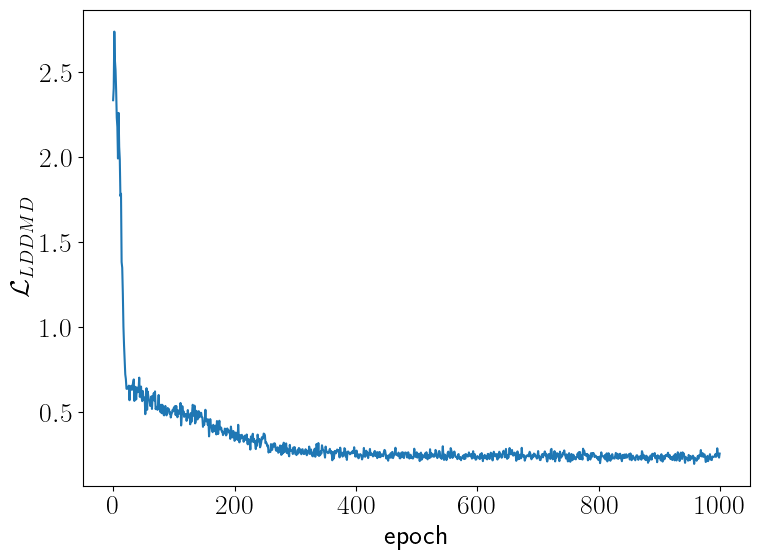

In [12]:
# Plot loss progression
plt.figure(figsize=figsize)
plt.plot(losses)
plt.ylabel(r"$\mathcal{L}_{LDDMD}$")
plt.xlabel("epoch")
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "loss.eps"))
plt.show()

In [13]:
# Validate the model
S_net = dynamics_model.forward(i, x)

p_net = S_net.detach().cpu()
v_net = regression_model(p_net).detach().cpu().squeeze()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


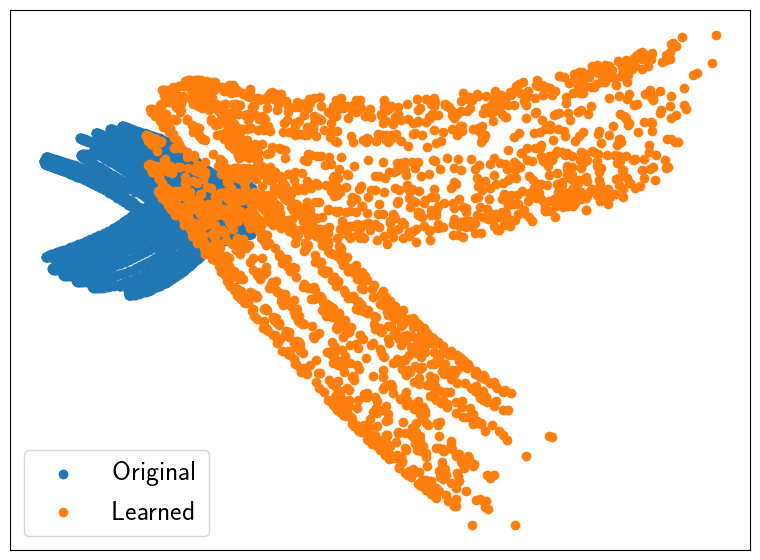

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


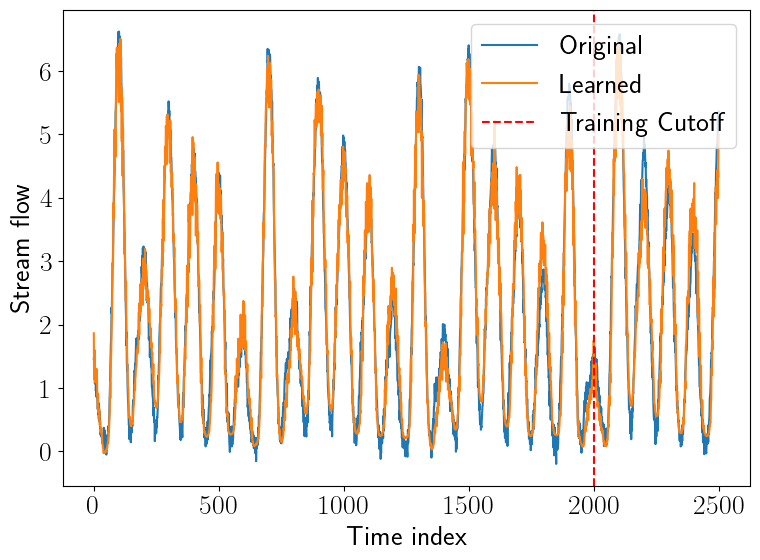

In [14]:
# Plot learned latent dynamics
plt.figure(figsize=figsize)
plt.scatter(p_[:,0], p_[:,1], label='Original')
plt.scatter(p_net[:,0], p_net[:,1], label='Learned')
plt.legend()
plt.xticks([])  # Remove x-axis ticks
plt.yticks([])  # Remove y-axis ticks
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "p_reconstruction.eps"))
plt.show()

# Plot learned signal
plt.figure(figsize=figsize)
plt.plot(i, v, label='Original')
plt.plot(i, v_net, label='Learned')
plt.axvline(x=i_train[-1], color='r', linestyle='--', label='Training Cutoff')
plt.legend(loc='upper right')
plt.xlabel("Time index")
plt.ylabel("Stream flow")
plt.tight_layout()
plt.savefig(os.path.join(results_folder, "v_reconstruction.eps"))
plt.show()


In [15]:
# define NSE metric
def nse(original, predicted):
    
    if original.shape != predicted.shape:
        raise ValueError("Input tensors must have the same shape")
    
    mean_observed = torch.mean(original)
    numerator = torch.sum((original - predicted) ** 2)
    denominator = torch.sum((original - mean_observed) ** 2)

    return 1 - (numerator / denominator)

In [16]:
# Compute NSE metrics
total_nse = nse(v, v_net)

# Training NSE
train_nse = nse(v[:int(i_train[-1].item())+1], v_net[:int(i_train[-1].item())+1])

# Validation NSE
val_nse = nse(v[int(i_train[-1].item())+1:], v_net[int(i_train[-1].item())+1:])

print(f"Total NSE = {total_nse} | NSE on training data = {train_nse} | NSE on validation data = {val_nse}")

Total NSE = 0.9582781195640564 | NSE on training data = 0.9632235169410706 | NSE on validation data = 0.9382321238517761


In [17]:
for name, param in dynamics_model.K.named_parameters():
    if name == "omegas":
        print(f"Parameter values:\n{param.data}\n")

print(freqs)

Parameter values:
tensor([0.0097])

tensor([0.0097])


### Reconstruct using LSTM ###

In [6]:
class TimeSeriesDataset(Dataset):
    def __init__(self, x, v, window_size):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.v = torch.tensor(v, dtype=torch.float32)
        self.window_size = window_size

    def __len__(self):
        return len(self.x) - self.window_size + 1

    def __getitem__(self, idx):
        return (
            self.x[idx:idx+self.window_size],
            self.v[idx+self.window_size-1]
        )

# Create the dataset
window_size = 365
dataset = TimeSeriesDataset(x_train, v_train, window_size)

# Create the DataLoader
batch_size = 256  # Adjust as needed
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

/var/folders/ly/f4m8s6ks3w5cc8_y1dv124bc0000gn/T/ipykernel_5598/116271639.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x, dtype=torch.float32)
/var/folders/ly/f4m8s6ks3w5cc8_y1dv124bc0000gn/T/ipykernel_5598/116271639.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.v = torch.tensor(v, dtype=torch.float32)


In [7]:
class LSTMModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = torch.nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            batch_first=True
        )
        self.linear = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # lstm_out shape: (batch, seq, features)
        last_time_step = lstm_out[:, -1, :]
        return self.linear(last_time_step)

In [8]:
# Initialize the models
data_dim = 2
latent_dim = 2

lstm_model = LSTMModel(input_dim=data_dim, hidden_dim=latent_dim).to(device)

# Create the optimizer
optimizer = optim.Adam(lstm_model.parameters(), lr=1e-3)

In [9]:
def train(lstm_model, train_loader, optimizer, n_epochs):
    device = next(lstm_model.parameters()).device
    criterion = torch.nn.MSELoss()
    
    for epoch in range(n_epochs):
        lstm_model.train()
        total_loss = 0
        
        for batch_x, batch_v in tqdm(train_loader):
            batch_x = batch_x.to(device)
            batch_v = batch_v.to(device)
            
            # Forward pass
            predictions = lstm_model(batch_x)
            
            # Optimization step
            optimizer.zero_grad()
            loss = criterion(predictions, batch_v)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{n_epochs}] | Loss: {total_loss/len(train_loader):.4f}")


In [10]:
# Train the model
n_epochs = 1000
losses = train(lstm_model, train_loader, optimizer, n_epochs)

  0%|          | 0/7 [00:00<?, ?it/s]/Users/wdiepeveen/Documents/Postdoc/projects/3 - Riemannian geometry for data reduction for science/src/Latent-Diffeomorphic-Dynamic-Mode-Decomposition/.venv/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
 71%|███████▏  | 5/7 [00:00<00:00, 12.45it/s]/Users/wdiepeveen/Documents/Postdoc/projects/3 - Riemannian geometry for data reduction for science/src/Latent-Diffeomorphic-Dynamic-Mode-Decomposition/.venv/lib/python3.8/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same

Epoch [1/1000] | Loss: 8.1947


100%|██████████| 7/7 [00:00<00:00, 17.89it/s]


Epoch [2/1000] | Loss: 8.2755


100%|██████████| 7/7 [00:00<00:00, 18.47it/s]


Epoch [3/1000] | Loss: 8.0284


100%|██████████| 7/7 [00:00<00:00, 16.74it/s]


Epoch [4/1000] | Loss: 8.0033


100%|██████████| 7/7 [00:00<00:00, 17.96it/s]


Epoch [5/1000] | Loss: 7.8357


100%|██████████| 7/7 [00:00<00:00, 18.05it/s]


Epoch [6/1000] | Loss: 7.8670


100%|██████████| 7/7 [00:00<00:00, 18.23it/s]


Epoch [7/1000] | Loss: 7.8220


100%|██████████| 7/7 [00:00<00:00, 14.97it/s]


Epoch [8/1000] | Loss: 7.7333


100%|██████████| 7/7 [00:00<00:00, 17.10it/s]


Epoch [9/1000] | Loss: 7.6444


100%|██████████| 7/7 [00:00<00:00, 16.81it/s]


Epoch [10/1000] | Loss: 7.4992


100%|██████████| 7/7 [00:00<00:00, 17.72it/s]


Epoch [11/1000] | Loss: 7.5556


100%|██████████| 7/7 [00:00<00:00, 17.12it/s]


Epoch [12/1000] | Loss: 7.5122


100%|██████████| 7/7 [00:00<00:00, 15.88it/s]


Epoch [13/1000] | Loss: 7.2393


100%|██████████| 7/7 [00:00<00:00, 15.77it/s]


Epoch [14/1000] | Loss: 7.2277


100%|██████████| 7/7 [00:00<00:00, 16.69it/s]


Epoch [15/1000] | Loss: 7.1000


100%|██████████| 7/7 [00:00<00:00, 17.87it/s]


Epoch [16/1000] | Loss: 7.0611


100%|██████████| 7/7 [00:00<00:00, 17.12it/s]


Epoch [17/1000] | Loss: 7.0198


100%|██████████| 7/7 [00:00<00:00, 15.92it/s]


Epoch [18/1000] | Loss: 6.9772


100%|██████████| 7/7 [00:00<00:00, 11.84it/s]


Epoch [19/1000] | Loss: 6.7389


100%|██████████| 7/7 [00:00<00:00, 15.85it/s]


Epoch [20/1000] | Loss: 6.8206


100%|██████████| 7/7 [00:00<00:00, 15.91it/s]


Epoch [21/1000] | Loss: 6.6499


100%|██████████| 7/7 [00:00<00:00, 15.65it/s]


Epoch [22/1000] | Loss: 6.6500


100%|██████████| 7/7 [00:00<00:00, 15.50it/s]


Epoch [23/1000] | Loss: 6.5851


100%|██████████| 7/7 [00:00<00:00, 15.21it/s]


Epoch [24/1000] | Loss: 6.6709


100%|██████████| 7/7 [00:00<00:00, 15.31it/s]


Epoch [25/1000] | Loss: 6.4057


100%|██████████| 7/7 [00:00<00:00, 15.59it/s]


Epoch [26/1000] | Loss: 6.4834


100%|██████████| 7/7 [00:00<00:00, 15.25it/s]


Epoch [27/1000] | Loss: 6.2740


100%|██████████| 7/7 [00:00<00:00, 15.21it/s]


Epoch [28/1000] | Loss: 6.3413


100%|██████████| 7/7 [00:00<00:00, 12.31it/s]


Epoch [29/1000] | Loss: 6.1915


100%|██████████| 7/7 [00:00<00:00, 13.15it/s]


Epoch [30/1000] | Loss: 6.0821


100%|██████████| 7/7 [00:00<00:00, 15.74it/s]


Epoch [31/1000] | Loss: 6.1282


100%|██████████| 7/7 [00:00<00:00, 16.97it/s]


Epoch [32/1000] | Loss: 6.2122


100%|██████████| 7/7 [00:00<00:00, 17.61it/s]


Epoch [33/1000] | Loss: 6.1012


100%|██████████| 7/7 [00:00<00:00, 17.98it/s]


Epoch [34/1000] | Loss: 6.1008


100%|██████████| 7/7 [00:00<00:00, 17.91it/s]


Epoch [35/1000] | Loss: 5.9472


100%|██████████| 7/7 [00:00<00:00, 14.67it/s]


Epoch [36/1000] | Loss: 5.8433


100%|██████████| 7/7 [00:00<00:00, 16.35it/s]


Epoch [37/1000] | Loss: 5.9205


100%|██████████| 7/7 [00:00<00:00, 17.96it/s]


Epoch [38/1000] | Loss: 5.8071


100%|██████████| 7/7 [00:00<00:00, 17.95it/s]


Epoch [39/1000] | Loss: 5.6855


100%|██████████| 7/7 [00:00<00:00, 18.68it/s]


Epoch [40/1000] | Loss: 5.8346


100%|██████████| 7/7 [00:00<00:00, 18.82it/s]


Epoch [41/1000] | Loss: 5.7147


100%|██████████| 7/7 [00:00<00:00, 17.22it/s]


Epoch [42/1000] | Loss: 5.7193


100%|██████████| 7/7 [00:00<00:00, 16.16it/s]


Epoch [43/1000] | Loss: 5.6052


100%|██████████| 7/7 [00:00<00:00, 18.24it/s]


Epoch [44/1000] | Loss: 5.5447


100%|██████████| 7/7 [00:00<00:00, 19.98it/s]


Epoch [45/1000] | Loss: 5.6048


100%|██████████| 7/7 [00:00<00:00, 20.39it/s]


Epoch [46/1000] | Loss: 5.4424


100%|██████████| 7/7 [00:00<00:00, 20.05it/s]


Epoch [47/1000] | Loss: 5.5098


100%|██████████| 7/7 [00:00<00:00, 20.47it/s]


Epoch [48/1000] | Loss: 5.5384


100%|██████████| 7/7 [00:00<00:00, 20.85it/s]


Epoch [49/1000] | Loss: 5.3327


100%|██████████| 7/7 [00:00<00:00, 20.71it/s]


Epoch [50/1000] | Loss: 5.4099


100%|██████████| 7/7 [00:00<00:00, 20.93it/s]


Epoch [51/1000] | Loss: 5.3031


100%|██████████| 7/7 [00:00<00:00, 21.02it/s]


Epoch [52/1000] | Loss: 5.3986


100%|██████████| 7/7 [00:00<00:00, 17.98it/s]


Epoch [53/1000] | Loss: 5.3291


100%|██████████| 7/7 [00:00<00:00, 21.05it/s]


Epoch [54/1000] | Loss: 5.3463


100%|██████████| 7/7 [00:00<00:00, 21.61it/s]


Epoch [55/1000] | Loss: 5.0868


100%|██████████| 7/7 [00:00<00:00, 21.69it/s]


Epoch [56/1000] | Loss: 5.1539


100%|██████████| 7/7 [00:00<00:00, 21.83it/s]


Epoch [57/1000] | Loss: 5.2148


100%|██████████| 7/7 [00:00<00:00, 21.68it/s]


Epoch [58/1000] | Loss: 5.0757


100%|██████████| 7/7 [00:00<00:00, 18.64it/s]


Epoch [59/1000] | Loss: 4.9578


100%|██████████| 7/7 [00:00<00:00, 17.45it/s]


Epoch [60/1000] | Loss: 5.0677


100%|██████████| 7/7 [00:00<00:00, 20.53it/s]


Epoch [61/1000] | Loss: 4.9364


100%|██████████| 7/7 [00:00<00:00, 22.42it/s]


Epoch [62/1000] | Loss: 4.8345


100%|██████████| 7/7 [00:00<00:00, 22.34it/s]


Epoch [63/1000] | Loss: 4.7932


100%|██████████| 7/7 [00:00<00:00, 22.20it/s]


Epoch [64/1000] | Loss: 4.8369


100%|██████████| 7/7 [00:00<00:00, 22.38it/s]


Epoch [65/1000] | Loss: 4.8331


100%|██████████| 7/7 [00:00<00:00, 22.66it/s]


Epoch [66/1000] | Loss: 4.6906


100%|██████████| 7/7 [00:00<00:00, 22.19it/s]


Epoch [67/1000] | Loss: 4.6320


100%|██████████| 7/7 [00:00<00:00, 21.63it/s]


Epoch [68/1000] | Loss: 4.5499


100%|██████████| 7/7 [00:00<00:00, 21.55it/s]


Epoch [69/1000] | Loss: 4.5741


100%|██████████| 7/7 [00:00<00:00, 20.63it/s]


Epoch [70/1000] | Loss: 4.5351


100%|██████████| 7/7 [00:00<00:00, 20.84it/s]


Epoch [71/1000] | Loss: 4.4802


100%|██████████| 7/7 [00:00<00:00, 21.08it/s]


Epoch [72/1000] | Loss: 4.3493


100%|██████████| 7/7 [00:00<00:00, 17.01it/s]


Epoch [73/1000] | Loss: 4.3419


100%|██████████| 7/7 [00:00<00:00, 18.61it/s]


Epoch [74/1000] | Loss: 4.3012


100%|██████████| 7/7 [00:00<00:00, 16.66it/s]


Epoch [75/1000] | Loss: 4.3074


100%|██████████| 7/7 [00:00<00:00, 16.15it/s]


Epoch [76/1000] | Loss: 4.1539


100%|██████████| 7/7 [00:00<00:00, 12.20it/s]


Epoch [77/1000] | Loss: 4.0667


100%|██████████| 7/7 [00:00<00:00, 16.35it/s]


Epoch [78/1000] | Loss: 4.0402


100%|██████████| 7/7 [00:00<00:00, 18.30it/s]


Epoch [79/1000] | Loss: 3.9539


100%|██████████| 7/7 [00:00<00:00, 19.14it/s]


Epoch [80/1000] | Loss: 3.8087


100%|██████████| 7/7 [00:00<00:00, 20.79it/s]


Epoch [81/1000] | Loss: 3.8542


100%|██████████| 7/7 [00:00<00:00, 22.65it/s]


Epoch [82/1000] | Loss: 3.7911


100%|██████████| 7/7 [00:00<00:00, 23.58it/s]


Epoch [83/1000] | Loss: 3.6136


100%|██████████| 7/7 [00:00<00:00, 25.88it/s]


Epoch [84/1000] | Loss: 3.6715


100%|██████████| 7/7 [00:00<00:00, 28.62it/s]


Epoch [85/1000] | Loss: 3.6137


100%|██████████| 7/7 [00:00<00:00, 30.60it/s]


Epoch [86/1000] | Loss: 3.4657


100%|██████████| 7/7 [00:00<00:00, 31.62it/s]


Epoch [87/1000] | Loss: 3.5076


100%|██████████| 7/7 [00:00<00:00, 33.59it/s]


Epoch [88/1000] | Loss: 3.5918


100%|██████████| 7/7 [00:00<00:00, 35.10it/s]


Epoch [89/1000] | Loss: 3.5105


100%|██████████| 7/7 [00:00<00:00, 34.55it/s]


Epoch [90/1000] | Loss: 3.3797


100%|██████████| 7/7 [00:00<00:00, 35.41it/s]


Epoch [91/1000] | Loss: 3.4495


100%|██████████| 7/7 [00:00<00:00, 24.40it/s]


Epoch [92/1000] | Loss: 3.3864


100%|██████████| 7/7 [00:00<00:00, 23.31it/s]


Epoch [93/1000] | Loss: 3.3269


100%|██████████| 7/7 [00:00<00:00, 35.99it/s]


Epoch [94/1000] | Loss: 3.3603


100%|██████████| 7/7 [00:00<00:00, 36.33it/s]


Epoch [95/1000] | Loss: 3.4214


100%|██████████| 7/7 [00:00<00:00, 36.25it/s]


Epoch [96/1000] | Loss: 3.3382


100%|██████████| 7/7 [00:00<00:00, 35.86it/s]


Epoch [97/1000] | Loss: 3.2553


100%|██████████| 7/7 [00:00<00:00, 36.15it/s]


Epoch [98/1000] | Loss: 3.3672


100%|██████████| 7/7 [00:00<00:00, 36.53it/s]


Epoch [99/1000] | Loss: 3.3151


100%|██████████| 7/7 [00:00<00:00, 36.54it/s]


Epoch [100/1000] | Loss: 3.2217


100%|██████████| 7/7 [00:00<00:00, 34.68it/s]


Epoch [101/1000] | Loss: 3.2411


100%|██████████| 7/7 [00:00<00:00, 34.66it/s]


Epoch [102/1000] | Loss: 3.2992


100%|██████████| 7/7 [00:00<00:00, 36.22it/s]


Epoch [103/1000] | Loss: 3.3156


100%|██████████| 7/7 [00:00<00:00, 36.98it/s]


Epoch [104/1000] | Loss: 3.2776


100%|██████████| 7/7 [00:00<00:00, 36.31it/s]


Epoch [105/1000] | Loss: 3.2206


100%|██████████| 7/7 [00:00<00:00, 36.48it/s]


Epoch [106/1000] | Loss: 3.2235


100%|██████████| 7/7 [00:00<00:00, 35.77it/s]


Epoch [107/1000] | Loss: 3.1809


100%|██████████| 7/7 [00:00<00:00, 34.09it/s]


Epoch [108/1000] | Loss: 3.2574


100%|██████████| 7/7 [00:00<00:00, 36.18it/s]


Epoch [109/1000] | Loss: 3.2972


100%|██████████| 7/7 [00:00<00:00, 31.46it/s]


Epoch [110/1000] | Loss: 3.1991


100%|██████████| 7/7 [00:00<00:00, 31.20it/s]


Epoch [111/1000] | Loss: 3.2048


100%|██████████| 7/7 [00:00<00:00, 33.54it/s]


Epoch [112/1000] | Loss: 3.1200


100%|██████████| 7/7 [00:00<00:00, 24.05it/s]


Epoch [113/1000] | Loss: 3.1852


100%|██████████| 7/7 [00:00<00:00, 30.99it/s]


Epoch [114/1000] | Loss: 3.1935


100%|██████████| 7/7 [00:00<00:00, 30.27it/s]


Epoch [115/1000] | Loss: 3.2240


100%|██████████| 7/7 [00:00<00:00, 34.18it/s]


Epoch [116/1000] | Loss: 3.1749


100%|██████████| 7/7 [00:00<00:00, 33.16it/s]


Epoch [117/1000] | Loss: 3.2254


100%|██████████| 7/7 [00:00<00:00, 27.09it/s]


Epoch [118/1000] | Loss: 3.1166


100%|██████████| 7/7 [00:00<00:00, 31.51it/s]


Epoch [119/1000] | Loss: 3.1382


100%|██████████| 7/7 [00:00<00:00, 34.27it/s]


Epoch [120/1000] | Loss: 3.0796


100%|██████████| 7/7 [00:00<00:00, 28.88it/s]


Epoch [121/1000] | Loss: 3.1132


100%|██████████| 7/7 [00:00<00:00, 30.21it/s]


Epoch [122/1000] | Loss: 3.0979


100%|██████████| 7/7 [00:00<00:00, 34.37it/s]


Epoch [123/1000] | Loss: 3.1115


100%|██████████| 7/7 [00:00<00:00, 34.69it/s]


Epoch [124/1000] | Loss: 3.0772


100%|██████████| 7/7 [00:00<00:00, 37.09it/s]


Epoch [125/1000] | Loss: 3.1409


100%|██████████| 7/7 [00:00<00:00, 35.73it/s]


Epoch [126/1000] | Loss: 3.0396


100%|██████████| 7/7 [00:00<00:00, 36.88it/s]


Epoch [127/1000] | Loss: 3.1113


100%|██████████| 7/7 [00:00<00:00, 36.10it/s]


Epoch [128/1000] | Loss: 3.1052


100%|██████████| 7/7 [00:00<00:00, 33.21it/s]


Epoch [129/1000] | Loss: 3.0481


100%|██████████| 7/7 [00:00<00:00, 29.33it/s]


Epoch [130/1000] | Loss: 3.0542


100%|██████████| 7/7 [00:00<00:00, 36.15it/s]


Epoch [131/1000] | Loss: 3.0678


100%|██████████| 7/7 [00:00<00:00, 34.94it/s]


Epoch [132/1000] | Loss: 3.0516


100%|██████████| 7/7 [00:00<00:00, 28.62it/s]


Epoch [133/1000] | Loss: 3.0602


100%|██████████| 7/7 [00:00<00:00, 36.92it/s]


Epoch [134/1000] | Loss: 3.0169


100%|██████████| 7/7 [00:00<00:00, 36.25it/s]


Epoch [135/1000] | Loss: 3.1058


100%|██████████| 7/7 [00:00<00:00, 36.05it/s]


Epoch [136/1000] | Loss: 3.0053


100%|██████████| 7/7 [00:00<00:00, 33.92it/s]


Epoch [137/1000] | Loss: 3.0827


100%|██████████| 7/7 [00:00<00:00, 35.94it/s]


Epoch [138/1000] | Loss: 3.0495


100%|██████████| 7/7 [00:00<00:00, 35.46it/s]


Epoch [139/1000] | Loss: 3.0759


100%|██████████| 7/7 [00:00<00:00, 36.26it/s]


Epoch [140/1000] | Loss: 3.0210


100%|██████████| 7/7 [00:00<00:00, 36.08it/s]


Epoch [141/1000] | Loss: 3.0301


100%|██████████| 7/7 [00:00<00:00, 36.22it/s]


Epoch [142/1000] | Loss: 3.0290


100%|██████████| 7/7 [00:00<00:00, 32.99it/s]


Epoch [143/1000] | Loss: 3.0174


100%|██████████| 7/7 [00:00<00:00, 28.12it/s]


Epoch [144/1000] | Loss: 3.0371


100%|██████████| 7/7 [00:00<00:00, 33.81it/s]


Epoch [145/1000] | Loss: 2.9894


100%|██████████| 7/7 [00:00<00:00, 32.05it/s]


Epoch [146/1000] | Loss: 2.9750


100%|██████████| 7/7 [00:00<00:00, 34.81it/s]


Epoch [147/1000] | Loss: 2.9701


100%|██████████| 7/7 [00:00<00:00, 37.96it/s]


Epoch [148/1000] | Loss: 3.0436


100%|██████████| 7/7 [00:00<00:00, 37.60it/s]


Epoch [149/1000] | Loss: 2.9993


100%|██████████| 7/7 [00:00<00:00, 35.56it/s]


Epoch [150/1000] | Loss: 3.0350


100%|██████████| 7/7 [00:00<00:00, 35.86it/s]


Epoch [151/1000] | Loss: 3.0194


100%|██████████| 7/7 [00:00<00:00, 36.01it/s]


Epoch [152/1000] | Loss: 2.9090


100%|██████████| 7/7 [00:00<00:00, 35.70it/s]


Epoch [153/1000] | Loss: 2.9306


100%|██████████| 7/7 [00:00<00:00, 35.24it/s]


Epoch [154/1000] | Loss: 2.9510


100%|██████████| 7/7 [00:00<00:00, 30.01it/s]


Epoch [155/1000] | Loss: 2.9919


100%|██████████| 7/7 [00:00<00:00, 34.35it/s]


Epoch [156/1000] | Loss: 2.9698


100%|██████████| 7/7 [00:00<00:00, 37.45it/s]


Epoch [157/1000] | Loss: 2.9987


100%|██████████| 7/7 [00:00<00:00, 33.93it/s]


Epoch [158/1000] | Loss: 3.0124


100%|██████████| 7/7 [00:00<00:00, 30.05it/s]


Epoch [159/1000] | Loss: 2.9987


100%|██████████| 7/7 [00:00<00:00, 29.65it/s]


Epoch [160/1000] | Loss: 2.9185


100%|██████████| 7/7 [00:00<00:00, 34.87it/s]


Epoch [161/1000] | Loss: 2.9602


100%|██████████| 7/7 [00:00<00:00, 37.26it/s]


Epoch [162/1000] | Loss: 2.9562


100%|██████████| 7/7 [00:00<00:00, 35.66it/s]


Epoch [163/1000] | Loss: 3.0176


100%|██████████| 7/7 [00:00<00:00, 33.07it/s]


Epoch [164/1000] | Loss: 2.9331


100%|██████████| 7/7 [00:00<00:00, 30.19it/s]


Epoch [165/1000] | Loss: 2.9302


100%|██████████| 7/7 [00:00<00:00, 36.64it/s]


Epoch [166/1000] | Loss: 2.9655


100%|██████████| 7/7 [00:00<00:00, 28.39it/s]


Epoch [167/1000] | Loss: 2.9433


100%|██████████| 7/7 [00:00<00:00, 32.12it/s]


Epoch [168/1000] | Loss: 2.9388


100%|██████████| 7/7 [00:00<00:00, 34.98it/s]


Epoch [169/1000] | Loss: 2.9454


100%|██████████| 7/7 [00:00<00:00, 35.61it/s]


Epoch [170/1000] | Loss: 2.9531


100%|██████████| 7/7 [00:00<00:00, 35.25it/s]


Epoch [171/1000] | Loss: 2.9351


100%|██████████| 7/7 [00:00<00:00, 34.67it/s]


Epoch [172/1000] | Loss: 2.9655


100%|██████████| 7/7 [00:00<00:00, 35.51it/s]


Epoch [173/1000] | Loss: 2.9631


100%|██████████| 7/7 [00:00<00:00, 36.23it/s]


Epoch [174/1000] | Loss: 2.9607


100%|██████████| 7/7 [00:00<00:00, 37.37it/s]


Epoch [175/1000] | Loss: 2.9377


100%|██████████| 7/7 [00:00<00:00, 38.82it/s]


Epoch [176/1000] | Loss: 2.8849


100%|██████████| 7/7 [00:00<00:00, 37.88it/s]


Epoch [177/1000] | Loss: 2.8953


100%|██████████| 7/7 [00:00<00:00, 39.23it/s]


Epoch [178/1000] | Loss: 2.8973


100%|██████████| 7/7 [00:00<00:00, 39.02it/s]


Epoch [179/1000] | Loss: 2.9579


100%|██████████| 7/7 [00:00<00:00, 38.41it/s]


Epoch [180/1000] | Loss: 2.9181


100%|██████████| 7/7 [00:00<00:00, 38.66it/s]


Epoch [181/1000] | Loss: 2.9005


100%|██████████| 7/7 [00:00<00:00, 37.92it/s]


Epoch [182/1000] | Loss: 2.9736


100%|██████████| 7/7 [00:00<00:00, 38.52it/s]


Epoch [183/1000] | Loss: 2.8854


100%|██████████| 7/7 [00:00<00:00, 37.06it/s]


Epoch [184/1000] | Loss: 2.9844


100%|██████████| 7/7 [00:00<00:00, 35.97it/s]


Epoch [185/1000] | Loss: 2.9212


100%|██████████| 7/7 [00:00<00:00, 38.20it/s]


Epoch [186/1000] | Loss: 2.9131


100%|██████████| 7/7 [00:00<00:00, 36.02it/s]


Epoch [187/1000] | Loss: 2.9102


100%|██████████| 7/7 [00:00<00:00, 36.63it/s]


Epoch [188/1000] | Loss: 2.9475


100%|██████████| 7/7 [00:00<00:00, 35.31it/s]


Epoch [189/1000] | Loss: 2.9479


100%|██████████| 7/7 [00:00<00:00, 36.52it/s]


Epoch [190/1000] | Loss: 2.8668


100%|██████████| 7/7 [00:00<00:00, 36.31it/s]


Epoch [191/1000] | Loss: 2.9823


100%|██████████| 7/7 [00:00<00:00, 35.52it/s]


Epoch [192/1000] | Loss: 2.9253


100%|██████████| 7/7 [00:00<00:00, 36.79it/s]


Epoch [193/1000] | Loss: 2.9353


100%|██████████| 7/7 [00:00<00:00, 37.66it/s]


Epoch [194/1000] | Loss: 2.9181


100%|██████████| 7/7 [00:00<00:00, 37.62it/s]


Epoch [195/1000] | Loss: 2.8982


100%|██████████| 7/7 [00:00<00:00, 37.31it/s]


Epoch [196/1000] | Loss: 2.8930


100%|██████████| 7/7 [00:00<00:00, 36.83it/s]


Epoch [197/1000] | Loss: 2.8701


100%|██████████| 7/7 [00:00<00:00, 37.10it/s]


Epoch [198/1000] | Loss: 2.8794


100%|██████████| 7/7 [00:00<00:00, 36.59it/s]


Epoch [199/1000] | Loss: 2.8428


100%|██████████| 7/7 [00:00<00:00, 36.84it/s]


Epoch [200/1000] | Loss: 2.8787


100%|██████████| 7/7 [00:00<00:00, 35.47it/s]


Epoch [201/1000] | Loss: 2.8960


100%|██████████| 7/7 [00:00<00:00, 36.77it/s]


Epoch [202/1000] | Loss: 2.8683


100%|██████████| 7/7 [00:00<00:00, 36.71it/s]


Epoch [203/1000] | Loss: 2.8746


100%|██████████| 7/7 [00:00<00:00, 34.78it/s]


Epoch [204/1000] | Loss: 2.8550


100%|██████████| 7/7 [00:00<00:00, 33.96it/s]


Epoch [205/1000] | Loss: 2.8927


100%|██████████| 7/7 [00:00<00:00, 38.33it/s]


Epoch [206/1000] | Loss: 2.8617


100%|██████████| 7/7 [00:00<00:00, 35.90it/s]


Epoch [207/1000] | Loss: 2.8785


100%|██████████| 7/7 [00:00<00:00, 36.29it/s]


Epoch [208/1000] | Loss: 2.9430


100%|██████████| 7/7 [00:00<00:00, 38.03it/s]


Epoch [209/1000] | Loss: 2.8374


100%|██████████| 7/7 [00:00<00:00, 38.61it/s]


Epoch [210/1000] | Loss: 2.8897


100%|██████████| 7/7 [00:00<00:00, 37.95it/s]


Epoch [211/1000] | Loss: 2.8383


100%|██████████| 7/7 [00:00<00:00, 36.53it/s]


Epoch [212/1000] | Loss: 2.8439


100%|██████████| 7/7 [00:00<00:00, 37.07it/s]


Epoch [213/1000] | Loss: 2.8808


100%|██████████| 7/7 [00:00<00:00, 36.95it/s]


Epoch [214/1000] | Loss: 2.8843


100%|██████████| 7/7 [00:00<00:00, 36.89it/s]


Epoch [215/1000] | Loss: 2.8711


100%|██████████| 7/7 [00:00<00:00, 37.92it/s]


Epoch [216/1000] | Loss: 2.9039


100%|██████████| 7/7 [00:00<00:00, 37.97it/s]


Epoch [217/1000] | Loss: 2.9192


100%|██████████| 7/7 [00:00<00:00, 38.73it/s]


Epoch [218/1000] | Loss: 2.9016


100%|██████████| 7/7 [00:00<00:00, 38.80it/s]


Epoch [219/1000] | Loss: 2.8719


100%|██████████| 7/7 [00:00<00:00, 37.42it/s]


Epoch [220/1000] | Loss: 2.8604


100%|██████████| 7/7 [00:00<00:00, 37.71it/s]


Epoch [221/1000] | Loss: 2.8555


100%|██████████| 7/7 [00:00<00:00, 37.51it/s]


Epoch [222/1000] | Loss: 2.8666


100%|██████████| 7/7 [00:00<00:00, 38.39it/s]


Epoch [223/1000] | Loss: 2.8502


100%|██████████| 7/7 [00:00<00:00, 38.88it/s]


Epoch [224/1000] | Loss: 2.8443


100%|██████████| 7/7 [00:00<00:00, 38.44it/s]


Epoch [225/1000] | Loss: 2.8754


100%|██████████| 7/7 [00:00<00:00, 27.41it/s]


Epoch [226/1000] | Loss: 2.8785


100%|██████████| 7/7 [00:00<00:00, 37.85it/s]


Epoch [227/1000] | Loss: 2.8789


100%|██████████| 7/7 [00:00<00:00, 35.49it/s]


Epoch [228/1000] | Loss: 2.8529


100%|██████████| 7/7 [00:00<00:00, 28.70it/s]


Epoch [229/1000] | Loss: 2.8514


100%|██████████| 7/7 [00:00<00:00, 30.00it/s]


Epoch [230/1000] | Loss: 2.8137


100%|██████████| 7/7 [00:00<00:00, 27.81it/s]


Epoch [231/1000] | Loss: 2.9430


100%|██████████| 7/7 [00:00<00:00, 34.07it/s]


Epoch [232/1000] | Loss: 2.8820


100%|██████████| 7/7 [00:00<00:00, 37.46it/s]


Epoch [233/1000] | Loss: 2.8383


100%|██████████| 7/7 [00:00<00:00, 38.10it/s]


Epoch [234/1000] | Loss: 2.8889


100%|██████████| 7/7 [00:00<00:00, 38.88it/s]


Epoch [235/1000] | Loss: 2.9090


100%|██████████| 7/7 [00:00<00:00, 39.21it/s]


Epoch [236/1000] | Loss: 2.8714


100%|██████████| 7/7 [00:00<00:00, 38.21it/s]


Epoch [237/1000] | Loss: 2.8345


100%|██████████| 7/7 [00:00<00:00, 36.98it/s]


Epoch [238/1000] | Loss: 2.8401


100%|██████████| 7/7 [00:00<00:00, 37.08it/s]


Epoch [239/1000] | Loss: 2.8495


100%|██████████| 7/7 [00:00<00:00, 39.02it/s]


Epoch [240/1000] | Loss: 2.8033


100%|██████████| 7/7 [00:00<00:00, 21.87it/s]


Epoch [241/1000] | Loss: 2.8713


100%|██████████| 7/7 [00:00<00:00, 35.50it/s]


Epoch [242/1000] | Loss: 2.8548


100%|██████████| 7/7 [00:00<00:00, 34.82it/s]


Epoch [243/1000] | Loss: 2.8815


100%|██████████| 7/7 [00:00<00:00, 19.40it/s]


Epoch [244/1000] | Loss: 2.8417


100%|██████████| 7/7 [00:00<00:00, 35.91it/s]


Epoch [245/1000] | Loss: 2.8950


100%|██████████| 7/7 [00:00<00:00, 36.76it/s]


Epoch [246/1000] | Loss: 2.8773


100%|██████████| 7/7 [00:00<00:00, 33.92it/s]


Epoch [247/1000] | Loss: 2.8456


100%|██████████| 7/7 [00:00<00:00, 37.73it/s]


Epoch [248/1000] | Loss: 2.8597


100%|██████████| 7/7 [00:00<00:00, 34.20it/s]


Epoch [249/1000] | Loss: 2.8457


100%|██████████| 7/7 [00:00<00:00, 36.27it/s]


Epoch [250/1000] | Loss: 2.8275


100%|██████████| 7/7 [00:00<00:00, 33.13it/s]


Epoch [251/1000] | Loss: 2.8208


100%|██████████| 7/7 [00:00<00:00, 26.07it/s]


Epoch [252/1000] | Loss: 2.8913


100%|██████████| 7/7 [00:00<00:00, 30.54it/s]


Epoch [253/1000] | Loss: 2.8502


100%|██████████| 7/7 [00:00<00:00, 34.78it/s]


Epoch [254/1000] | Loss: 2.8046


100%|██████████| 7/7 [00:00<00:00, 36.58it/s]


Epoch [255/1000] | Loss: 2.8936


100%|██████████| 7/7 [00:00<00:00, 35.54it/s]


Epoch [256/1000] | Loss: 2.8137


100%|██████████| 7/7 [00:00<00:00, 36.04it/s]


Epoch [257/1000] | Loss: 2.8257


100%|██████████| 7/7 [00:00<00:00, 35.67it/s]


Epoch [258/1000] | Loss: 2.8036


100%|██████████| 7/7 [00:00<00:00, 35.72it/s]


Epoch [259/1000] | Loss: 2.8627


100%|██████████| 7/7 [00:00<00:00, 36.32it/s]


Epoch [260/1000] | Loss: 2.7918


100%|██████████| 7/7 [00:00<00:00, 28.66it/s]


Epoch [261/1000] | Loss: 2.8562


100%|██████████| 7/7 [00:00<00:00, 24.32it/s]


Epoch [262/1000] | Loss: 2.8470


100%|██████████| 7/7 [00:00<00:00, 24.76it/s]


Epoch [263/1000] | Loss: 2.8700


100%|██████████| 7/7 [00:00<00:00, 26.81it/s]


Epoch [264/1000] | Loss: 2.8244


100%|██████████| 7/7 [00:00<00:00, 32.54it/s]


Epoch [265/1000] | Loss: 2.8600


100%|██████████| 7/7 [00:00<00:00, 32.61it/s]


Epoch [266/1000] | Loss: 2.8827


100%|██████████| 7/7 [00:00<00:00, 24.87it/s]


Epoch [267/1000] | Loss: 2.8540


100%|██████████| 7/7 [00:00<00:00, 26.89it/s]


Epoch [268/1000] | Loss: 2.8975


100%|██████████| 7/7 [00:00<00:00, 17.35it/s]


Epoch [269/1000] | Loss: 2.8372


100%|██████████| 7/7 [00:00<00:00, 17.53it/s]


Epoch [270/1000] | Loss: 2.8751


100%|██████████| 7/7 [00:00<00:00, 28.02it/s]


Epoch [271/1000] | Loss: 2.8972


100%|██████████| 7/7 [00:00<00:00, 17.50it/s]


Epoch [272/1000] | Loss: 2.8058


100%|██████████| 7/7 [00:00<00:00, 17.09it/s]


Epoch [273/1000] | Loss: 2.7832


100%|██████████| 7/7 [00:00<00:00, 30.88it/s]


Epoch [274/1000] | Loss: 2.9221


100%|██████████| 7/7 [00:00<00:00, 20.26it/s]


Epoch [275/1000] | Loss: 2.8261


100%|██████████| 7/7 [00:00<00:00, 25.45it/s]


Epoch [276/1000] | Loss: 2.8607


100%|██████████| 7/7 [00:00<00:00, 33.27it/s]


Epoch [277/1000] | Loss: 2.8518


100%|██████████| 7/7 [00:00<00:00, 29.11it/s]


Epoch [278/1000] | Loss: 2.8682


100%|██████████| 7/7 [00:00<00:00, 26.15it/s]


Epoch [279/1000] | Loss: 2.7947


100%|██████████| 7/7 [00:00<00:00, 28.74it/s]


Epoch [280/1000] | Loss: 2.8593


100%|██████████| 7/7 [00:00<00:00, 31.44it/s]


Epoch [281/1000] | Loss: 2.8243


100%|██████████| 7/7 [00:00<00:00, 37.84it/s]


Epoch [282/1000] | Loss: 2.8537


100%|██████████| 7/7 [00:00<00:00, 38.11it/s]


Epoch [283/1000] | Loss: 2.7971


100%|██████████| 7/7 [00:00<00:00, 38.40it/s]


Epoch [284/1000] | Loss: 2.8305


100%|██████████| 7/7 [00:00<00:00, 37.75it/s]


Epoch [285/1000] | Loss: 2.8262


100%|██████████| 7/7 [00:00<00:00, 32.49it/s]


Epoch [286/1000] | Loss: 2.8313


100%|██████████| 7/7 [00:00<00:00, 38.24it/s]


Epoch [287/1000] | Loss: 2.8638


100%|██████████| 7/7 [00:00<00:00, 38.79it/s]


Epoch [288/1000] | Loss: 2.8576


100%|██████████| 7/7 [00:00<00:00, 34.91it/s]


Epoch [289/1000] | Loss: 2.7834


100%|██████████| 7/7 [00:00<00:00, 37.88it/s]


Epoch [290/1000] | Loss: 2.8730


100%|██████████| 7/7 [00:00<00:00, 39.13it/s]


Epoch [291/1000] | Loss: 2.8577


100%|██████████| 7/7 [00:00<00:00, 39.03it/s]


Epoch [292/1000] | Loss: 2.8816


100%|██████████| 7/7 [00:00<00:00, 38.38it/s]


Epoch [293/1000] | Loss: 2.8497


100%|██████████| 7/7 [00:00<00:00, 38.01it/s]


Epoch [294/1000] | Loss: 2.8789


100%|██████████| 7/7 [00:00<00:00, 38.11it/s]


Epoch [295/1000] | Loss: 2.8235


100%|██████████| 7/7 [00:00<00:00, 39.04it/s]


Epoch [296/1000] | Loss: 2.8854


100%|██████████| 7/7 [00:00<00:00, 38.99it/s]


Epoch [297/1000] | Loss: 2.8677


100%|██████████| 7/7 [00:00<00:00, 39.14it/s]


Epoch [298/1000] | Loss: 2.8543


100%|██████████| 7/7 [00:00<00:00, 38.65it/s]


Epoch [299/1000] | Loss: 2.8179


100%|██████████| 7/7 [00:00<00:00, 38.67it/s]


Epoch [300/1000] | Loss: 2.8713


100%|██████████| 7/7 [00:00<00:00, 38.62it/s]


Epoch [301/1000] | Loss: 2.8418


100%|██████████| 7/7 [00:00<00:00, 37.19it/s]


Epoch [302/1000] | Loss: 2.8980


100%|██████████| 7/7 [00:00<00:00, 37.84it/s]


Epoch [303/1000] | Loss: 2.9082


100%|██████████| 7/7 [00:00<00:00, 29.82it/s]


Epoch [304/1000] | Loss: 2.8704


100%|██████████| 7/7 [00:00<00:00, 32.26it/s]


Epoch [305/1000] | Loss: 2.8516


100%|██████████| 7/7 [00:00<00:00, 34.36it/s]


Epoch [306/1000] | Loss: 2.8686


100%|██████████| 7/7 [00:00<00:00, 20.59it/s]


Epoch [307/1000] | Loss: 2.8437


100%|██████████| 7/7 [00:00<00:00, 33.78it/s]


Epoch [308/1000] | Loss: 2.8748


100%|██████████| 7/7 [00:00<00:00, 35.86it/s]


Epoch [309/1000] | Loss: 2.8390


100%|██████████| 7/7 [00:00<00:00, 29.35it/s]


Epoch [310/1000] | Loss: 2.8568


100%|██████████| 7/7 [00:00<00:00, 36.06it/s]


Epoch [311/1000] | Loss: 2.8375


100%|██████████| 7/7 [00:00<00:00, 38.88it/s]


Epoch [312/1000] | Loss: 2.8317


100%|██████████| 7/7 [00:00<00:00, 38.69it/s]


Epoch [313/1000] | Loss: 2.8838


100%|██████████| 7/7 [00:00<00:00, 38.25it/s]


Epoch [314/1000] | Loss: 2.8351


100%|██████████| 7/7 [00:00<00:00, 38.58it/s]


Epoch [315/1000] | Loss: 2.8674


100%|██████████| 7/7 [00:00<00:00, 39.05it/s]


Epoch [316/1000] | Loss: 2.8478


100%|██████████| 7/7 [00:00<00:00, 38.37it/s]


Epoch [317/1000] | Loss: 2.9025


100%|██████████| 7/7 [00:00<00:00, 39.34it/s]


Epoch [318/1000] | Loss: 2.8890


100%|██████████| 7/7 [00:00<00:00, 38.36it/s]


Epoch [319/1000] | Loss: 2.8101


100%|██████████| 7/7 [00:00<00:00, 38.95it/s]


Epoch [320/1000] | Loss: 2.8313


100%|██████████| 7/7 [00:00<00:00, 39.48it/s]


Epoch [321/1000] | Loss: 2.8362


100%|██████████| 7/7 [00:00<00:00, 38.21it/s]


Epoch [322/1000] | Loss: 2.8432


100%|██████████| 7/7 [00:00<00:00, 38.25it/s]


Epoch [323/1000] | Loss: 2.8019


100%|██████████| 7/7 [00:00<00:00, 32.75it/s]


Epoch [324/1000] | Loss: 2.8577


100%|██████████| 7/7 [00:00<00:00, 34.40it/s]


Epoch [325/1000] | Loss: 2.8522


100%|██████████| 7/7 [00:00<00:00, 34.83it/s]


Epoch [326/1000] | Loss: 2.7986


100%|██████████| 7/7 [00:00<00:00, 28.10it/s]


Epoch [327/1000] | Loss: 2.8079


100%|██████████| 7/7 [00:00<00:00, 26.15it/s]


Epoch [328/1000] | Loss: 2.8505


100%|██████████| 7/7 [00:00<00:00, 34.93it/s]


Epoch [329/1000] | Loss: 2.8784


100%|██████████| 7/7 [00:00<00:00, 31.41it/s]


Epoch [330/1000] | Loss: 2.8306


100%|██████████| 7/7 [00:00<00:00, 33.98it/s]


Epoch [331/1000] | Loss: 2.8646


100%|██████████| 7/7 [00:00<00:00, 35.04it/s]


Epoch [332/1000] | Loss: 2.8650


100%|██████████| 7/7 [00:00<00:00, 30.92it/s]


Epoch [333/1000] | Loss: 2.7670


100%|██████████| 7/7 [00:00<00:00, 26.71it/s]


Epoch [334/1000] | Loss: 2.8275


100%|██████████| 7/7 [00:00<00:00, 35.01it/s]


Epoch [335/1000] | Loss: 2.7986


100%|██████████| 7/7 [00:00<00:00, 37.42it/s]


Epoch [336/1000] | Loss: 2.8464


100%|██████████| 7/7 [00:00<00:00, 37.14it/s]


Epoch [337/1000] | Loss: 2.8193


100%|██████████| 7/7 [00:00<00:00, 37.03it/s]


Epoch [338/1000] | Loss: 2.8567


100%|██████████| 7/7 [00:00<00:00, 37.39it/s]


Epoch [339/1000] | Loss: 2.8653


100%|██████████| 7/7 [00:00<00:00, 36.67it/s]


Epoch [340/1000] | Loss: 2.8898


100%|██████████| 7/7 [00:00<00:00, 36.97it/s]


Epoch [341/1000] | Loss: 2.8058


100%|██████████| 7/7 [00:00<00:00, 38.85it/s]


Epoch [342/1000] | Loss: 2.8833


100%|██████████| 7/7 [00:00<00:00, 35.94it/s]


Epoch [343/1000] | Loss: 2.8578


100%|██████████| 7/7 [00:00<00:00, 34.15it/s]


Epoch [344/1000] | Loss: 2.8554


100%|██████████| 7/7 [00:00<00:00, 38.99it/s]


Epoch [345/1000] | Loss: 2.8266


100%|██████████| 7/7 [00:00<00:00, 39.77it/s]


Epoch [346/1000] | Loss: 2.8572


100%|██████████| 7/7 [00:00<00:00, 37.84it/s]


Epoch [347/1000] | Loss: 2.8647


100%|██████████| 7/7 [00:00<00:00, 37.93it/s]


Epoch [348/1000] | Loss: 2.8465


100%|██████████| 7/7 [00:00<00:00, 35.26it/s]


Epoch [349/1000] | Loss: 2.8444


100%|██████████| 7/7 [00:00<00:00, 35.94it/s]


Epoch [350/1000] | Loss: 2.8428


100%|██████████| 7/7 [00:00<00:00, 37.48it/s]


Epoch [351/1000] | Loss: 2.8928


100%|██████████| 7/7 [00:00<00:00, 31.98it/s]


Epoch [352/1000] | Loss: 2.8812


100%|██████████| 7/7 [00:00<00:00, 36.46it/s]


Epoch [353/1000] | Loss: 2.8156


100%|██████████| 7/7 [00:00<00:00, 37.52it/s]


Epoch [354/1000] | Loss: 2.8643


100%|██████████| 7/7 [00:00<00:00, 36.33it/s]


Epoch [355/1000] | Loss: 2.8600


100%|██████████| 7/7 [00:00<00:00, 33.67it/s]


Epoch [356/1000] | Loss: 2.8663


100%|██████████| 7/7 [00:00<00:00, 37.64it/s]


Epoch [357/1000] | Loss: 2.8712


100%|██████████| 7/7 [00:00<00:00, 36.26it/s]


Epoch [358/1000] | Loss: 2.8011


100%|██████████| 7/7 [00:00<00:00, 30.85it/s]


Epoch [359/1000] | Loss: 2.8742


100%|██████████| 7/7 [00:00<00:00, 22.31it/s]


Epoch [360/1000] | Loss: 2.7866


100%|██████████| 7/7 [00:00<00:00, 36.01it/s]


Epoch [361/1000] | Loss: 2.8386


100%|██████████| 7/7 [00:00<00:00, 37.51it/s]


Epoch [362/1000] | Loss: 2.8371


100%|██████████| 7/7 [00:00<00:00, 38.45it/s]


Epoch [363/1000] | Loss: 2.8439


100%|██████████| 7/7 [00:00<00:00, 32.69it/s]


Epoch [364/1000] | Loss: 2.8600


100%|██████████| 7/7 [00:00<00:00, 36.73it/s]


Epoch [365/1000] | Loss: 2.8308


100%|██████████| 7/7 [00:00<00:00, 36.42it/s]


Epoch [366/1000] | Loss: 2.8533


100%|██████████| 7/7 [00:00<00:00, 36.15it/s]


Epoch [367/1000] | Loss: 2.8349


100%|██████████| 7/7 [00:00<00:00, 36.86it/s]


Epoch [368/1000] | Loss: 2.8457


100%|██████████| 7/7 [00:00<00:00, 36.83it/s]


Epoch [369/1000] | Loss: 2.7977


100%|██████████| 7/7 [00:00<00:00, 35.33it/s]


Epoch [370/1000] | Loss: 2.8281


100%|██████████| 7/7 [00:00<00:00, 34.93it/s]


Epoch [371/1000] | Loss: 2.8662


100%|██████████| 7/7 [00:00<00:00, 34.61it/s]


Epoch [372/1000] | Loss: 2.8404


100%|██████████| 7/7 [00:00<00:00, 36.31it/s]


Epoch [373/1000] | Loss: 2.9041


100%|██████████| 7/7 [00:00<00:00, 38.08it/s]


Epoch [374/1000] | Loss: 2.8769


100%|██████████| 7/7 [00:00<00:00, 38.81it/s]


Epoch [375/1000] | Loss: 2.8047


100%|██████████| 7/7 [00:00<00:00, 38.90it/s]


Epoch [376/1000] | Loss: 2.8541


100%|██████████| 7/7 [00:00<00:00, 38.53it/s]


Epoch [377/1000] | Loss: 2.8291


100%|██████████| 7/7 [00:00<00:00, 33.99it/s]


Epoch [378/1000] | Loss: 2.8147


100%|██████████| 7/7 [00:00<00:00, 36.86it/s]


Epoch [379/1000] | Loss: 2.8410


100%|██████████| 7/7 [00:00<00:00, 32.53it/s]


Epoch [380/1000] | Loss: 2.8283


100%|██████████| 7/7 [00:00<00:00, 37.54it/s]


Epoch [381/1000] | Loss: 2.8270


100%|██████████| 7/7 [00:00<00:00, 35.51it/s]


Epoch [382/1000] | Loss: 2.7924


100%|██████████| 7/7 [00:00<00:00, 35.72it/s]


Epoch [383/1000] | Loss: 2.8435


100%|██████████| 7/7 [00:00<00:00, 37.52it/s]


Epoch [384/1000] | Loss: 2.8340


100%|██████████| 7/7 [00:00<00:00, 38.68it/s]


Epoch [385/1000] | Loss: 2.8435


100%|██████████| 7/7 [00:00<00:00, 38.15it/s]


Epoch [386/1000] | Loss: 2.8453


100%|██████████| 7/7 [00:00<00:00, 37.94it/s]


Epoch [387/1000] | Loss: 2.8538


100%|██████████| 7/7 [00:00<00:00, 38.27it/s]


Epoch [388/1000] | Loss: 2.8261


100%|██████████| 7/7 [00:00<00:00, 37.39it/s]


Epoch [389/1000] | Loss: 2.8376


100%|██████████| 7/7 [00:00<00:00, 34.77it/s]


Epoch [390/1000] | Loss: 2.8154


100%|██████████| 7/7 [00:00<00:00, 36.42it/s]


Epoch [391/1000] | Loss: 2.8349


100%|██████████| 7/7 [00:00<00:00, 33.63it/s]


Epoch [392/1000] | Loss: 2.8196


100%|██████████| 7/7 [00:00<00:00, 36.72it/s]


Epoch [393/1000] | Loss: 2.8476


100%|██████████| 7/7 [00:00<00:00, 36.89it/s]


Epoch [394/1000] | Loss: 2.8774


100%|██████████| 7/7 [00:00<00:00, 38.09it/s]


Epoch [395/1000] | Loss: 2.8226


100%|██████████| 7/7 [00:00<00:00, 34.25it/s]


Epoch [396/1000] | Loss: 2.8212


100%|██████████| 7/7 [00:00<00:00, 37.34it/s]


Epoch [397/1000] | Loss: 2.8553


100%|██████████| 7/7 [00:00<00:00, 37.23it/s]


Epoch [398/1000] | Loss: 2.8626


100%|██████████| 7/7 [00:00<00:00, 37.69it/s]


Epoch [399/1000] | Loss: 2.8446


100%|██████████| 7/7 [00:00<00:00, 38.05it/s]


Epoch [400/1000] | Loss: 2.8476


100%|██████████| 7/7 [00:00<00:00, 37.31it/s]


Epoch [401/1000] | Loss: 2.8857


100%|██████████| 7/7 [00:00<00:00, 38.59it/s]


Epoch [402/1000] | Loss: 2.8656


100%|██████████| 7/7 [00:00<00:00, 38.38it/s]


Epoch [403/1000] | Loss: 2.8352


100%|██████████| 7/7 [00:00<00:00, 34.64it/s]


Epoch [404/1000] | Loss: 2.8501


100%|██████████| 7/7 [00:00<00:00, 36.31it/s]


Epoch [405/1000] | Loss: 2.8221


100%|██████████| 7/7 [00:00<00:00, 36.55it/s]


Epoch [406/1000] | Loss: 2.7495


100%|██████████| 7/7 [00:00<00:00, 36.86it/s]


Epoch [407/1000] | Loss: 2.8957


100%|██████████| 7/7 [00:00<00:00, 36.26it/s]


Epoch [408/1000] | Loss: 2.8386


100%|██████████| 7/7 [00:00<00:00, 36.66it/s]


Epoch [409/1000] | Loss: 2.8186


100%|██████████| 7/7 [00:00<00:00, 36.34it/s]


Epoch [410/1000] | Loss: 2.8950


100%|██████████| 7/7 [00:00<00:00, 38.48it/s]


Epoch [411/1000] | Loss: 2.8485


100%|██████████| 7/7 [00:00<00:00, 31.35it/s]


Epoch [412/1000] | Loss: 2.8305


100%|██████████| 7/7 [00:00<00:00, 37.30it/s]


Epoch [413/1000] | Loss: 2.8628


100%|██████████| 7/7 [00:00<00:00, 36.45it/s]


Epoch [414/1000] | Loss: 2.8150


100%|██████████| 7/7 [00:00<00:00, 36.00it/s]


Epoch [415/1000] | Loss: 2.8761


100%|██████████| 7/7 [00:00<00:00, 33.13it/s]


Epoch [416/1000] | Loss: 2.8529


100%|██████████| 7/7 [00:00<00:00, 34.52it/s]


Epoch [417/1000] | Loss: 2.8205


100%|██████████| 7/7 [00:00<00:00, 35.18it/s]


Epoch [418/1000] | Loss: 2.8663


100%|██████████| 7/7 [00:00<00:00, 37.74it/s]


Epoch [419/1000] | Loss: 2.8846


100%|██████████| 7/7 [00:00<00:00, 36.27it/s]


Epoch [420/1000] | Loss: 2.8253


100%|██████████| 7/7 [00:00<00:00, 38.30it/s]


Epoch [421/1000] | Loss: 2.8463


100%|██████████| 7/7 [00:00<00:00, 38.23it/s]


Epoch [422/1000] | Loss: 2.8608


100%|██████████| 7/7 [00:00<00:00, 35.40it/s]


Epoch [423/1000] | Loss: 2.8647


100%|██████████| 7/7 [00:00<00:00, 35.70it/s]


Epoch [424/1000] | Loss: 2.8587


100%|██████████| 7/7 [00:00<00:00, 31.58it/s]


Epoch [425/1000] | Loss: 2.7892


100%|██████████| 7/7 [00:00<00:00, 36.83it/s]


Epoch [426/1000] | Loss: 2.8652


100%|██████████| 7/7 [00:00<00:00, 35.15it/s]


Epoch [427/1000] | Loss: 2.8017


100%|██████████| 7/7 [00:00<00:00, 36.75it/s]


Epoch [428/1000] | Loss: 2.8403


100%|██████████| 7/7 [00:00<00:00, 38.49it/s]


Epoch [429/1000] | Loss: 2.8314


100%|██████████| 7/7 [00:00<00:00, 35.13it/s]


Epoch [430/1000] | Loss: 2.8444


100%|██████████| 7/7 [00:00<00:00, 34.07it/s]


Epoch [431/1000] | Loss: 2.8474


100%|██████████| 7/7 [00:00<00:00, 33.08it/s]


Epoch [432/1000] | Loss: 2.8619


100%|██████████| 7/7 [00:00<00:00, 36.57it/s]


Epoch [433/1000] | Loss: 2.8499


100%|██████████| 7/7 [00:00<00:00, 34.51it/s]


Epoch [434/1000] | Loss: 2.8265


100%|██████████| 7/7 [00:00<00:00, 36.24it/s]


Epoch [435/1000] | Loss: 2.8910


100%|██████████| 7/7 [00:00<00:00, 37.68it/s]


Epoch [436/1000] | Loss: 2.8064


100%|██████████| 7/7 [00:00<00:00, 38.49it/s]


Epoch [437/1000] | Loss: 2.8295


100%|██████████| 7/7 [00:00<00:00, 38.32it/s]


Epoch [438/1000] | Loss: 2.8686


100%|██████████| 7/7 [00:00<00:00, 38.62it/s]


Epoch [439/1000] | Loss: 2.8686


100%|██████████| 7/7 [00:00<00:00, 39.20it/s]


Epoch [440/1000] | Loss: 2.8632


100%|██████████| 7/7 [00:00<00:00, 38.88it/s]


Epoch [441/1000] | Loss: 2.8341


100%|██████████| 7/7 [00:00<00:00, 38.95it/s]


Epoch [442/1000] | Loss: 2.8629


100%|██████████| 7/7 [00:00<00:00, 39.38it/s]


Epoch [443/1000] | Loss: 2.8712


100%|██████████| 7/7 [00:00<00:00, 38.97it/s]


Epoch [444/1000] | Loss: 2.8344


100%|██████████| 7/7 [00:00<00:00, 38.98it/s]


Epoch [445/1000] | Loss: 2.7993


100%|██████████| 7/7 [00:00<00:00, 39.29it/s]


Epoch [446/1000] | Loss: 2.8613


100%|██████████| 7/7 [00:00<00:00, 39.02it/s]


Epoch [447/1000] | Loss: 2.8242


100%|██████████| 7/7 [00:00<00:00, 38.63it/s]


Epoch [448/1000] | Loss: 2.8000


100%|██████████| 7/7 [00:00<00:00, 39.16it/s]


Epoch [449/1000] | Loss: 2.8443


100%|██████████| 7/7 [00:00<00:00, 38.58it/s]


Epoch [450/1000] | Loss: 2.7726


100%|██████████| 7/7 [00:00<00:00, 39.06it/s]


Epoch [451/1000] | Loss: 2.8565


100%|██████████| 7/7 [00:00<00:00, 38.55it/s]


Epoch [452/1000] | Loss: 2.8082


100%|██████████| 7/7 [00:00<00:00, 38.67it/s]


Epoch [453/1000] | Loss: 2.8689


100%|██████████| 7/7 [00:00<00:00, 39.11it/s]


Epoch [454/1000] | Loss: 2.8096


100%|██████████| 7/7 [00:00<00:00, 39.23it/s]


Epoch [455/1000] | Loss: 2.8614


100%|██████████| 7/7 [00:00<00:00, 34.95it/s]


Epoch [456/1000] | Loss: 2.8840


100%|██████████| 7/7 [00:00<00:00, 38.43it/s]


Epoch [457/1000] | Loss: 2.8766


100%|██████████| 7/7 [00:00<00:00, 38.96it/s]


Epoch [458/1000] | Loss: 2.8823


100%|██████████| 7/7 [00:00<00:00, 38.62it/s]


Epoch [459/1000] | Loss: 2.8619


100%|██████████| 7/7 [00:00<00:00, 39.13it/s]


Epoch [460/1000] | Loss: 2.8433


100%|██████████| 7/7 [00:00<00:00, 38.65it/s]


Epoch [461/1000] | Loss: 2.7872


100%|██████████| 7/7 [00:00<00:00, 38.69it/s]


Epoch [462/1000] | Loss: 2.8342


100%|██████████| 7/7 [00:00<00:00, 36.35it/s]


Epoch [463/1000] | Loss: 2.8694


100%|██████████| 7/7 [00:00<00:00, 38.76it/s]


Epoch [464/1000] | Loss: 2.8511


100%|██████████| 7/7 [00:00<00:00, 36.77it/s]


Epoch [465/1000] | Loss: 2.8143


100%|██████████| 7/7 [00:00<00:00, 38.70it/s]


Epoch [466/1000] | Loss: 2.8417


100%|██████████| 7/7 [00:00<00:00, 37.14it/s]


Epoch [467/1000] | Loss: 2.8377


100%|██████████| 7/7 [00:00<00:00, 35.86it/s]


Epoch [468/1000] | Loss: 2.8004


100%|██████████| 7/7 [00:00<00:00, 33.60it/s]


Epoch [469/1000] | Loss: 2.8802


100%|██████████| 7/7 [00:00<00:00, 35.19it/s]


Epoch [470/1000] | Loss: 2.8544


100%|██████████| 7/7 [00:00<00:00, 35.90it/s]


Epoch [471/1000] | Loss: 2.8033


100%|██████████| 7/7 [00:00<00:00, 36.74it/s]


Epoch [472/1000] | Loss: 2.8232


100%|██████████| 7/7 [00:00<00:00, 36.92it/s]


Epoch [473/1000] | Loss: 2.7825


100%|██████████| 7/7 [00:00<00:00, 35.77it/s]


Epoch [474/1000] | Loss: 2.8339


100%|██████████| 7/7 [00:00<00:00, 38.13it/s]


Epoch [475/1000] | Loss: 2.8693


100%|██████████| 7/7 [00:00<00:00, 39.56it/s]


Epoch [476/1000] | Loss: 2.8559


100%|██████████| 7/7 [00:00<00:00, 34.88it/s]


Epoch [477/1000] | Loss: 2.8276


100%|██████████| 7/7 [00:00<00:00, 38.09it/s]


Epoch [478/1000] | Loss: 2.8480


100%|██████████| 7/7 [00:00<00:00, 34.85it/s]


Epoch [479/1000] | Loss: 2.8598


100%|██████████| 7/7 [00:00<00:00, 30.96it/s]


Epoch [480/1000] | Loss: 2.8488


100%|██████████| 7/7 [00:00<00:00, 30.69it/s]


Epoch [481/1000] | Loss: 2.7904


100%|██████████| 7/7 [00:00<00:00, 36.09it/s]


Epoch [482/1000] | Loss: 2.8299


100%|██████████| 7/7 [00:00<00:00, 39.09it/s]


Epoch [483/1000] | Loss: 2.8521


100%|██████████| 7/7 [00:00<00:00, 38.85it/s]


Epoch [484/1000] | Loss: 2.8174


100%|██████████| 7/7 [00:00<00:00, 38.21it/s]


Epoch [485/1000] | Loss: 2.8039


100%|██████████| 7/7 [00:00<00:00, 35.30it/s]


Epoch [486/1000] | Loss: 2.8509


100%|██████████| 7/7 [00:00<00:00, 35.25it/s]


Epoch [487/1000] | Loss: 2.8441


100%|██████████| 7/7 [00:00<00:00, 38.48it/s]


Epoch [488/1000] | Loss: 2.8595


100%|██████████| 7/7 [00:00<00:00, 39.30it/s]


Epoch [489/1000] | Loss: 2.9071


100%|██████████| 7/7 [00:00<00:00, 38.74it/s]


Epoch [490/1000] | Loss: 2.7747


100%|██████████| 7/7 [00:00<00:00, 38.16it/s]


Epoch [491/1000] | Loss: 2.8301


100%|██████████| 7/7 [00:00<00:00, 38.61it/s]


Epoch [492/1000] | Loss: 2.8339


100%|██████████| 7/7 [00:00<00:00, 38.72it/s]


Epoch [493/1000] | Loss: 2.8526


100%|██████████| 7/7 [00:00<00:00, 27.85it/s]


Epoch [494/1000] | Loss: 2.8929


100%|██████████| 7/7 [00:00<00:00, 39.42it/s]


Epoch [495/1000] | Loss: 2.8291


100%|██████████| 7/7 [00:00<00:00, 38.97it/s]


Epoch [496/1000] | Loss: 2.8872


100%|██████████| 7/7 [00:00<00:00, 38.86it/s]


Epoch [497/1000] | Loss: 2.8232


100%|██████████| 7/7 [00:00<00:00, 39.23it/s]


Epoch [498/1000] | Loss: 2.8166


100%|██████████| 7/7 [00:00<00:00, 39.36it/s]


Epoch [499/1000] | Loss: 2.8922


100%|██████████| 7/7 [00:00<00:00, 39.18it/s]


Epoch [500/1000] | Loss: 2.8461


100%|██████████| 7/7 [00:00<00:00, 35.95it/s]


Epoch [501/1000] | Loss: 2.8898


100%|██████████| 7/7 [00:00<00:00, 39.24it/s]


Epoch [502/1000] | Loss: 2.8923


100%|██████████| 7/7 [00:00<00:00, 39.30it/s]


Epoch [503/1000] | Loss: 2.8056


100%|██████████| 7/7 [00:00<00:00, 39.26it/s]


Epoch [504/1000] | Loss: 2.8511


100%|██████████| 7/7 [00:00<00:00, 38.11it/s]


Epoch [505/1000] | Loss: 2.8587


100%|██████████| 7/7 [00:00<00:00, 39.39it/s]


Epoch [506/1000] | Loss: 2.8657


100%|██████████| 7/7 [00:00<00:00, 39.27it/s]


Epoch [507/1000] | Loss: 2.8395


100%|██████████| 7/7 [00:00<00:00, 39.31it/s]


Epoch [508/1000] | Loss: 2.8963


100%|██████████| 7/7 [00:00<00:00, 39.28it/s]


Epoch [509/1000] | Loss: 2.7944


100%|██████████| 7/7 [00:00<00:00, 35.18it/s]


Epoch [510/1000] | Loss: 2.8282


100%|██████████| 7/7 [00:00<00:00, 39.17it/s]


Epoch [511/1000] | Loss: 2.8415


100%|██████████| 7/7 [00:00<00:00, 37.64it/s]


Epoch [512/1000] | Loss: 2.7779


100%|██████████| 7/7 [00:00<00:00, 39.65it/s]


Epoch [513/1000] | Loss: 2.8543


100%|██████████| 7/7 [00:00<00:00, 39.14it/s]


Epoch [514/1000] | Loss: 2.8908


100%|██████████| 7/7 [00:00<00:00, 39.11it/s]


Epoch [515/1000] | Loss: 2.8284


100%|██████████| 7/7 [00:00<00:00, 38.64it/s]


Epoch [516/1000] | Loss: 2.8031


100%|██████████| 7/7 [00:00<00:00, 39.43it/s]


Epoch [517/1000] | Loss: 2.8174


100%|██████████| 7/7 [00:00<00:00, 39.59it/s]


Epoch [518/1000] | Loss: 2.8083


100%|██████████| 7/7 [00:00<00:00, 39.05it/s]


Epoch [519/1000] | Loss: 2.8372


100%|██████████| 7/7 [00:00<00:00, 39.69it/s]


Epoch [520/1000] | Loss: 2.7953


100%|██████████| 7/7 [00:00<00:00, 39.60it/s]


Epoch [521/1000] | Loss: 2.9354


100%|██████████| 7/7 [00:00<00:00, 39.27it/s]


Epoch [522/1000] | Loss: 2.8557


100%|██████████| 7/7 [00:00<00:00, 39.21it/s]


Epoch [523/1000] | Loss: 2.8680


100%|██████████| 7/7 [00:00<00:00, 37.25it/s]


Epoch [524/1000] | Loss: 2.8706


100%|██████████| 7/7 [00:00<00:00, 38.73it/s]


Epoch [525/1000] | Loss: 2.8661


100%|██████████| 7/7 [00:00<00:00, 39.56it/s]


Epoch [526/1000] | Loss: 2.8036


100%|██████████| 7/7 [00:00<00:00, 38.96it/s]


Epoch [527/1000] | Loss: 2.8111


100%|██████████| 7/7 [00:00<00:00, 39.24it/s]


Epoch [528/1000] | Loss: 2.8105


100%|██████████| 7/7 [00:00<00:00, 39.17it/s]


Epoch [529/1000] | Loss: 2.8708


100%|██████████| 7/7 [00:00<00:00, 35.35it/s]


Epoch [530/1000] | Loss: 2.8575


100%|██████████| 7/7 [00:00<00:00, 35.16it/s]


Epoch [531/1000] | Loss: 2.8479


100%|██████████| 7/7 [00:00<00:00, 39.00it/s]


Epoch [532/1000] | Loss: 2.8624


100%|██████████| 7/7 [00:00<00:00, 38.91it/s]


Epoch [533/1000] | Loss: 2.8582


100%|██████████| 7/7 [00:00<00:00, 39.14it/s]


Epoch [534/1000] | Loss: 2.8104


100%|██████████| 7/7 [00:00<00:00, 36.05it/s]


Epoch [535/1000] | Loss: 2.8079


100%|██████████| 7/7 [00:00<00:00, 35.65it/s]


Epoch [536/1000] | Loss: 2.8755


100%|██████████| 7/7 [00:00<00:00, 38.09it/s]


Epoch [537/1000] | Loss: 2.8019


100%|██████████| 7/7 [00:00<00:00, 34.46it/s]


Epoch [538/1000] | Loss: 2.9163


100%|██████████| 7/7 [00:00<00:00, 38.84it/s]


Epoch [539/1000] | Loss: 2.8352


100%|██████████| 7/7 [00:00<00:00, 39.30it/s]


Epoch [540/1000] | Loss: 2.9095


100%|██████████| 7/7 [00:00<00:00, 38.69it/s]


Epoch [541/1000] | Loss: 2.8770


100%|██████████| 7/7 [00:00<00:00, 38.20it/s]


Epoch [542/1000] | Loss: 2.8502


100%|██████████| 7/7 [00:00<00:00, 39.56it/s]


Epoch [543/1000] | Loss: 2.8240


100%|██████████| 7/7 [00:00<00:00, 36.66it/s]


Epoch [544/1000] | Loss: 2.8152


100%|██████████| 7/7 [00:00<00:00, 37.67it/s]


Epoch [545/1000] | Loss: 2.8446


100%|██████████| 7/7 [00:00<00:00, 37.48it/s]


Epoch [546/1000] | Loss: 2.8354


100%|██████████| 7/7 [00:00<00:00, 37.06it/s]


Epoch [547/1000] | Loss: 2.8207


100%|██████████| 7/7 [00:00<00:00, 34.93it/s]


Epoch [548/1000] | Loss: 2.8195


100%|██████████| 7/7 [00:00<00:00, 33.21it/s]


Epoch [549/1000] | Loss: 2.8638


100%|██████████| 7/7 [00:00<00:00, 36.20it/s]


Epoch [550/1000] | Loss: 2.8088


100%|██████████| 7/7 [00:00<00:00, 37.24it/s]


Epoch [551/1000] | Loss: 2.8071


100%|██████████| 7/7 [00:00<00:00, 37.60it/s]


Epoch [552/1000] | Loss: 2.8154


100%|██████████| 7/7 [00:00<00:00, 37.76it/s]


Epoch [553/1000] | Loss: 2.7905


100%|██████████| 7/7 [00:00<00:00, 37.68it/s]


Epoch [554/1000] | Loss: 2.8718


100%|██████████| 7/7 [00:00<00:00, 34.20it/s]


Epoch [555/1000] | Loss: 2.8093


100%|██████████| 7/7 [00:00<00:00, 38.70it/s]


Epoch [556/1000] | Loss: 2.8844


100%|██████████| 7/7 [00:00<00:00, 37.45it/s]


Epoch [557/1000] | Loss: 2.8304


100%|██████████| 7/7 [00:00<00:00, 36.76it/s]


Epoch [558/1000] | Loss: 2.8597


100%|██████████| 7/7 [00:00<00:00, 36.44it/s]


Epoch [559/1000] | Loss: 2.8739


100%|██████████| 7/7 [00:00<00:00, 36.91it/s]


Epoch [560/1000] | Loss: 2.8167


100%|██████████| 7/7 [00:00<00:00, 38.50it/s]


Epoch [561/1000] | Loss: 2.8445


100%|██████████| 7/7 [00:00<00:00, 39.11it/s]


Epoch [562/1000] | Loss: 2.8087


100%|██████████| 7/7 [00:00<00:00, 35.95it/s]


Epoch [563/1000] | Loss: 2.8517


100%|██████████| 7/7 [00:00<00:00, 39.10it/s]


Epoch [564/1000] | Loss: 2.8281


100%|██████████| 7/7 [00:00<00:00, 38.61it/s]


Epoch [565/1000] | Loss: 2.8581


100%|██████████| 7/7 [00:00<00:00, 39.30it/s]


Epoch [566/1000] | Loss: 2.8529


100%|██████████| 7/7 [00:00<00:00, 39.52it/s]


Epoch [567/1000] | Loss: 2.8602


100%|██████████| 7/7 [00:00<00:00, 39.15it/s]


Epoch [568/1000] | Loss: 2.8387


100%|██████████| 7/7 [00:00<00:00, 38.35it/s]


Epoch [569/1000] | Loss: 2.8338


100%|██████████| 7/7 [00:00<00:00, 36.86it/s]


Epoch [570/1000] | Loss: 2.8593


100%|██████████| 7/7 [00:00<00:00, 39.01it/s]


Epoch [571/1000] | Loss: 2.8695


100%|██████████| 7/7 [00:00<00:00, 39.35it/s]


Epoch [572/1000] | Loss: 2.8980


100%|██████████| 7/7 [00:00<00:00, 38.40it/s]


Epoch [573/1000] | Loss: 2.8389


100%|██████████| 7/7 [00:00<00:00, 37.41it/s]


Epoch [574/1000] | Loss: 2.8062


100%|██████████| 7/7 [00:00<00:00, 36.51it/s]


Epoch [575/1000] | Loss: 2.8445


100%|██████████| 7/7 [00:00<00:00, 36.03it/s]


Epoch [576/1000] | Loss: 2.8487


100%|██████████| 7/7 [00:00<00:00, 39.29it/s]


Epoch [577/1000] | Loss: 2.8339


100%|██████████| 7/7 [00:00<00:00, 37.56it/s]


Epoch [578/1000] | Loss: 2.8457


100%|██████████| 7/7 [00:00<00:00, 33.15it/s]


Epoch [579/1000] | Loss: 2.8124


100%|██████████| 7/7 [00:00<00:00, 35.84it/s]


Epoch [580/1000] | Loss: 2.9436


100%|██████████| 7/7 [00:00<00:00, 36.65it/s]


Epoch [581/1000] | Loss: 2.8226


100%|██████████| 7/7 [00:00<00:00, 38.96it/s]


Epoch [582/1000] | Loss: 2.8621


100%|██████████| 7/7 [00:00<00:00, 38.57it/s]


Epoch [583/1000] | Loss: 2.8513


100%|██████████| 7/7 [00:00<00:00, 36.86it/s]


Epoch [584/1000] | Loss: 2.8488


100%|██████████| 7/7 [00:00<00:00, 37.30it/s]


Epoch [585/1000] | Loss: 2.8392


100%|██████████| 7/7 [00:00<00:00, 37.21it/s]


Epoch [586/1000] | Loss: 2.8186


100%|██████████| 7/7 [00:00<00:00, 35.84it/s]


Epoch [587/1000] | Loss: 2.8811


100%|██████████| 7/7 [00:00<00:00, 35.26it/s]


Epoch [588/1000] | Loss: 2.8485


100%|██████████| 7/7 [00:00<00:00, 35.80it/s]


Epoch [589/1000] | Loss: 2.8538


100%|██████████| 7/7 [00:00<00:00, 32.77it/s]


Epoch [590/1000] | Loss: 2.8117


100%|██████████| 7/7 [00:00<00:00, 38.49it/s]


Epoch [591/1000] | Loss: 2.8063


100%|██████████| 7/7 [00:00<00:00, 39.55it/s]


Epoch [592/1000] | Loss: 2.8545


100%|██████████| 7/7 [00:00<00:00, 37.52it/s]


Epoch [593/1000] | Loss: 2.8023


100%|██████████| 7/7 [00:00<00:00, 37.08it/s]


Epoch [594/1000] | Loss: 2.8426


100%|██████████| 7/7 [00:00<00:00, 37.44it/s]


Epoch [595/1000] | Loss: 2.8328


100%|██████████| 7/7 [00:00<00:00, 34.25it/s]


Epoch [596/1000] | Loss: 2.8619


100%|██████████| 7/7 [00:00<00:00, 36.79it/s]


Epoch [597/1000] | Loss: 2.8472


100%|██████████| 7/7 [00:00<00:00, 36.75it/s]


Epoch [598/1000] | Loss: 2.8639


100%|██████████| 7/7 [00:00<00:00, 37.16it/s]


Epoch [599/1000] | Loss: 2.8046


100%|██████████| 7/7 [00:00<00:00, 34.71it/s]


Epoch [600/1000] | Loss: 2.8351


100%|██████████| 7/7 [00:00<00:00, 36.12it/s]


Epoch [601/1000] | Loss: 2.8641


100%|██████████| 7/7 [00:00<00:00, 35.73it/s]


Epoch [602/1000] | Loss: 2.8499


100%|██████████| 7/7 [00:00<00:00, 36.65it/s]


Epoch [603/1000] | Loss: 2.8399


100%|██████████| 7/7 [00:00<00:00, 39.37it/s]


Epoch [604/1000] | Loss: 2.8722


100%|██████████| 7/7 [00:00<00:00, 38.55it/s]


Epoch [605/1000] | Loss: 2.8044


100%|██████████| 7/7 [00:00<00:00, 37.11it/s]


Epoch [606/1000] | Loss: 2.8338


100%|██████████| 7/7 [00:00<00:00, 34.64it/s]


Epoch [607/1000] | Loss: 2.8141


100%|██████████| 7/7 [00:00<00:00, 36.25it/s]


Epoch [608/1000] | Loss: 2.8218


100%|██████████| 7/7 [00:00<00:00, 36.56it/s]


Epoch [609/1000] | Loss: 2.8582


100%|██████████| 7/7 [00:00<00:00, 36.28it/s]


Epoch [610/1000] | Loss: 2.8261


100%|██████████| 7/7 [00:00<00:00, 37.11it/s]


Epoch [611/1000] | Loss: 2.8512


100%|██████████| 7/7 [00:00<00:00, 37.68it/s]


Epoch [612/1000] | Loss: 2.8258


100%|██████████| 7/7 [00:00<00:00, 37.02it/s]


Epoch [613/1000] | Loss: 2.8438


100%|██████████| 7/7 [00:00<00:00, 33.68it/s]


Epoch [614/1000] | Loss: 2.8487


100%|██████████| 7/7 [00:00<00:00, 34.46it/s]


Epoch [615/1000] | Loss: 2.8682


100%|██████████| 7/7 [00:00<00:00, 36.96it/s]


Epoch [616/1000] | Loss: 2.8416


100%|██████████| 7/7 [00:00<00:00, 36.45it/s]


Epoch [617/1000] | Loss: 2.8851


100%|██████████| 7/7 [00:00<00:00, 37.17it/s]


Epoch [618/1000] | Loss: 2.8786


100%|██████████| 7/7 [00:00<00:00, 37.87it/s]


Epoch [619/1000] | Loss: 2.8661


100%|██████████| 7/7 [00:00<00:00, 35.98it/s]


Epoch [620/1000] | Loss: 2.8232


100%|██████████| 7/7 [00:00<00:00, 37.28it/s]


Epoch [621/1000] | Loss: 2.8227


100%|██████████| 7/7 [00:00<00:00, 37.50it/s]


Epoch [622/1000] | Loss: 2.9074


100%|██████████| 7/7 [00:00<00:00, 38.58it/s]


Epoch [623/1000] | Loss: 2.8356


100%|██████████| 7/7 [00:00<00:00, 38.48it/s]


Epoch [624/1000] | Loss: 2.8682


100%|██████████| 7/7 [00:00<00:00, 38.00it/s]


Epoch [625/1000] | Loss: 2.8276


100%|██████████| 7/7 [00:00<00:00, 26.44it/s]


Epoch [626/1000] | Loss: 2.7894


100%|██████████| 7/7 [00:00<00:00, 35.01it/s]


Epoch [627/1000] | Loss: 2.8339


100%|██████████| 7/7 [00:00<00:00, 35.95it/s]


Epoch [628/1000] | Loss: 2.8900


100%|██████████| 7/7 [00:00<00:00, 35.31it/s]


Epoch [629/1000] | Loss: 2.8222


100%|██████████| 7/7 [00:00<00:00, 36.35it/s]


Epoch [630/1000] | Loss: 2.8521


100%|██████████| 7/7 [00:00<00:00, 36.60it/s]


Epoch [631/1000] | Loss: 2.8294


100%|██████████| 7/7 [00:00<00:00, 34.33it/s]


Epoch [632/1000] | Loss: 2.8291


100%|██████████| 7/7 [00:00<00:00, 34.91it/s]


Epoch [633/1000] | Loss: 2.8842


100%|██████████| 7/7 [00:00<00:00, 36.58it/s]


Epoch [634/1000] | Loss: 2.7921


100%|██████████| 7/7 [00:00<00:00, 36.68it/s]


Epoch [635/1000] | Loss: 2.8484


100%|██████████| 7/7 [00:00<00:00, 34.40it/s]


Epoch [636/1000] | Loss: 2.8172


100%|██████████| 7/7 [00:00<00:00, 28.08it/s]


Epoch [637/1000] | Loss: 2.8108


100%|██████████| 7/7 [00:00<00:00, 26.53it/s]


Epoch [638/1000] | Loss: 2.7990


100%|██████████| 7/7 [00:00<00:00, 20.79it/s]


Epoch [639/1000] | Loss: 2.8426


100%|██████████| 7/7 [00:00<00:00, 36.70it/s]


Epoch [640/1000] | Loss: 2.8429


100%|██████████| 7/7 [00:00<00:00, 37.36it/s]


Epoch [641/1000] | Loss: 2.8430


100%|██████████| 7/7 [00:00<00:00, 37.83it/s]


Epoch [642/1000] | Loss: 2.8374


100%|██████████| 7/7 [00:00<00:00, 37.89it/s]


Epoch [643/1000] | Loss: 2.8411


100%|██████████| 7/7 [00:00<00:00, 34.62it/s]


Epoch [644/1000] | Loss: 2.8568


100%|██████████| 7/7 [00:00<00:00, 37.89it/s]


Epoch [645/1000] | Loss: 2.8435


100%|██████████| 7/7 [00:00<00:00, 30.98it/s]


Epoch [646/1000] | Loss: 2.8357


100%|██████████| 7/7 [00:00<00:00, 34.29it/s]


Epoch [647/1000] | Loss: 2.8449


100%|██████████| 7/7 [00:00<00:00, 34.82it/s]


Epoch [648/1000] | Loss: 2.8728


100%|██████████| 7/7 [00:00<00:00, 35.33it/s]


Epoch [649/1000] | Loss: 2.8503


100%|██████████| 7/7 [00:00<00:00, 39.53it/s]


Epoch [650/1000] | Loss: 2.8761


100%|██████████| 7/7 [00:00<00:00, 29.77it/s]


Epoch [651/1000] | Loss: 2.8384


100%|██████████| 7/7 [00:00<00:00, 31.47it/s]


Epoch [652/1000] | Loss: 2.8412


100%|██████████| 7/7 [00:00<00:00, 38.80it/s]


Epoch [653/1000] | Loss: 2.8815


100%|██████████| 7/7 [00:00<00:00, 36.12it/s]


Epoch [654/1000] | Loss: 2.9121


100%|██████████| 7/7 [00:00<00:00, 31.49it/s]


Epoch [655/1000] | Loss: 2.8266


100%|██████████| 7/7 [00:00<00:00, 35.98it/s]


Epoch [656/1000] | Loss: 2.8152


100%|██████████| 7/7 [00:00<00:00, 35.44it/s]


Epoch [657/1000] | Loss: 2.8153


100%|██████████| 7/7 [00:00<00:00, 38.79it/s]


Epoch [658/1000] | Loss: 2.8350


100%|██████████| 7/7 [00:00<00:00, 31.40it/s]


Epoch [659/1000] | Loss: 2.8229


100%|██████████| 7/7 [00:00<00:00, 34.34it/s]


Epoch [660/1000] | Loss: 2.7966


100%|██████████| 7/7 [00:00<00:00, 33.84it/s]


Epoch [661/1000] | Loss: 2.8414


100%|██████████| 7/7 [00:00<00:00, 39.55it/s]


Epoch [662/1000] | Loss: 2.8605


100%|██████████| 7/7 [00:00<00:00, 31.78it/s]


Epoch [663/1000] | Loss: 2.8493


100%|██████████| 7/7 [00:00<00:00, 34.92it/s]


Epoch [664/1000] | Loss: 2.8238


100%|██████████| 7/7 [00:00<00:00, 39.33it/s]


Epoch [665/1000] | Loss: 2.8501


100%|██████████| 7/7 [00:00<00:00, 38.86it/s]


Epoch [666/1000] | Loss: 2.8699


100%|██████████| 7/7 [00:00<00:00, 39.33it/s]


Epoch [667/1000] | Loss: 2.8417


100%|██████████| 7/7 [00:00<00:00, 38.68it/s]


Epoch [668/1000] | Loss: 2.8360


100%|██████████| 7/7 [00:00<00:00, 38.99it/s]


Epoch [669/1000] | Loss: 2.8424


100%|██████████| 7/7 [00:00<00:00, 38.64it/s]


Epoch [670/1000] | Loss: 2.8545


100%|██████████| 7/7 [00:00<00:00, 39.28it/s]


Epoch [671/1000] | Loss: 2.8707


100%|██████████| 7/7 [00:00<00:00, 39.63it/s]


Epoch [672/1000] | Loss: 2.8189


100%|██████████| 7/7 [00:00<00:00, 37.26it/s]


Epoch [673/1000] | Loss: 2.8332


100%|██████████| 7/7 [00:00<00:00, 39.21it/s]


Epoch [674/1000] | Loss: 2.8275


100%|██████████| 7/7 [00:00<00:00, 38.54it/s]


Epoch [675/1000] | Loss: 2.8612


100%|██████████| 7/7 [00:00<00:00, 38.39it/s]


Epoch [676/1000] | Loss: 2.8238


100%|██████████| 7/7 [00:00<00:00, 39.49it/s]


Epoch [677/1000] | Loss: 2.8795


100%|██████████| 7/7 [00:00<00:00, 39.16it/s]


Epoch [678/1000] | Loss: 2.8641


100%|██████████| 7/7 [00:00<00:00, 38.89it/s]


Epoch [679/1000] | Loss: 2.8643


100%|██████████| 7/7 [00:00<00:00, 39.41it/s]


Epoch [680/1000] | Loss: 2.8637


100%|██████████| 7/7 [00:00<00:00, 38.80it/s]


Epoch [681/1000] | Loss: 2.8618


100%|██████████| 7/7 [00:00<00:00, 39.03it/s]


Epoch [682/1000] | Loss: 2.8839


100%|██████████| 7/7 [00:00<00:00, 39.41it/s]


Epoch [683/1000] | Loss: 2.7981


100%|██████████| 7/7 [00:00<00:00, 38.23it/s]


Epoch [684/1000] | Loss: 2.8007


100%|██████████| 7/7 [00:00<00:00, 38.33it/s]


Epoch [685/1000] | Loss: 2.8751


100%|██████████| 7/7 [00:00<00:00, 38.74it/s]


Epoch [686/1000] | Loss: 2.8555


100%|██████████| 7/7 [00:00<00:00, 38.70it/s]


Epoch [687/1000] | Loss: 2.8184


100%|██████████| 7/7 [00:00<00:00, 38.90it/s]


Epoch [688/1000] | Loss: 2.8604


100%|██████████| 7/7 [00:00<00:00, 28.51it/s]


Epoch [689/1000] | Loss: 2.8740


100%|██████████| 7/7 [00:00<00:00, 32.15it/s]


Epoch [690/1000] | Loss: 2.8653


100%|██████████| 7/7 [00:00<00:00, 36.26it/s]


Epoch [691/1000] | Loss: 2.8129


100%|██████████| 7/7 [00:00<00:00, 38.00it/s]


Epoch [692/1000] | Loss: 2.8080


100%|██████████| 7/7 [00:00<00:00, 32.59it/s]


Epoch [693/1000] | Loss: 2.8503


100%|██████████| 7/7 [00:00<00:00, 35.58it/s]


Epoch [694/1000] | Loss: 2.7978


100%|██████████| 7/7 [00:00<00:00, 35.46it/s]


Epoch [695/1000] | Loss: 2.8527


100%|██████████| 7/7 [00:00<00:00, 21.27it/s]


Epoch [696/1000] | Loss: 2.8052


100%|██████████| 7/7 [00:00<00:00, 33.83it/s]


Epoch [697/1000] | Loss: 2.8389


100%|██████████| 7/7 [00:00<00:00, 30.58it/s]


Epoch [698/1000] | Loss: 2.8066


100%|██████████| 7/7 [00:00<00:00, 32.08it/s]


Epoch [699/1000] | Loss: 2.8170


100%|██████████| 7/7 [00:00<00:00, 35.08it/s]


Epoch [700/1000] | Loss: 2.8519


100%|██████████| 7/7 [00:00<00:00, 37.55it/s]


Epoch [701/1000] | Loss: 2.8583


100%|██████████| 7/7 [00:00<00:00, 38.38it/s]


Epoch [702/1000] | Loss: 2.8527


100%|██████████| 7/7 [00:00<00:00, 38.75it/s]


Epoch [703/1000] | Loss: 2.8670


100%|██████████| 7/7 [00:00<00:00, 34.85it/s]


Epoch [704/1000] | Loss: 2.8650


100%|██████████| 7/7 [00:00<00:00, 36.42it/s]


Epoch [705/1000] | Loss: 2.8549


100%|██████████| 7/7 [00:00<00:00, 37.67it/s]


Epoch [706/1000] | Loss: 2.8575


100%|██████████| 7/7 [00:00<00:00, 35.64it/s]


Epoch [707/1000] | Loss: 2.8482


100%|██████████| 7/7 [00:00<00:00, 35.97it/s]


Epoch [708/1000] | Loss: 2.8463


100%|██████████| 7/7 [00:00<00:00, 38.11it/s]


Epoch [709/1000] | Loss: 2.8388


100%|██████████| 7/7 [00:00<00:00, 34.45it/s]


Epoch [710/1000] | Loss: 2.8171


100%|██████████| 7/7 [00:00<00:00, 37.04it/s]


Epoch [711/1000] | Loss: 2.9021


100%|██████████| 7/7 [00:00<00:00, 36.06it/s]


Epoch [712/1000] | Loss: 2.8557


100%|██████████| 7/7 [00:00<00:00, 38.33it/s]


Epoch [713/1000] | Loss: 2.8264


100%|██████████| 7/7 [00:00<00:00, 26.28it/s]


Epoch [714/1000] | Loss: 2.8533


100%|██████████| 7/7 [00:00<00:00, 37.24it/s]


Epoch [715/1000] | Loss: 2.8633


100%|██████████| 7/7 [00:00<00:00, 37.21it/s]


Epoch [716/1000] | Loss: 2.8282


100%|██████████| 7/7 [00:00<00:00, 38.03it/s]


Epoch [717/1000] | Loss: 2.8728


100%|██████████| 7/7 [00:00<00:00, 38.19it/s]


Epoch [718/1000] | Loss: 2.8100


100%|██████████| 7/7 [00:00<00:00, 36.86it/s]


Epoch [719/1000] | Loss: 2.8536


100%|██████████| 7/7 [00:00<00:00, 36.67it/s]


Epoch [720/1000] | Loss: 2.8937


100%|██████████| 7/7 [00:00<00:00, 39.10it/s]


Epoch [721/1000] | Loss: 2.8248


100%|██████████| 7/7 [00:00<00:00, 36.81it/s]


Epoch [722/1000] | Loss: 2.8745


100%|██████████| 7/7 [00:00<00:00, 38.72it/s]


Epoch [723/1000] | Loss: 2.8622


100%|██████████| 7/7 [00:00<00:00, 38.34it/s]


Epoch [724/1000] | Loss: 2.8413


100%|██████████| 7/7 [00:00<00:00, 37.27it/s]


Epoch [725/1000] | Loss: 2.8422


100%|██████████| 7/7 [00:00<00:00, 38.09it/s]


Epoch [726/1000] | Loss: 2.8636


100%|██████████| 7/7 [00:00<00:00, 38.49it/s]


Epoch [727/1000] | Loss: 2.8267


100%|██████████| 7/7 [00:00<00:00, 38.28it/s]


Epoch [728/1000] | Loss: 2.8526


100%|██████████| 7/7 [00:00<00:00, 37.99it/s]


Epoch [729/1000] | Loss: 2.8187


100%|██████████| 7/7 [00:00<00:00, 39.16it/s]


Epoch [730/1000] | Loss: 2.8168


100%|██████████| 7/7 [00:00<00:00, 38.11it/s]


Epoch [731/1000] | Loss: 2.8396


100%|██████████| 7/7 [00:00<00:00, 38.86it/s]


Epoch [732/1000] | Loss: 2.7907


100%|██████████| 7/7 [00:00<00:00, 37.31it/s]


Epoch [733/1000] | Loss: 2.8888


100%|██████████| 7/7 [00:00<00:00, 39.08it/s]


Epoch [734/1000] | Loss: 2.8449


100%|██████████| 7/7 [00:00<00:00, 39.14it/s]


Epoch [735/1000] | Loss: 2.8274


100%|██████████| 7/7 [00:00<00:00, 38.06it/s]


Epoch [736/1000] | Loss: 2.8299


100%|██████████| 7/7 [00:00<00:00, 38.38it/s]


Epoch [737/1000] | Loss: 2.8292


100%|██████████| 7/7 [00:00<00:00, 37.28it/s]


Epoch [738/1000] | Loss: 2.8401


100%|██████████| 7/7 [00:00<00:00, 38.20it/s]


Epoch [739/1000] | Loss: 2.8549


100%|██████████| 7/7 [00:00<00:00, 35.18it/s]


Epoch [740/1000] | Loss: 2.7721


100%|██████████| 7/7 [00:00<00:00, 38.50it/s]


Epoch [741/1000] | Loss: 2.8854


100%|██████████| 7/7 [00:00<00:00, 37.21it/s]


Epoch [742/1000] | Loss: 2.8526


100%|██████████| 7/7 [00:00<00:00, 38.25it/s]


Epoch [743/1000] | Loss: 2.8152


100%|██████████| 7/7 [00:00<00:00, 38.24it/s]


Epoch [744/1000] | Loss: 2.8855


100%|██████████| 7/7 [00:00<00:00, 38.66it/s]


Epoch [745/1000] | Loss: 2.8628


100%|██████████| 7/7 [00:00<00:00, 39.24it/s]


Epoch [746/1000] | Loss: 2.8117


100%|██████████| 7/7 [00:00<00:00, 37.73it/s]


Epoch [747/1000] | Loss: 2.8123


100%|██████████| 7/7 [00:00<00:00, 38.66it/s]


Epoch [748/1000] | Loss: 2.8273


100%|██████████| 7/7 [00:00<00:00, 37.41it/s]


Epoch [749/1000] | Loss: 2.8258


100%|██████████| 7/7 [00:00<00:00, 39.19it/s]


Epoch [750/1000] | Loss: 2.8564


100%|██████████| 7/7 [00:00<00:00, 38.76it/s]


Epoch [751/1000] | Loss: 2.8324


100%|██████████| 7/7 [00:00<00:00, 37.31it/s]


Epoch [752/1000] | Loss: 2.8250


100%|██████████| 7/7 [00:00<00:00, 37.62it/s]


Epoch [753/1000] | Loss: 2.8226


100%|██████████| 7/7 [00:00<00:00, 38.88it/s]


Epoch [754/1000] | Loss: 2.8450


100%|██████████| 7/7 [00:00<00:00, 38.16it/s]


Epoch [755/1000] | Loss: 2.8676


100%|██████████| 7/7 [00:00<00:00, 39.00it/s]


Epoch [756/1000] | Loss: 2.8603


100%|██████████| 7/7 [00:00<00:00, 38.82it/s]


Epoch [757/1000] | Loss: 2.8684


100%|██████████| 7/7 [00:00<00:00, 37.69it/s]


Epoch [758/1000] | Loss: 2.8993


100%|██████████| 7/7 [00:00<00:00, 39.20it/s]


Epoch [759/1000] | Loss: 2.8350


100%|██████████| 7/7 [00:00<00:00, 37.98it/s]


Epoch [760/1000] | Loss: 2.8453


100%|██████████| 7/7 [00:00<00:00, 27.44it/s]


Epoch [761/1000] | Loss: 2.8402


100%|██████████| 7/7 [00:00<00:00, 38.92it/s]


Epoch [762/1000] | Loss: 2.7899


100%|██████████| 7/7 [00:00<00:00, 32.62it/s]


Epoch [763/1000] | Loss: 2.8817


100%|██████████| 7/7 [00:00<00:00, 38.54it/s]


Epoch [764/1000] | Loss: 2.8413


100%|██████████| 7/7 [00:00<00:00, 37.96it/s]


Epoch [765/1000] | Loss: 2.8284


100%|██████████| 7/7 [00:00<00:00, 37.85it/s]


Epoch [766/1000] | Loss: 2.8086


100%|██████████| 7/7 [00:00<00:00, 38.63it/s]


Epoch [767/1000] | Loss: 2.8036


100%|██████████| 7/7 [00:00<00:00, 38.76it/s]


Epoch [768/1000] | Loss: 2.8449


100%|██████████| 7/7 [00:00<00:00, 38.50it/s]


Epoch [769/1000] | Loss: 2.8735


100%|██████████| 7/7 [00:00<00:00, 38.43it/s]


Epoch [770/1000] | Loss: 2.8522


100%|██████████| 7/7 [00:00<00:00, 38.89it/s]


Epoch [771/1000] | Loss: 2.9036


100%|██████████| 7/7 [00:00<00:00, 39.11it/s]


Epoch [772/1000] | Loss: 2.8490


100%|██████████| 7/7 [00:00<00:00, 38.71it/s]


Epoch [773/1000] | Loss: 2.8245


100%|██████████| 7/7 [00:00<00:00, 37.39it/s]


Epoch [774/1000] | Loss: 2.7975


100%|██████████| 7/7 [00:00<00:00, 38.90it/s]


Epoch [775/1000] | Loss: 2.8077


100%|██████████| 7/7 [00:00<00:00, 38.17it/s]


Epoch [776/1000] | Loss: 2.9156


100%|██████████| 7/7 [00:00<00:00, 39.09it/s]


Epoch [777/1000] | Loss: 2.7851


100%|██████████| 7/7 [00:00<00:00, 39.06it/s]


Epoch [778/1000] | Loss: 2.8425


100%|██████████| 7/7 [00:00<00:00, 38.76it/s]


Epoch [779/1000] | Loss: 2.8855


100%|██████████| 7/7 [00:00<00:00, 38.69it/s]


Epoch [780/1000] | Loss: 2.8164


100%|██████████| 7/7 [00:00<00:00, 38.35it/s]


Epoch [781/1000] | Loss: 2.8502


100%|██████████| 7/7 [00:00<00:00, 38.66it/s]


Epoch [782/1000] | Loss: 2.8399


100%|██████████| 7/7 [00:00<00:00, 39.11it/s]


Epoch [783/1000] | Loss: 2.8444


100%|██████████| 7/7 [00:00<00:00, 38.48it/s]


Epoch [784/1000] | Loss: 2.8492


100%|██████████| 7/7 [00:00<00:00, 34.83it/s]


Epoch [785/1000] | Loss: 2.8527


100%|██████████| 7/7 [00:00<00:00, 38.65it/s]


Epoch [786/1000] | Loss: 2.8423


100%|██████████| 7/7 [00:00<00:00, 38.19it/s]


Epoch [787/1000] | Loss: 2.8340


100%|██████████| 7/7 [00:00<00:00, 39.27it/s]


Epoch [788/1000] | Loss: 2.8530


100%|██████████| 7/7 [00:00<00:00, 39.14it/s]


Epoch [789/1000] | Loss: 2.8524


100%|██████████| 7/7 [00:00<00:00, 38.35it/s]


Epoch [790/1000] | Loss: 2.8421


100%|██████████| 7/7 [00:00<00:00, 38.41it/s]


Epoch [791/1000] | Loss: 2.8135


100%|██████████| 7/7 [00:00<00:00, 38.38it/s]


Epoch [792/1000] | Loss: 2.8642


100%|██████████| 7/7 [00:00<00:00, 38.04it/s]


Epoch [793/1000] | Loss: 2.8492


100%|██████████| 7/7 [00:00<00:00, 38.45it/s]


Epoch [794/1000] | Loss: 2.8024


100%|██████████| 7/7 [00:00<00:00, 38.84it/s]


Epoch [795/1000] | Loss: 2.8677


100%|██████████| 7/7 [00:00<00:00, 37.86it/s]


Epoch [796/1000] | Loss: 2.8576


100%|██████████| 7/7 [00:00<00:00, 38.70it/s]


Epoch [797/1000] | Loss: 2.8261


100%|██████████| 7/7 [00:00<00:00, 37.78it/s]


Epoch [798/1000] | Loss: 2.8413


100%|██████████| 7/7 [00:00<00:00, 39.16it/s]


Epoch [799/1000] | Loss: 2.8661


100%|██████████| 7/7 [00:00<00:00, 38.94it/s]


Epoch [800/1000] | Loss: 2.8499


100%|██████████| 7/7 [00:00<00:00, 38.43it/s]


Epoch [801/1000] | Loss: 2.8579


100%|██████████| 7/7 [00:00<00:00, 38.20it/s]


Epoch [802/1000] | Loss: 2.8177


100%|██████████| 7/7 [00:00<00:00, 38.44it/s]


Epoch [803/1000] | Loss: 2.8339


100%|██████████| 7/7 [00:00<00:00, 38.91it/s]


Epoch [804/1000] | Loss: 2.8546


100%|██████████| 7/7 [00:00<00:00, 39.15it/s]


Epoch [805/1000] | Loss: 2.8524


100%|██████████| 7/7 [00:00<00:00, 38.91it/s]


Epoch [806/1000] | Loss: 2.8655


100%|██████████| 7/7 [00:00<00:00, 34.78it/s]


Epoch [807/1000] | Loss: 2.7876


100%|██████████| 7/7 [00:00<00:00, 39.31it/s]


Epoch [808/1000] | Loss: 2.7805


100%|██████████| 7/7 [00:00<00:00, 34.19it/s]


Epoch [809/1000] | Loss: 2.8886


100%|██████████| 7/7 [00:00<00:00, 38.89it/s]


Epoch [810/1000] | Loss: 2.8552


100%|██████████| 7/7 [00:00<00:00, 39.11it/s]


Epoch [811/1000] | Loss: 2.8605


100%|██████████| 7/7 [00:00<00:00, 38.34it/s]


Epoch [812/1000] | Loss: 2.8406


100%|██████████| 7/7 [00:00<00:00, 38.77it/s]


Epoch [813/1000] | Loss: 2.9130


100%|██████████| 7/7 [00:00<00:00, 38.22it/s]


Epoch [814/1000] | Loss: 2.8319


100%|██████████| 7/7 [00:00<00:00, 38.77it/s]


Epoch [815/1000] | Loss: 2.8619


100%|██████████| 7/7 [00:00<00:00, 37.88it/s]


Epoch [816/1000] | Loss: 2.7769


100%|██████████| 7/7 [00:00<00:00, 39.13it/s]


Epoch [817/1000] | Loss: 2.8225


100%|██████████| 7/7 [00:00<00:00, 38.10it/s]


Epoch [818/1000] | Loss: 2.8297


100%|██████████| 7/7 [00:00<00:00, 38.64it/s]


Epoch [819/1000] | Loss: 2.8565


100%|██████████| 7/7 [00:00<00:00, 37.37it/s]


Epoch [820/1000] | Loss: 2.9332


100%|██████████| 7/7 [00:00<00:00, 38.68it/s]


Epoch [821/1000] | Loss: 2.8529


100%|██████████| 7/7 [00:00<00:00, 38.94it/s]


Epoch [822/1000] | Loss: 2.7879


100%|██████████| 7/7 [00:00<00:00, 38.30it/s]


Epoch [823/1000] | Loss: 2.8088


100%|██████████| 7/7 [00:00<00:00, 38.70it/s]


Epoch [824/1000] | Loss: 2.8232


100%|██████████| 7/7 [00:00<00:00, 32.57it/s]


Epoch [825/1000] | Loss: 2.8346


100%|██████████| 7/7 [00:00<00:00, 38.76it/s]


Epoch [826/1000] | Loss: 2.8464


100%|██████████| 7/7 [00:00<00:00, 38.92it/s]


Epoch [827/1000] | Loss: 2.8392


100%|██████████| 7/7 [00:00<00:00, 38.96it/s]


Epoch [828/1000] | Loss: 2.8278


100%|██████████| 7/7 [00:00<00:00, 34.94it/s]


Epoch [829/1000] | Loss: 2.7999


100%|██████████| 7/7 [00:00<00:00, 36.31it/s]


Epoch [830/1000] | Loss: 2.8490


100%|██████████| 7/7 [00:00<00:00, 35.91it/s]


Epoch [831/1000] | Loss: 2.8415


100%|██████████| 7/7 [00:00<00:00, 38.06it/s]


Epoch [832/1000] | Loss: 2.8681


100%|██████████| 7/7 [00:00<00:00, 36.98it/s]


Epoch [833/1000] | Loss: 2.8309


100%|██████████| 7/7 [00:00<00:00, 36.23it/s]


Epoch [834/1000] | Loss: 2.8786


100%|██████████| 7/7 [00:00<00:00, 36.44it/s]


Epoch [835/1000] | Loss: 2.8501


100%|██████████| 7/7 [00:00<00:00, 38.24it/s]


Epoch [836/1000] | Loss: 2.8722


100%|██████████| 7/7 [00:00<00:00, 37.24it/s]


Epoch [837/1000] | Loss: 2.8431


100%|██████████| 7/7 [00:00<00:00, 27.86it/s]


Epoch [838/1000] | Loss: 2.8405


100%|██████████| 7/7 [00:00<00:00, 30.59it/s]


Epoch [839/1000] | Loss: 2.8849


100%|██████████| 7/7 [00:00<00:00, 38.74it/s]


Epoch [840/1000] | Loss: 2.8228


100%|██████████| 7/7 [00:00<00:00, 37.50it/s]


Epoch [841/1000] | Loss: 2.8590


100%|██████████| 7/7 [00:00<00:00, 38.75it/s]


Epoch [842/1000] | Loss: 2.8191


100%|██████████| 7/7 [00:00<00:00, 39.08it/s]


Epoch [843/1000] | Loss: 2.8835


100%|██████████| 7/7 [00:00<00:00, 38.25it/s]


Epoch [844/1000] | Loss: 2.8392


100%|██████████| 7/7 [00:00<00:00, 39.04it/s]


Epoch [845/1000] | Loss: 2.8232


100%|██████████| 7/7 [00:00<00:00, 39.31it/s]


Epoch [846/1000] | Loss: 2.8455


100%|██████████| 7/7 [00:00<00:00, 38.97it/s]


Epoch [847/1000] | Loss: 2.8097


100%|██████████| 7/7 [00:00<00:00, 38.17it/s]


Epoch [848/1000] | Loss: 2.8360


100%|██████████| 7/7 [00:00<00:00, 38.04it/s]


Epoch [849/1000] | Loss: 2.9059


100%|██████████| 7/7 [00:00<00:00, 39.28it/s]


Epoch [850/1000] | Loss: 2.8099


100%|██████████| 7/7 [00:00<00:00, 35.89it/s]


Epoch [851/1000] | Loss: 2.8412


100%|██████████| 7/7 [00:00<00:00, 39.14it/s]


Epoch [852/1000] | Loss: 2.8526


100%|██████████| 7/7 [00:00<00:00, 38.59it/s]


Epoch [853/1000] | Loss: 2.8760


100%|██████████| 7/7 [00:00<00:00, 38.36it/s]


Epoch [854/1000] | Loss: 2.8543


100%|██████████| 7/7 [00:00<00:00, 39.34it/s]


Epoch [855/1000] | Loss: 2.8886


100%|██████████| 7/7 [00:00<00:00, 39.14it/s]


Epoch [856/1000] | Loss: 2.8862


100%|██████████| 7/7 [00:00<00:00, 39.12it/s]


Epoch [857/1000] | Loss: 2.8498


100%|██████████| 7/7 [00:00<00:00, 37.90it/s]


Epoch [858/1000] | Loss: 2.8030


100%|██████████| 7/7 [00:00<00:00, 38.78it/s]


Epoch [859/1000] | Loss: 2.8620


100%|██████████| 7/7 [00:00<00:00, 39.48it/s]


Epoch [860/1000] | Loss: 2.8327


100%|██████████| 7/7 [00:00<00:00, 38.96it/s]


Epoch [861/1000] | Loss: 2.8272


100%|██████████| 7/7 [00:00<00:00, 39.02it/s]


Epoch [862/1000] | Loss: 2.8453


100%|██████████| 7/7 [00:00<00:00, 39.02it/s]


Epoch [863/1000] | Loss: 2.8416


100%|██████████| 7/7 [00:00<00:00, 38.07it/s]


Epoch [864/1000] | Loss: 2.8324


100%|██████████| 7/7 [00:00<00:00, 36.90it/s]


Epoch [865/1000] | Loss: 2.8656


100%|██████████| 7/7 [00:00<00:00, 38.29it/s]


Epoch [866/1000] | Loss: 2.8718


100%|██████████| 7/7 [00:00<00:00, 36.66it/s]


Epoch [867/1000] | Loss: 2.8040


100%|██████████| 7/7 [00:00<00:00, 35.15it/s]


Epoch [868/1000] | Loss: 2.8379


100%|██████████| 7/7 [00:00<00:00, 37.15it/s]


Epoch [869/1000] | Loss: 2.8626


100%|██████████| 7/7 [00:00<00:00, 39.07it/s]


Epoch [870/1000] | Loss: 2.8619


100%|██████████| 7/7 [00:00<00:00, 33.03it/s]


Epoch [871/1000] | Loss: 2.7807


100%|██████████| 7/7 [00:00<00:00, 33.15it/s]


Epoch [872/1000] | Loss: 2.8511


100%|██████████| 7/7 [00:00<00:00, 37.43it/s]


Epoch [873/1000] | Loss: 2.8642


100%|██████████| 7/7 [00:00<00:00, 38.99it/s]


Epoch [874/1000] | Loss: 2.8460


100%|██████████| 7/7 [00:00<00:00, 37.31it/s]


Epoch [875/1000] | Loss: 2.8566


100%|██████████| 7/7 [00:00<00:00, 37.41it/s]


Epoch [876/1000] | Loss: 2.8588


100%|██████████| 7/7 [00:00<00:00, 37.80it/s]


Epoch [877/1000] | Loss: 2.8430


100%|██████████| 7/7 [00:00<00:00, 38.80it/s]


Epoch [878/1000] | Loss: 2.8915


100%|██████████| 7/7 [00:00<00:00, 38.13it/s]


Epoch [879/1000] | Loss: 2.8310


100%|██████████| 7/7 [00:00<00:00, 39.15it/s]


Epoch [880/1000] | Loss: 2.8483


100%|██████████| 7/7 [00:00<00:00, 39.22it/s]


Epoch [881/1000] | Loss: 2.7965


100%|██████████| 7/7 [00:00<00:00, 38.70it/s]


Epoch [882/1000] | Loss: 2.8793


100%|██████████| 7/7 [00:00<00:00, 39.07it/s]


Epoch [883/1000] | Loss: 2.8695


100%|██████████| 7/7 [00:00<00:00, 38.95it/s]


Epoch [884/1000] | Loss: 2.8383


100%|██████████| 7/7 [00:00<00:00, 39.69it/s]


Epoch [885/1000] | Loss: 2.8456


100%|██████████| 7/7 [00:00<00:00, 39.31it/s]


Epoch [886/1000] | Loss: 2.8468


100%|██████████| 7/7 [00:00<00:00, 38.55it/s]


Epoch [887/1000] | Loss: 2.8375


100%|██████████| 7/7 [00:00<00:00, 39.35it/s]


Epoch [888/1000] | Loss: 2.8222


100%|██████████| 7/7 [00:00<00:00, 35.47it/s]


Epoch [889/1000] | Loss: 2.8440


100%|██████████| 7/7 [00:00<00:00, 39.38it/s]


Epoch [890/1000] | Loss: 2.8756


100%|██████████| 7/7 [00:00<00:00, 39.02it/s]


Epoch [891/1000] | Loss: 2.8755


100%|██████████| 7/7 [00:00<00:00, 38.88it/s]


Epoch [892/1000] | Loss: 2.8521


100%|██████████| 7/7 [00:00<00:00, 27.99it/s]


Epoch [893/1000] | Loss: 2.8932


100%|██████████| 7/7 [00:00<00:00, 39.08it/s]


Epoch [894/1000] | Loss: 2.8785


100%|██████████| 7/7 [00:00<00:00, 39.38it/s]


Epoch [895/1000] | Loss: 2.8302


100%|██████████| 7/7 [00:00<00:00, 39.21it/s]


Epoch [896/1000] | Loss: 2.8915


100%|██████████| 7/7 [00:00<00:00, 39.38it/s]


Epoch [897/1000] | Loss: 2.8992


100%|██████████| 7/7 [00:00<00:00, 38.81it/s]


Epoch [898/1000] | Loss: 2.8190


100%|██████████| 7/7 [00:00<00:00, 38.88it/s]


Epoch [899/1000] | Loss: 2.8638


100%|██████████| 7/7 [00:00<00:00, 38.97it/s]


Epoch [900/1000] | Loss: 2.8417


100%|██████████| 7/7 [00:00<00:00, 39.23it/s]


Epoch [901/1000] | Loss: 2.8309


100%|██████████| 7/7 [00:00<00:00, 39.19it/s]


Epoch [902/1000] | Loss: 2.8080


100%|██████████| 7/7 [00:00<00:00, 39.44it/s]


Epoch [903/1000] | Loss: 2.8108


100%|██████████| 7/7 [00:00<00:00, 38.87it/s]


Epoch [904/1000] | Loss: 2.8146


100%|██████████| 7/7 [00:00<00:00, 39.02it/s]


Epoch [905/1000] | Loss: 2.8603


100%|██████████| 7/7 [00:00<00:00, 39.36it/s]


Epoch [906/1000] | Loss: 2.8403


100%|██████████| 7/7 [00:00<00:00, 38.95it/s]


Epoch [907/1000] | Loss: 2.8388


100%|██████████| 7/7 [00:00<00:00, 39.32it/s]


Epoch [908/1000] | Loss: 2.8599


100%|██████████| 7/7 [00:00<00:00, 38.06it/s]


Epoch [909/1000] | Loss: 2.8185


100%|██████████| 7/7 [00:00<00:00, 39.33it/s]


Epoch [910/1000] | Loss: 2.8502


100%|██████████| 7/7 [00:00<00:00, 38.54it/s]


Epoch [911/1000] | Loss: 2.8263


100%|██████████| 7/7 [00:00<00:00, 39.41it/s]


Epoch [912/1000] | Loss: 2.8077


100%|██████████| 7/7 [00:00<00:00, 33.93it/s]


Epoch [913/1000] | Loss: 2.8895


100%|██████████| 7/7 [00:00<00:00, 38.78it/s]


Epoch [914/1000] | Loss: 2.8934


100%|██████████| 7/7 [00:00<00:00, 39.23it/s]


Epoch [915/1000] | Loss: 2.7892


100%|██████████| 7/7 [00:00<00:00, 38.78it/s]


Epoch [916/1000] | Loss: 2.8386


100%|██████████| 7/7 [00:00<00:00, 39.53it/s]


Epoch [917/1000] | Loss: 2.8862


100%|██████████| 7/7 [00:00<00:00, 36.56it/s]


Epoch [918/1000] | Loss: 2.7541


100%|██████████| 7/7 [00:00<00:00, 39.21it/s]


Epoch [919/1000] | Loss: 2.8355


100%|██████████| 7/7 [00:00<00:00, 37.65it/s]


Epoch [920/1000] | Loss: 2.7997


100%|██████████| 7/7 [00:00<00:00, 38.98it/s]


Epoch [921/1000] | Loss: 2.8239


100%|██████████| 7/7 [00:00<00:00, 34.55it/s]


Epoch [922/1000] | Loss: 2.8381


100%|██████████| 7/7 [00:00<00:00, 38.97it/s]


Epoch [923/1000] | Loss: 2.8859


100%|██████████| 7/7 [00:00<00:00, 39.46it/s]


Epoch [924/1000] | Loss: 2.8312


100%|██████████| 7/7 [00:00<00:00, 39.16it/s]


Epoch [925/1000] | Loss: 2.8408


100%|██████████| 7/7 [00:00<00:00, 38.87it/s]


Epoch [926/1000] | Loss: 2.8517


100%|██████████| 7/7 [00:00<00:00, 38.18it/s]


Epoch [927/1000] | Loss: 2.8427


100%|██████████| 7/7 [00:00<00:00, 38.18it/s]


Epoch [928/1000] | Loss: 2.8361


100%|██████████| 7/7 [00:00<00:00, 38.64it/s]


Epoch [929/1000] | Loss: 2.8926


100%|██████████| 7/7 [00:00<00:00, 35.33it/s]


Epoch [930/1000] | Loss: 2.8353


100%|██████████| 7/7 [00:00<00:00, 33.41it/s]


Epoch [931/1000] | Loss: 2.8311


100%|██████████| 7/7 [00:00<00:00, 33.07it/s]


Epoch [932/1000] | Loss: 2.8292


100%|██████████| 7/7 [00:00<00:00, 33.87it/s]


Epoch [933/1000] | Loss: 2.8650


100%|██████████| 7/7 [00:00<00:00, 39.03it/s]


Epoch [934/1000] | Loss: 2.8494


100%|██████████| 7/7 [00:00<00:00, 38.40it/s]


Epoch [935/1000] | Loss: 2.8494


100%|██████████| 7/7 [00:00<00:00, 35.35it/s]


Epoch [936/1000] | Loss: 2.8576


100%|██████████| 7/7 [00:00<00:00, 39.21it/s]


Epoch [937/1000] | Loss: 2.8355


100%|██████████| 7/7 [00:00<00:00, 38.90it/s]


Epoch [938/1000] | Loss: 2.8544


100%|██████████| 7/7 [00:00<00:00, 38.92it/s]


Epoch [939/1000] | Loss: 2.8736


100%|██████████| 7/7 [00:00<00:00, 38.97it/s]


Epoch [940/1000] | Loss: 2.8372


100%|██████████| 7/7 [00:00<00:00, 39.07it/s]


Epoch [941/1000] | Loss: 2.8604


100%|██████████| 7/7 [00:00<00:00, 38.81it/s]


Epoch [942/1000] | Loss: 2.8826


100%|██████████| 7/7 [00:00<00:00, 38.85it/s]


Epoch [943/1000] | Loss: 2.8113


100%|██████████| 7/7 [00:00<00:00, 39.18it/s]


Epoch [944/1000] | Loss: 2.8483


100%|██████████| 7/7 [00:00<00:00, 39.26it/s]


Epoch [945/1000] | Loss: 2.8533


100%|██████████| 7/7 [00:00<00:00, 39.09it/s]


Epoch [946/1000] | Loss: 2.8225


100%|██████████| 7/7 [00:00<00:00, 38.45it/s]


Epoch [947/1000] | Loss: 2.8318


100%|██████████| 7/7 [00:00<00:00, 39.28it/s]


Epoch [948/1000] | Loss: 2.8309


100%|██████████| 7/7 [00:00<00:00, 39.21it/s]


Epoch [949/1000] | Loss: 2.8163


100%|██████████| 7/7 [00:00<00:00, 38.89it/s]


Epoch [950/1000] | Loss: 2.8702


100%|██████████| 7/7 [00:00<00:00, 37.78it/s]


Epoch [951/1000] | Loss: 2.8404


100%|██████████| 7/7 [00:00<00:00, 37.56it/s]


Epoch [952/1000] | Loss: 2.8686


100%|██████████| 7/7 [00:00<00:00, 34.51it/s]


Epoch [953/1000] | Loss: 2.8428


100%|██████████| 7/7 [00:00<00:00, 36.94it/s]


Epoch [954/1000] | Loss: 2.8874


100%|██████████| 7/7 [00:00<00:00, 37.43it/s]


Epoch [955/1000] | Loss: 2.8056


100%|██████████| 7/7 [00:00<00:00, 38.19it/s]


Epoch [956/1000] | Loss: 2.8816


100%|██████████| 7/7 [00:00<00:00, 39.07it/s]


Epoch [957/1000] | Loss: 2.8526


100%|██████████| 7/7 [00:00<00:00, 38.50it/s]


Epoch [958/1000] | Loss: 2.8952


100%|██████████| 7/7 [00:00<00:00, 37.95it/s]


Epoch [959/1000] | Loss: 2.7989


100%|██████████| 7/7 [00:00<00:00, 39.19it/s]


Epoch [960/1000] | Loss: 2.8684


100%|██████████| 7/7 [00:00<00:00, 39.15it/s]


Epoch [961/1000] | Loss: 2.8255


100%|██████████| 7/7 [00:00<00:00, 39.20it/s]


Epoch [962/1000] | Loss: 2.8521


100%|██████████| 7/7 [00:00<00:00, 39.14it/s]


Epoch [963/1000] | Loss: 2.8107


100%|██████████| 7/7 [00:00<00:00, 38.95it/s]


Epoch [964/1000] | Loss: 2.8180


100%|██████████| 7/7 [00:00<00:00, 35.37it/s]


Epoch [965/1000] | Loss: 2.8657


100%|██████████| 7/7 [00:00<00:00, 36.95it/s]


Epoch [966/1000] | Loss: 2.8099


100%|██████████| 7/7 [00:00<00:00, 39.21it/s]


Epoch [967/1000] | Loss: 2.8154


100%|██████████| 7/7 [00:00<00:00, 39.20it/s]


Epoch [968/1000] | Loss: 2.8525


100%|██████████| 7/7 [00:00<00:00, 39.21it/s]


Epoch [969/1000] | Loss: 2.8672


100%|██████████| 7/7 [00:00<00:00, 39.11it/s]


Epoch [970/1000] | Loss: 2.8618


100%|██████████| 7/7 [00:00<00:00, 37.70it/s]


Epoch [971/1000] | Loss: 2.7884


100%|██████████| 7/7 [00:00<00:00, 36.86it/s]


Epoch [972/1000] | Loss: 2.7958


100%|██████████| 7/7 [00:00<00:00, 32.92it/s]


Epoch [973/1000] | Loss: 2.8143


100%|██████████| 7/7 [00:00<00:00, 38.94it/s]


Epoch [974/1000] | Loss: 2.8020


100%|██████████| 7/7 [00:00<00:00, 39.20it/s]


Epoch [975/1000] | Loss: 2.8898


100%|██████████| 7/7 [00:00<00:00, 38.06it/s]


Epoch [976/1000] | Loss: 2.8410


100%|██████████| 7/7 [00:00<00:00, 39.34it/s]


Epoch [977/1000] | Loss: 2.8317


100%|██████████| 7/7 [00:00<00:00, 38.92it/s]


Epoch [978/1000] | Loss: 2.8283


100%|██████████| 7/7 [00:00<00:00, 38.89it/s]


Epoch [979/1000] | Loss: 2.8206


100%|██████████| 7/7 [00:00<00:00, 39.05it/s]


Epoch [980/1000] | Loss: 2.9057


100%|██████████| 7/7 [00:00<00:00, 38.95it/s]


Epoch [981/1000] | Loss: 2.8174


100%|██████████| 7/7 [00:00<00:00, 39.07it/s]


Epoch [982/1000] | Loss: 2.8619


100%|██████████| 7/7 [00:00<00:00, 39.09it/s]


Epoch [983/1000] | Loss: 2.8294


100%|██████████| 7/7 [00:00<00:00, 39.02it/s]


Epoch [984/1000] | Loss: 2.8214


100%|██████████| 7/7 [00:00<00:00, 38.55it/s]


Epoch [985/1000] | Loss: 2.8486


100%|██████████| 7/7 [00:00<00:00, 39.44it/s]


Epoch [986/1000] | Loss: 2.8530


100%|██████████| 7/7 [00:00<00:00, 39.12it/s]


Epoch [987/1000] | Loss: 2.9144


100%|██████████| 7/7 [00:00<00:00, 38.86it/s]


Epoch [988/1000] | Loss: 2.8582


100%|██████████| 7/7 [00:00<00:00, 39.45it/s]


Epoch [989/1000] | Loss: 2.8317


100%|██████████| 7/7 [00:00<00:00, 38.96it/s]


Epoch [990/1000] | Loss: 2.8632


100%|██████████| 7/7 [00:00<00:00, 39.54it/s]


Epoch [991/1000] | Loss: 2.8221


100%|██████████| 7/7 [00:00<00:00, 35.09it/s]


Epoch [992/1000] | Loss: 2.9070


100%|██████████| 7/7 [00:00<00:00, 39.01it/s]


Epoch [993/1000] | Loss: 2.8296


100%|██████████| 7/7 [00:00<00:00, 39.13it/s]


Epoch [994/1000] | Loss: 2.8410


100%|██████████| 7/7 [00:00<00:00, 38.59it/s]


Epoch [995/1000] | Loss: 2.8263


100%|██████████| 7/7 [00:00<00:00, 39.37it/s]


Epoch [996/1000] | Loss: 2.8115


100%|██████████| 7/7 [00:00<00:00, 39.35it/s]


Epoch [997/1000] | Loss: 2.8738


100%|██████████| 7/7 [00:00<00:00, 39.36it/s]


Epoch [998/1000] | Loss: 2.8206


100%|██████████| 7/7 [00:00<00:00, 38.35it/s]


Epoch [999/1000] | Loss: 2.8443


100%|██████████| 7/7 [00:00<00:00, 38.18it/s]

Epoch [1000/1000] | Loss: 2.8501


In [11]:
lstm_model.eval()
M, dim = x.shape
x_ = torch.tensor(x, dtype=torch.float32).to(device)

# Initialize prediction tensor
v_net = torch.zeros(M, 1)

# Pre-fill initial window with ground truth (if available) or zeros
# For pure prediction without ground truth, use:
with torch.no_grad():
    # Predict in sliding window fashion
    for k in range(M - window_size + 1):
        seq = x_[k:k+window_size].unsqueeze(0)  # Add batch dim
        pred = lstm_model(seq)
        v_net[k+window_size-1] = pred.detach().cpu()

/var/folders/ly/f4m8s6ks3w5cc8_y1dv124bc0000gn/T/ipykernel_5598/1124420408.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_ = torch.tensor(x, dtype=torch.float32).to(device)


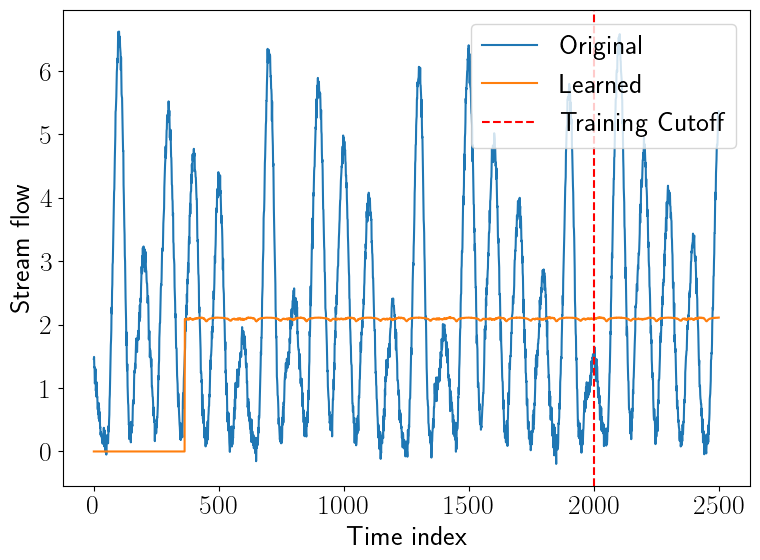

In [12]:
# Plot learned signal
plt.figure(figsize=figsize)
plt.plot(i, v, label='Original')
plt.plot(i, v_net, label='Learned')
plt.axvline(x=i_train[-1], color='r', linestyle='--', label='Training Cutoff')
plt.legend(loc='upper right')
plt.xlabel("Time index")
plt.ylabel("Stream flow")
plt.tight_layout()
plt.show()